
## Delta GPTs - (Train on 100, 200, 300 and predict the next 20)

* Delta: SI differences
* compare 100 to 200 to 300
* Written to run on GPU
* Long train so best run on GPU
* Next Cast is green line
* Saves Results to text file



## Parameters


In [1]:

vocab_size = 1000



## Experimental Details


In [2]:


exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.close()




## Libraries


In [3]:

##!pip install xgboost
## !pip install matplotlib
## !pip install scikit-learn
## !pip install einops


In [4]:

import pandas as pd
import numpy as np


In [5]:

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [6]:

## import xgboost as xgb
## from xgboost import XGBClassifier, XGBRegressor, DMatrix, train as train_xgb


In [7]:


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import torch
import pandas as pd
import sklearn
import random
import math


In [8]:

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

## coefficient of determination 
from sklearn.metrics import r2_score



## Univariate permutation example


In [9]:

from einops import rearrange
from math import sqrt, log


In [10]:

patch_size = 10
stride     = 4

x_enc = torch.rand( 8, 40, 24)
print( x_enc.shape )

B, L, M = x_enc.shape
print(B)
print(L)
print(M)

x_enc = rearrange(x_enc, 'b l m -> b m l')
print( x_enc.shape )

x_enc = x_enc.unfold(dimension=-1, size=patch_size, step=stride)
print( x_enc.shape )

x_enc = rearrange(x_enc, 'b m n p -> (b m) n p')
x_enc.shape


torch.Size([8, 40, 24])
8
40
24
torch.Size([8, 24, 40])
torch.Size([8, 24, 8, 10])


torch.Size([192, 8, 10])


## Positional Encoding example


In [11]:

def PositionalEncoding(q_len, d_model, normalize=True):
    pe = torch.zeros(q_len, d_model)
    position = torch.arange(0, q_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    if normalize:
        pe = pe - pe.mean()
        pe = pe / (pe.std() * 10)
    return pe


In [12]:

res = PositionalEncoding(15, 512, normalize=True)
res.shape


torch.Size([15, 512])

In [13]:

device = "cpu"


In [14]:

x_enc = torch.rand( 8, 15, 512)
print( x_enc.shape )


torch.Size([8, 15, 512])


In [15]:

pos_emb_table_rc         = nn.Embedding(15, 512)     ## [15, 512]


In [16]:

torch.arange(15, device=device)



tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [17]:

pos_emb = pos_emb_table_rc( torch.arange(15, device=device) ) 


In [18]:

pos_emb.shape


torch.Size([15, 512])

In [19]:

res = x_enc + pos_emb


In [20]:

res.shape


torch.Size([8, 15, 512])


## Moving Avg example


In [21]:

'''

class moving_avg(nn.Module):

    def __init__(self, x):
        
        super().__init__()
        
        self.kernel_size = x.shape[2]
        self.stride      = 1
        self.avg = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)

    def forward(self, x):
        

        x = self.avg( x )         ## x.permute(0, 2, 1))
        
        ## x = x.permute(0, 2, 1)
        
        return x

'''


'\n\nclass moving_avg(nn.Module):\n\n    def __init__(self, x):\n        \n        super().__init__()\n        \n        self.kernel_size = x.shape[2]\n        self.stride      = 1\n        self.avg = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)\n\n    def forward(self, x):\n        \n\n        x = self.avg( x )         ## x.permute(0, 2, 1))\n        \n        ## x = x.permute(0, 2, 1)\n        \n        return x\n\n'

In [22]:

'''

x_enc = torch.rand( 8, 40, 5)

print( x_enc.shape )

obj_mov_avg = moving_avg( x_enc  )

res = obj_mov_avg( x_enc )

print( x_enc[1, 2, :])

ans = x_enc - res

print( ans[1, 2, :])

print( ans.shape )

'''



'\n\nx_enc = torch.rand( 8, 40, 5)\n\nprint( x_enc.shape )\n\nobj_mov_avg = moving_avg( x_enc  )\n\nres = obj_mov_avg( x_enc )\n\nprint( x_enc[1, 2, :])\n\nans = x_enc - res\n\nprint( ans[1, 2, :])\n\nprint( ans.shape )\n\n'


## Read the data


In [23]:

for_RNN_data_CIVS = pd.read_csv('input/RNN_time_DELAYS_2000_PerCast_rcalix.csv')


In [24]:

for_RNN_data_CIVS


Unnamed: 0     SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0              1  0.719500                4.242439          2161.425209   
1              2  0.710486                4.174343          2168.238915   
2              3  0.666106                4.126144          2167.779119   
3              4  0.675145                4.120736          2166.974740   
4              5  0.776831                4.120331          2166.384674   
...          ...       ...                     ...                  ...   
1378        1379  0.762500                4.204430          2169.361647   
1379        1380  0.646000                4.208539          2169.079601   
1380        1381  0.654667                4.212648          2168.797556   
1381        1382  0.591667                4.217784          2168.444999   
1382        1383  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  ...  SE_Uptake_f3  NW_Uptake_f3  \
0              0.354        0.16  ...    182.533770    148.126483   
1              0.313        0.83  ...    183.725050    148.161842   
2              0.360        0.10  ...    195.812061    147.562523   
3              0.319        0.34  ...    188.028883    147.807509   
4              0.335        0.28  ...    200.141261    149.014319   
...              ...         ...  ...           ...           ...   
1378           0.343        0.30  ...    185.900341    148.103530   
1379           0.324        0.30  ...    182.408576    148.106012   
1380           0.325        0.16  ...    181.684649    148.108493   
1381           0.335        0.26  ...    195.202191    148.111595   
1382           0.328        1.08  ...    220.149599    148.115317   

      SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       192.512412     37.369999    36.439999         9.86   
1       192.366046     35.540001    35.970001         9.03   
2       198.423474     34.849998    36.590000         9.13   
3       179.116839     34.009998    35.900002         8.82   
4       186.052137     34.380001    35.970001         8.73   
...            ...           ...          ...          ...   
1378    199.914193     35.900002    37.259998        10.04   
1379    193.501805     35.900002    37.259998        10.04   
1380    194.328694     35.580002    36.500000         9.30   
1381    215.606202     35.130001    37.470001        10.01   
1382    250.937261     35.570000    36.970001         9.47   

      SNORT_VALVE_POSITION_f3  TOP_PRESS_f3  HOT_BLAST_PRESSURE_f3  \
0                   98.334297     18.532928              36.602600   
1                   98.334297     18.397217              36.882963   
2                   98.334297     18.393974              36.568884   
3                   98.334297     18.370316              36.839147   
4                   98.334297     18.395860              36.658018   
...                       ...           ...                    ...   
1378                98.334297     18.209401              36.727897  

In [25]:

cols_list_DF = for_RNN_data_CIVS.columns.values.tolist()
cols_list_DF


['Unnamed: 0',
 'SI_f1',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']

In [26]:

l_new = ['SI_f1',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']


In [27]:

for_RNN_data_CIVS = for_RNN_data_CIVS[l_new]


In [28]:

for_RNN_data_CIVS 


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.719500                4.242439          2161.425209   
1     0.710486                4.174343          2168.238915   
2     0.666106                4.126144          2167.779119   
3     0.675145                4.120736          2166.974740   
4     0.776831                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.762500                4.204430          2169.361647   
1379  0.646000                4.208539          2169.079601   
1380  0.654667                4.212648          2168.797556   
1381  0.591667                4.217784          2168.444999   
1382  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  ...  SE_Uptake_f3  \
0              0.354        0.16            21.080431  ...    182.533770   
1              0.313        0.83            20.996415  ...    183.725050   
2              0.360        0.10            20.749627  ...    195.812061   
3              0.319        0.34            20.609259  ...    188.028883   
4              0.335        0.28            20.617383  ...    200.141261   
...              ...         ...                  ...  ...           ...   
1378           0.343        0.30            21.039583  ...    185.900341   
1379           0.324        0.30            21.043999  ...    182.408576   
1380           0.325        0.16            21.048415  ...    181.684649   
1381           0.335        0.26            21.053935  ...    195.202191   
1382           0.328        1.08            21.060559  ...    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       149.014319    186.052137     34.380001    35.970001         8.73   
...            ...           ...           ...          ...          ...   
1378    148.103530    199.914193     35.900002    37.259998        10.04   
1379    148.106012    193.501805     35.900002    37.259998        10.04   
1380    148.108493    194.328694     35.580002    36.500000         9.30   
1381    148.111595    215.606202     35.130001    37.470001        10.01   
1382    148.115317    250.937261     35.570000    36.970001         9.47   

      SNORT_VALVE_POSITION_f3  TOP_PRESS_f3  HOT_BLAST_PRESSURE_f3  \
0                   98.334297     18.532928              36.602600   
1                   98.334297     18.397217              36.882963   
2                   98.334297     18.393974              36.568884   
3                   98.334297     18.370316              36.839147   
4                   98.334297     18.395860              36.658018   
...                       ...    


## Plots


In [29]:

plt.rcParams["figure.figsize"] = [15, 5]


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

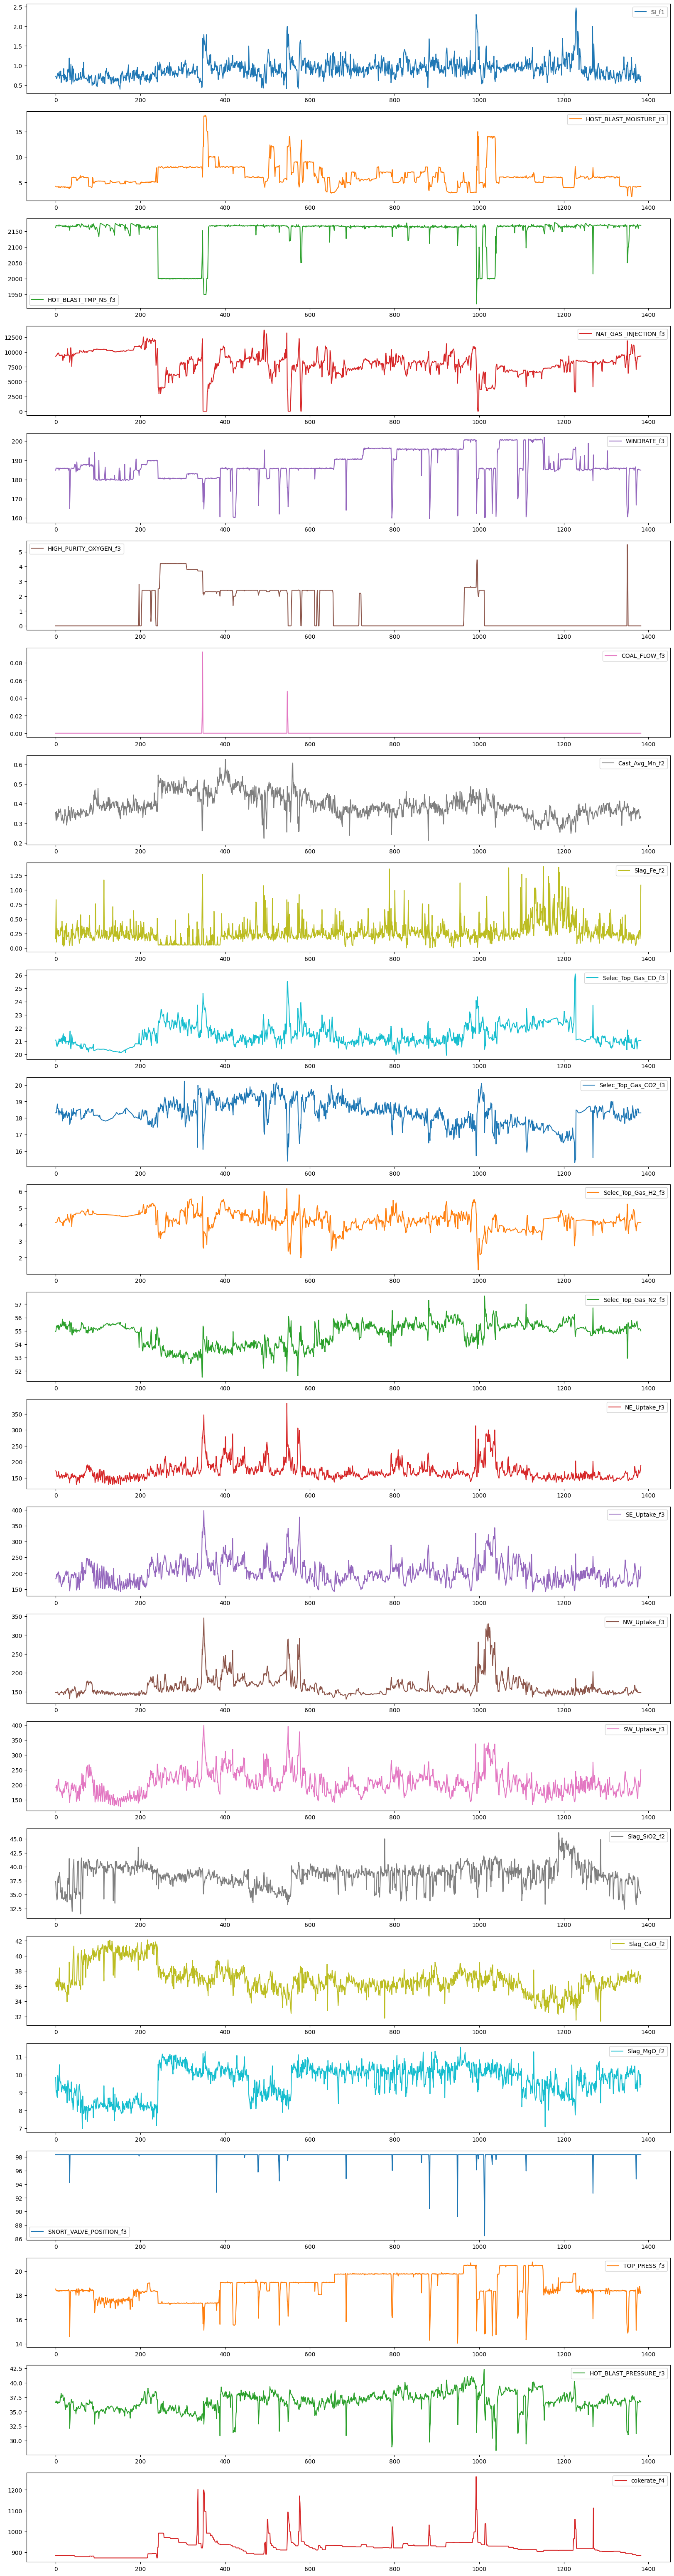

In [30]:

for_RNN_data_CIVS.plot( kind='line', subplots=True, figsize=(20,80),
        sharex=False, sharey=False, legend=True )


In [31]:

print(for_RNN_data_CIVS.shape)


(1383, 24)



## Parameters


In [32]:

pd.options.display.max_columns = None



## Standardize (Scaling)


In [33]:

def standardize_x_scales( data_gpt_pd ):


    data_gpt = torch.tensor(data_gpt_pd.values).float()
        
    epsilon = 0.0001

    print( data_gpt.shape)        
    
    x_means      = data_gpt .mean(0,  keepdim=True)
    x_deviations = data_gpt .std( 0,  keepdim=True) + epsilon

    ## x_train_tr_scaled = (x_train_tr - x_means) / x_deviations
    ## y_test_tr_scaled  = (y_test_tr  - y_means) / y_deviations
    
    return data_gpt, x_means, x_deviations


In [34]:

## x_means      = simple_x_train.mean(0, keepdim=True ) 
## x_deviations = simple_x_train.std( 0, keepdim=True) + epsilon



## Shift and create batches


In [35]:

def get_batch( data_gpt ):
    
    ix = torch.randint(   len(data_gpt) - block_size, (batch_size,)   )

    x  = torch.stack(    [  data_gpt[   i   : i+block_size    ]   for i in ix ]    ) 
    y  = torch.stack(    [  data_gpt[   i+1 : i+1+block_size  ]   for i in ix ]    )
    
    x, y = x.to(device), y.to(device)

    return x, y


In [36]:

'''

train_CIVS_tr, x_means, x_standard_devs = standardize_x_scales( train_CIVS )

train_CIVS_tr_scaled = ( train_CIVS_tr - x_means ) / x_standard_devs

bt_train_x, bt_train_y = get_batch( train_CIVS_tr_scaled )

bt_train_x.shape

bt_train_y.shape

x_means

'''


'\n\ntrain_CIVS_tr, x_means, x_standard_devs = standardize_x_scales( train_CIVS )\n\ntrain_CIVS_tr_scaled = ( train_CIVS_tr - x_means ) / x_standard_devs\n\nbt_train_x, bt_train_y = get_batch( train_CIVS_tr_scaled )\n\nbt_train_x.shape\n\nbt_train_y.shape\n\nx_means\n\n'


## Estimate loss - No Training


In [37]:

@torch.no_grad()    ## for efficient processing
def estimate_loss( model, criterion ):
    
    out = {}
    model.eval()   ## set to no training
    
    for split in ['train', 'test']:
        losses = torch.zeros(eval_iters)
        for k in range( eval_iters ):
            X, Y = get_batch( split )
            logits  = model(X, Y)
            B, T, E  = logits.shape
            pred     = logits.view( B*T, E)
            y_train  = Y.view(B*T, E)
            loss =  criterion( pred, y_train )
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()  ## back to training

    return out



## NN Architectures


In [38]:

class Head(nn.Module):

    def __init__(self, head_size):
        super().__init__()
        
        self.key   = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]
        self.query = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]
        self.value = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]

        tril_def = torch.tril( torch.ones(block_size, block_size) )  ## [40, 40]
        
        self.register_buffer(
                  'tril', 
                  tril_def
               )
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        
        B, T, E = x.shape   ## [batch_size, 40, 512] or [B, 15, 512]
        
        k = self.key(   x )            ## k = (B, T, 64)
        q = self.query( x )            ## q = (B, T, 64)

        E2 = 64     ## I think this is 64 and not 512
        ## (B, T, E) @ (B, E, T)  -> (B, T, T)
        wei = q @ k.transpose(-2, -1) * E2 ** -0.5        
        
        wei = wei.masked_fill(
                      self.tril[:T, :T] == 0, 
                      float('-inf')
        )   
        
        ## (B, T, T)
        wei = F.softmax( wei, dim= -1 )         ## (B, T, T)
        wei = self.dropout(   wei   )
        
        v   = self.value(  x  )   ## x = (B, 40, E)
        out = wei @ v             ## (B, T, T) @ (B, T, 64) -> (B, T, 64)
        
        return out
        


In [39]:

class FeedForward(nn.Module):

    def __init__(self, n_embd):         ## 512
        
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),      ## [512, 4*512]
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),      ## [4*512, 512]
            nn.Dropout(dropout),
        )
        
    def forward(self, x):
        return self.net(x)


In [40]:

class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, head_size):    ## (8, 64)
        super().__init__()
        self.heads = nn.ModuleList(  [ Head(head_size) for _ in range(num_heads) ] )
        self.proj  = nn.Linear(n_embd, n_embd)   ## 512, 512
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        out = torch.cat(   [ h(x) for h in self.heads ], dim = -1   )
        out = self.proj(  out   )
        out = self.dropout(   out   )
        return out


In [41]:

class Block(nn.Module):
    
    def __init__(self, n_embd, n_head):     ## (512, 8)
        super().__init__()
        head_size = n_embd // n_head        ## 64
        self.sa   = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward( n_embd)    ## 512
        self.ln1  = nn.LayerNorm(n_embd)
        self.ln2  = nn.LayerNorm(n_embd)
        
    def forward(self, x):
        x = x + self.sa(     self.ln1(x)      )
        x = x + self.ffwd(   self.ln2(x)      )
        return x


In [42]:

class moving_avg(nn.Module):

    def __init__(self, x):
        
        super().__init__()
        
        self.kernel_size = x.shape[2]
        self.stride      = 1
        self.avg = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)

    def forward(self, x):
        

        x_avg = self.avg( x )         ## x.permute(0, 2, 1))
        
        ## x = x.permute(0, 2, 1)

        x = x + x_avg
        
        return x


In [43]:

m = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False) 
  
input2 = torch.randn(8, 4, 25)

input_permute = rearrange(input2, 'b l m -> b m l')
print( input_permute.shape )
input2 = input2.unsqueeze(1)
input_permute = input_permute.unsqueeze(1)
output = m(input_permute)
output.shape


torch.Size([8, 25, 4])


torch.Size([8, 1, 25, 4])

In [44]:

inputs = torch.randn( 64, 1, 300 ) 

module = torch.nn.Conv1d(
    in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False
)

## module.weight.data = torch.full_like( module.weight.data, 0.2 )

out = module(inputs)
out.shape


torch.Size([64, 1, 300])

In [45]:

## a = torch.tensor( 42.6 )

## torch.round(a).int().item()


In [46]:

class Time_Series_GPT(nn.Module):
    
    def __init__(self, seq_length, input_size, output_size):
        
        super().__init__()
        
        self.output_size = output_size
        self.seq_length  = seq_length       ## 40 or 15
        self.input_size  = input_size

        vocab_size = 30
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)   ## [65, 512]
        
        self.pos_emb_table         = nn.Embedding(block_size, n_embd)     ## [block, 512] or [40, 512]
        
        self.blocks = nn.Sequential(
                *[   Block(n_embd, n_head=n_head) for _ in range(n_layer)    ]
        )
        
        self.ln_f        = nn.LayerNorm(  n_embd    )        
        self.lm_ffw_head = nn.Linear(n_embd, 25)  ## [512, 65] # FFW Layer

        #######################################################################

        self.map_24_512 = nn.Linear(25, 512)  ## [24, 512] # projection
        self.map_act    = nn.ReLU()

        #######################################################################

        self.map_24_512_1 = nn.Linear(25, 100)  ## [24, 512] # projection
        self.map_act1     = nn.ReLU()
        self.LayerNorm1   = nn.LayerNorm( 100 )
        self.map_24_512_2 = nn.Linear(100, 512)  ## [24, 512] # projection
        
   
        #####################################

        self.linear1_TS_int = nn.Linear(25, 15)
        self.act1_TS_int    = nn.ReLU()
        self.linear2_TS_int = nn.Linear(15, 9)
        self.act2_TS_int    = nn.ReLU()
        self.linear3_TS_int = nn.Linear(9, vocab_size)
        self.act3_TS_int    = nn.Softmax(dim=1)
        self.dropout_TS_int = nn.Dropout(0.25)
        
        #####################################

        self.conv_idx     = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False) 
        self.per_conv_idx = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False) 
  
        #####################################
        

    def forward(self,  idx, targets):

        ## print( idx.shape      )
        ## print( targets.shape  )
        ######################

        ## obj_mov_avg = moving_avg(  idx  )
        ## res         = obj_mov_avg( idx )
        ## idx = res

        #####################

        B = idx.shape[0]       ## 8 batch 
        T = idx.shape[1]       ## 40 or 15

        ############################################################
        ## add this back - rc

        ## idx = self.map_24_512( idx )       ## (8, 15, 24) goes in
        ## idx = self.map_act(    idx )
        
        ## tok_emb = idx       ## (B, 15, 512)

        ###########################################################

        idx = self.map_24_512_1( idx )       ## (8, 15, 24) goes in
        idx = self.map_act1(     idx )
        idx = self.LayerNorm1(   idx )
        idx = self.map_24_512_2( idx ) 
        
        tok_emb = idx       ## (B, 15, 512)

        ###########################################################
        ## convolutions

        idx_4d_conv = idx.unsqueeze(1)
        
        conv_emb = self.conv_idx( idx_4d_conv )
        conv_emb = conv_emb.squeeze(1)
        

        ## Permute
        idx_4d_conv_permute = rearrange(idx_4d_conv, 'b c l m -> b c m l')
        per_conv_emb = self.per_conv_idx( idx_4d_conv_permute )
        per_conv_emb = rearrange(per_conv_emb, 'b c m l -> b c l m')
        per_conv_emb = per_conv_emb.squeeze(1)

        ###########################################################
        
        pos_emb = self.pos_emb_table( torch.arange(T, device=device) )  
        
        ## pos_emb = PositionalEncoding(T, n_embd, normalize=True)   ## sines and cosines

        ###########################################################
        
        ## x = tok_emb + pos_emb + conv_emb + per_conv_emb    ## [B, T, E] or [N, 40, 512], now [N, 15, 24]

        x = pos_emb + per_conv_emb 

        ############################################################
        
        x = self.blocks(  x  )   ## (B, T, E)   
        x = self.ln_f(    x  )   ## (B, T, E)   ## norm
        logits = self.lm_ffw_head(x)         ## [B, 40, 65]  or [N, 15, 24]
        
        return logits
        
        
    def generate(self, idx, max_new_tokens):    ## idx is (B, T)
        print("max tokens ", max_new_tokens)
        print(idx.shape)
        for _ in range(max_new_tokens):
            ## crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:, :]
            logits = self(idx_cond, 0 )    ## ## get preds
            logits = logits[:, -1, :]    ## focus on last one (B, E)
            logits = logits.unsqueeze(0)
            ## probs = F.softmax(logits, dim= -1)    ## (B, E) get probs
            ## idx_next = torch.multinomial(probs, num_samples=1)     ## (B, 1) selected
            idx = torch.cat(  (idx, logits), dim=1  )   ## (B, T+1) append sample to running sequence
            
        return idx
            



## Train GPT function


In [47]:

def train_model_GPT( train_CIVS_2 ):
 
    
    model  = Time_Series_GPT(block_size, 25, 25)
    model  = model.to( device )
    
    optimizer       = torch.optim.Adam(     model.parameters(), lr=learning_rate   )

    criterion          = nn.MSELoss()
    ## criterion       = nn.L1Loss()
    ## criterion_kl    = nn.KLDivLoss(reduction="batchmean")
    
    history = {'loss': [], 'test_loss': []}
    
    train_CIVS_tr, x_means, x_standard_devs    = standardize_x_scales( train_CIVS_2 )

    train_CIVS_tr_scaled = ( train_CIVS_tr - x_means ) / x_standard_devs
        
    model.train()
    
    for batch_i, epoch in enumerate( range(max_iters) ):

        xb, yb    = get_batch( train_CIVS_tr_scaled )

        logits   = model( xb, yb )

        B, T, E  = logits.shape
        
        pred           = logits.view( B*T, E )
        y_train        = yb.view(     B*T, E )

        #######################################################
        ## loss_cost = 0.0
        ## loss =  ( 1.0-loss_cost ) * criterion( pred, y_train ) + ( loss_cost ) * criterion( pred[:, 0], y_train[:, 0]  ) 

        #######################################################
        ## ind1 = random.randrange(0, y_train.shape[0] - 3)
        ## ind2 = ind1 + 3
        ## loss =  criterion( pred[ind1:ind2, 0], y_train[ind1:ind2, 0] )
        #######################################################

        ## loss = criterion( pred[:, 0], y_train[:, 0]  )
        #######################################################

        loss =  criterion( pred, y_train )      ## seems better
        
        optimizer.zero_grad( set_to_none=True )          
        loss.backward()
        optimizer.step()

        history['loss'].append(  loss.item()  )

        if batch_i % 500 == 0:
            print(batch_i, "train loss = ", loss.item() )

    
    return model, history, x_means, x_standard_devs



## Parameters


In [48]:

torch.manual_seed(256)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

block_size        = 15   ##   40      ## N tokens in sequence
batch_size        = 16 
max_iters         = 3000   ## 5000
eval_interval     = 500     
learning_rate     = 0.0001
eval_iters        = 300
vocab_size        = 88  ## 65

## every id for a given token is embedded to vector of this size

n_embd            = 512       ## 24        ## 512       ## 24 for time series, silicon is 0           
n_head            = 8         ## 8 attention heads
n_layer           = 6         ## 6 eoncoder layers
dropout           = 0.2

comment_exp       = "None"



## Utility Functions


In [49]:

def GPT_get_batch_test( test_data ):
    
    ## x_time_series = torch.tensor(test_data.values).float()       ## pandas to torch

    x_time_series = test_data

    x  = torch.stack(   [   x_time_series[ 0 : -1    ]    ]    ) 
    y  = torch.stack(   [   x_time_series[ 1 :       ]    ]    )
    
    x, y = x.to(device), y.to(device)

    return x, y


In [50]:

def RSE(pred, true):
    return np.sqrt(np.sum((true - pred) ** 2)) / np.sqrt(np.sum((true - true.mean()) ** 2))


def MAE(pred, true):
    return np.mean(np.abs(pred - true))


def MSE(pred, true):
    return np.mean((pred - true) ** 2)


def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))


def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))


def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))


def metric(pred, true):
    mae  = MAE( pred, true)
    mse  = MSE( pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)
    mspe = MSPE(pred, true)
    rse  = RSE( pred, true)

    return mae, mse, rmse, mape, mspe, rse      


In [51]:

def GPT_generate_inference(model, x_test, which_feature, string_feature, train_CIVS_2_a ):

    xb_test, yb_test = GPT_get_batch_test( x_test )

    input_test_x = xb_test[ :,  : 5 ]         ## give first 4 in sequence for GPT to generate the rest
    
    pred_20_seq = model.generate( input_test_x, 14 )

    y_pred_gpt     = pred_20_seq.detach().cpu().numpy() 
    y_real_gpt     =     yb_test.detach().cpu().numpy() 
    
    find_index = index_to_slice + 395
    SI_data    = SI_lookup_for_RNN_data_CIVS.to_numpy()[ find_index:find_index+19, 0 ]  ## real SI data is here

    y_real_gpt = y_real_gpt.squeeze(0)
    y_pred_gpt = y_pred_gpt.squeeze(0)

    l_real = y_real_gpt[ :, 0 ]   
    l_pred = y_pred_gpt[ :, 0 ]

    l_SI_data_real = SI_data
    si_mean         = x_means[0, 0].numpy()
    si_standard_dev = x_standard_devs[0, 0].numpy()

    ##################################################

    l_real_all_24_features = y_real_gpt[ :, :]
    l_pred_all_24_features = y_pred_gpt[ :, :]
    si_mean_all_24_features         = x_means[0, :].numpy()
    si_standard_dev_all_24_features = x_standard_devs[0, :].numpy()
    l_pred_all_24_features        = l_pred_all_24_features   * si_standard_dev_all_24_features   + si_mean_all_24_features
    l_real_all_24_features        = l_real_all_24_features   * si_standard_dev_all_24_features   + si_mean_all_24_features

    ##################################################
    ## y_descaled = y_scaled * self.y_deviations + self.y_means
    
    l_pred        = l_pred   * si_standard_dev   + si_mean
    l_real        = l_real   * si_standard_dev   + si_mean

    eval_criterion = nn.MSELoss()

    mse_eval_bins = eval_criterion(
                          torch.FloatTensor( l_pred ), 
                          torch.FloatTensor( l_real )
    )

    mse_eval_bins0_5 = eval_criterion(
                          torch.FloatTensor( l_pred[0:4] ), 
                          torch.FloatTensor( l_real[0:4] )
    )

    mse_eval_bins5_10 = eval_criterion(
                          torch.FloatTensor( l_pred[5:10] ), 
                          torch.FloatTensor( l_real[5:10] )
    )

    mse_eval_bins10_15 = eval_criterion(
                          torch.FloatTensor( l_pred[10:19] ), 
                          torch.FloatTensor( l_real[10:19] )
    )

    ###################################################
    
    metric_mse_loss_SI_only                = mse_eval_bins.item()
    metric_mae_mse_rmse_mape_mspe_rse_corr = metric(    l_pred, l_real ) 
    metric_rsquare_SI_only                 = r2_score(  l_real, l_pred )
    metric_rsquare_all_features            = r2_score( 
                 np.reshape( l_real_all_24_features, (-1) ), 
                 np.reshape( l_pred_all_24_features, (-1) ) 
    ) 

    #####

    results_string = "mse_SI_only," + str(round( metric_mse_loss_SI_only, 4)) 
    results_string = results_string + "," + "rsquare_SI_only" + "," + str(round( metric_rsquare_SI_only, 4))
    results_string = results_string + "," + "rsquare_all_features" + "," + str(round( metric_rsquare_all_features, 4))
    several_metrics = str( metric_mae_mse_rmse_mape_mspe_rse_corr ).replace("(", "").replace(")","")
    results_string = results_string + "," + "mae_mse_rmse_mape_mspe_rse"  + "," + several_metrics
    
    ###################################################

    print( string_feature )
    print("Test MSE Loss - SI only: ",        mse_eval_bins.item()         )     ## :.4f }')
    print("Test MSE Loss - SI only 0-5: ",    mse_eval_bins0_5.item()      )     ## :.4f }')
    print("Test MSE Loss - SI only 5-10: ",   mse_eval_bins5_10.item()     )     ## :.4f }')
    print("Test MSE Loss - SI only 10-15: ",  mse_eval_bins10_15.item()    )     ## :.4f }')
    print("mae, mse, rmse, mape, mspe, rse, corr")
    print(    metric_mae_mse_rmse_mape_mspe_rse_corr    )
    print( "Testing R**2 - SI only: ", metric_rsquare_SI_only  )
    print( "Testing R**2 - SI only: ", 
            r2_score(  
                 np.reshape( l_real, (-1) ), 
                 np.reshape( l_pred, (-1) )      
            )  
    )
    
    print( "Testing R**2 - All features: ", metric_rsquare_all_features )

    #######################################

    x = [ i for i in range(len(l_real)) ] 

    l_SI_data_pred = []
    ## www3 = SI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[find_index - 1, 0]
    www3 = SI_lookup_for_RNN_data_CIVS.to_numpy()[find_index - 1, 0]
    the_curr_val = www3            ##l_SI_data_real[0]  ### www3
    for i in range( len(l_pred) ):
        the_curr_val = the_curr_val + l_pred[i]
        l_SI_data_pred.append( the_curr_val )

    ########################################

    yellow_l_SI_data_pred = []
    for i in range( len(l_pred) ):
        ww4 = SI_lookup_for_RNN_data_CIVS.to_numpy()[find_index - 1 + i, 0]
        the_curr_val = ww4 + l_pred[i]
        yellow_l_SI_data_pred.append( the_curr_val )

    ########################################
    ## Plots

    plt.scatter(x, l_real, label = "real", color='red') 
    plt.plot(   x, l_real, label = "real", color='red') 
    plt.plot(   x, l_SI_data_real, label = "real", color='red') 
    
    l_pred = np.roll(l_pred, -1)
    
    plt.scatter(x, l_pred, label = "pred", color='blue') 
    plt.plot(   x, l_pred, label = "pred", color='blue') 
    plt.plot(   x, l_SI_data_pred, label = "pred", color='blue') 
    plt.plot(   x, yellow_l_SI_data_pred, label = "pred1c", color='green')   ## yellow
    
    plt.legend() 
    plt.show()

    ##########################################

    train_plot = torch.tensor(train_CIVS_2_a.values).float().numpy()
    train_real_plot = train_plot[:, 0]
    l_real  = np.concatenate( ( train_real_plot, l_real ) )
    l_pred  = np.concatenate( ( train_real_plot, l_pred ) )
    
    ##########################################

    x = [ i for i in range(len(l_real)) ] 

    x_delta = [ i for i in range(len(l_SI_data_real)) ] 

    fig, ax = plt.subplots(2, 1) 
    ax[0].set_title(f'GPT Generate')
    ##ax[0].plot(history_GPT['loss'],     'k--',   label='loss'      )
    ##ax[0].plot(history_GPT['test_loss'], 'k',    label='test_loss'  )
    ax[0].scatter(x, l_real, label = "real", color='red') 
    ax[0].plot(   x, l_real, label = "real", color='red') 
    ax[0].scatter(x, l_pred, label = "pred", color='blue') 
    ax[0].plot(   x, l_pred, label = "pred", color='blue') 
    ax[0].legend()

    ###########################################
    
    ax[1].set_title(f"GPT")
    ax[1].scatter(x_delta, l_SI_data_real, label = "real", color='red') 
    ax[1].plot(   x_delta, l_SI_data_real, label = "real", color='red') 
    ax[1].scatter(x_delta, l_SI_data_pred, label = "pred", color='blue') 
    ax[1].plot(   x_delta, l_SI_data_pred, label = "pred", color='blue') 
    ax[1].plot(   x_delta, yellow_l_SI_data_pred, label = "pred1c", color='green')   ## yellow  ## ?? rc
    fig.tight_layout()
    ax[1].legend(); plt.show()

    return results_string 


In [52]:

def function_train_rc(  train_data  ):
    
    train_CIVS_2 = train_data
    si_GPT, history_GPT, x_means, x_standard_devs = train_model_GPT( train_CIVS_2 )

    fig, ax = plt.subplots(2, 1) 
    ax[0].set_title(f'GPT  Train  Loss  per epoch')
    ax[0].plot(history_GPT['loss'],     'k--',   label='loss'      )
    ax[0].plot(history_GPT['test_loss'], 'k',    label='test_loss'  )
    ax[0].legend()
    ax[1].set_title(f"GPT")

    fig.tight_layout()
    ax[1].legend(); plt.show()

    return si_GPT, history_GPT, x_means, x_standard_devs 

    

In [53]:

def function_test_rc( train_data, test_CIVS, si_GPT, x_means, x_standard_devs):
    
    train_CIVS_2 = train_data
    
    print(  test_CIVS.shape )
    print( train_data.shape )
    ## print( train_data[ -5: ] )

    frames           = [ train_data[ -5: ], test_CIVS ]
    test_CIVS_concat = pd.concat( frames )
    print( test_CIVS_concat.shape )

    test_CIVS_tr = torch.tensor(test_CIVS_concat.values).float()
    test_CIVS_tr_scaled = ( test_CIVS_tr - x_means ) / x_standard_devs
    print(  test_CIVS_tr_scaled.shape )

    batch_x_test = test_CIVS_tr_scaled
    print( batch_x_test.shape )
    results_string = GPT_generate_inference(   si_GPT,  batch_x_test, 0 , "SI", train_CIVS_2 )
    return results_string


In [54]:

'''
SI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[1040:1054, 0]
print(SI_data.shape)
SI_data
'''


'\nSI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[1040:1054, 0]\nprint(SI_data.shape)\nSI_data\n'


## The Data


In [55]:

for_RNN_data_CIVS


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.719500                4.242439          2161.425209   
1     0.710486                4.174343          2168.238915   
2     0.666106                4.126144          2167.779119   
3     0.675145                4.120736          2166.974740   
4     0.776831                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.762500                4.204430          2169.361647   
1379  0.646000                4.208539          2169.079601   
1380  0.654667                4.212648          2168.797556   
1381  0.591667                4.217784          2168.444999   
1382  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       149.0


## Delta of SI


In [56]:

delta_for_RNN_data_CIVS      = for_RNN_data_CIVS.copy()
SI_lookup_for_RNN_data_CIVS  = for_RNN_data_CIVS.copy()


In [57]:

delta_for_RNN_data_CIVS 


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.719500                4.242439          2161.425209   
1     0.710486                4.174343          2168.238915   
2     0.666106                4.126144          2167.779119   
3     0.675145                4.120736          2166.974740   
4     0.776831                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.762500                4.204430          2169.361647   
1379  0.646000                4.208539          2169.079601   
1380  0.654667                4.212648          2168.797556   
1381  0.591667                4.217784          2168.444999   
1382  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       149.0

In [58]:

delta_for_RNN_data_CIVS.insert(loc = 0,
                                column = 'delta_SI',
                                value = 0 )



In [59]:

for_RNN_data_CIVS


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.719500                4.242439          2161.425209   
1     0.710486                4.174343          2168.238915   
2     0.666106                4.126144          2167.779119   
3     0.675145                4.120736          2166.974740   
4     0.776831                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.762500                4.204430          2169.361647   
1379  0.646000                4.208539          2169.079601   
1380  0.654667                4.212648          2168.797556   
1381  0.591667                4.217784          2168.444999   
1382  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       149.0

In [60]:

delta_for_RNN_data_CIVS


delta_SI     SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0            0  0.719500                4.242439          2161.425209   
1            0  0.710486                4.174343          2168.238915   
2            0  0.666106                4.126144          2167.779119   
3            0  0.675145                4.120736          2166.974740   
4            0  0.776831                4.120331          2166.384674   
...        ...       ...                     ...                  ...   
1378         0  0.762500                4.204430          2169.361647   
1379         0  0.646000                4.208539          2169.079601   
1380         0  0.654667                4.212648          2168.797556   
1381         0  0.591667                4.217784          2168.444999   
1382         0  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.84

In [61]:

## merge_date_key = ''
## i_6000 = 0
## merge_date_key = list_dates_6000f[ i_6000 ]


    
for index, row in delta_for_RNN_data_CIVS.iterrows():

    if index > 1:
        ## if row["MM_Timestamp_f1"] <= merge_date_key and row['Timestamp_f1'] == 'abc':
        delta_for_RNN_data_CIVS.at[index,'delta_SI']= delta_for_RNN_data_CIVS.at[index,'SI_f1'] - delta_for_RNN_data_CIVS.at[index-1,'SI_f1'] 
        ## print(delta_for_RNN_data_CIVS.at[index,'SI_f1'])

        
## merge_date_key = list_dates_6000f[ i_6000 ] 
## MinByMin_137MB_data_CIVS.at[index, 'Timestamp_f1'] = merge_date_key
        
## if index  % 50000 == 0:
## print(index )
 


In [62]:

delta_for_RNN_data_CIVS


delta_SI     SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.000000  0.719500                4.242439          2161.425209   
1     0.000000  0.710486                4.174343          2168.238915   
2    -0.044380  0.666106                4.126144          2167.779119   
3     0.009040  0.675145                4.120736          2166.974740   
4     0.101686  0.776831                4.120331          2166.384674   
...        ...       ...                     ...                  ...   
1378  0.109500  0.762500                4.204430          2169.361647   
1379 -0.116500  0.646000                4.208539          2169.079601   
1380  0.008667  0.654667                4.212648          2168.797556   
1381 -0.063000  0.591667                4.217784          2168.444999   
1382  0.133000  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.84

In [63]:

l_delta = ['delta_SI',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']


In [64]:

delta_for_RNN_data_CIVS = delta_for_RNN_data_CIVS[ l_delta]


In [65]:

delta_for_RNN_data_CIVS


delta_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.000000                4.242439          2161.425209   
1     0.000000                4.174343          2168.238915   
2    -0.044380                4.126144          2167.779119   
3     0.009040                4.120736          2166.974740   
4     0.101686                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.109500                4.204430          2169.361647   
1379 -0.116500                4.208539          2169.079601   
1380  0.008667                4.212648          2168.797556   
1381 -0.063000                4.217784          2168.444999   
1382  0.133000                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       14

In [66]:

for_RNN_data_CIVS = delta_for_RNN_data_CIVS



## Add Moving average to data


In [67]:


delta_for_RNN_data_CIVS .insert(loc = 1,
                                column = 'mov_avg_SI',
                                value = 0 )



In [68]:

delta_for_RNN_data_CIVS


delta_SI  mov_avg_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.000000           0                4.242439          2161.425209   
1     0.000000           0                4.174343          2168.238915   
2    -0.044380           0                4.126144          2167.779119   
3     0.009040           0                4.120736          2166.974740   
4     0.101686           0                4.120331          2166.384674   
...        ...         ...                     ...                  ...   
1378  0.109500           0                4.204430          2169.361647   
1379 -0.116500           0                4.208539          2169.079601   
1380  0.008667           0                4.212648          2168.797556   
1381 -0.063000           0                4.217784          2168.444999   
1382  0.133000           0                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523

In [69]:

delta_for_RNN_data_CIVS.shape[0]


1383

In [70]:


## for index, row in delta_for_RNN_data_CIVS.iterrows():

range_to_mean = 10

for i in range( 1, delta_for_RNN_data_CIVS.shape[0] ):
    index = delta_for_RNN_data_CIVS.shape[0] - i
    if index <= 10:
        ## range_to_mean = index -1
        break
    list_to_mean = []
    for j in range( range_to_mean ):
        list_to_mean.append(   delta_for_RNN_data_CIVS.at[ index-j , 'delta_SI' ]    )
    the_mean = np.array( list_to_mean )
    delta_for_RNN_data_CIVS.at[index,'mov_avg_SI']= np.mean(the_mean) 



In [71]:

delta_for_RNN_data_CIVS


delta_SI  mov_avg_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.000000    0.000000                4.242439          2161.425209   
1     0.000000    0.000000                4.174343          2168.238915   
2    -0.044380    0.000000                4.126144          2167.779119   
3     0.009040    0.000000                4.120736          2166.974740   
4     0.101686    0.000000                4.120331          2166.384674   
...        ...         ...                     ...                  ...   
1378  0.109500    0.004444                4.204430          2169.361647   
1379 -0.116500    0.008900                4.208539          2169.079601   
1380  0.008667   -0.037618                4.212648          2168.797556   
1381 -0.063000   -0.014340                4.217784          2168.444999   
1382  0.133000    0.011422                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523

In [72]:

for_RNN_data_CIVS = delta_for_RNN_data_CIVS



## Pick slice randomly


In [73]:

training_chunk = 400


In [74]:

length_n  = int( for_RNN_data_CIVS.shape[0] )

length_n


1383


## Run 1


In [75]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice


387

In [76]:

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )


1383
387
802


In [77]:

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]


In [78]:

sliced_chunk_CIVS


delta_SI  mov_avg_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
387  0.037898   -0.024115                8.284624          2167.459021   
388  0.219000    0.005355                7.967915          2168.025381   
389 -0.011323    0.000164                7.991780          2168.875526   
390  0.011510    0.013819                8.049993          2167.055675   
391  0.007041    0.002931                8.098958          2166.765915   
..        ...         ...                     ...                  ...   
797  0.023508    0.001022                4.950561          2160.128825   
798 -0.003295   -0.033038                4.948847          2163.936692   
799  0.044977   -0.012450                4.972388          2168.432232   
800 -0.168842   -0.025601                4.991452          2164.943074   
801  0.045792   -0.015096                5.013271          2163.624885   

     NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
387            8173.937649   180.813989               2.299255           0.0   
388            9372.548504   160.500207               2.002068           0.0   
389           10359.931343   185.528934               2.398869           0.0   
390           10555.027285   185.910215               2.401086           0.0   
391           10456.847453   185.718245               2.400453           0.0   
..                     ...          ...                    ...           ...   
797            9194.161196   190.934424               0.000000           0.0   
798            7721.220209   190.618423               0.000000           0.0   
799            7479.820172   190.577549               0.000000           0.0   
800            7566.836906   189.969200               0.000000           0.0   
801            8028.127119   190.702982               0.000000           0.0   

     Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
387           0.511        0.05            21.564986             19.237344   
388           0.583        0.05            21.002100             19.000001   
389           0.529        0.14            21.015686             18.656487   
390           0.549        0.17            20.956548             18.703498   
391           0.551        0.22            21.158497             18.472931   
..              ...         ...                  ...                   ...   
797           0.356        0.25            20.546236             18.197771   
798           0.372        0.17            20.677132             17.897697   
799           0.377        0.23            20.299413             18.822583   
800           0.342        0.21            20.895421             18.654812   
801           0.349        0.99            20.716705             18.287800   

     Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
387             4.609920            53.329206    162.483581    168.535366   
388             4.902863            53.783283    156.886000    163.647821   
389             5.184579            53.896061    191.241010    225.109151   
390             5.291269            53.688426    183.953794    223.729177   
391             5.366072            53.534237    208.870689    248.591865   
..                   ...                  ...           ...           ...   
797             5.464715            54.651343    177.454730    217.113233   
798             4.869771            55.436146    162.430872    205.024412   
799             4.573827            55.110957    177.719490    219.095481   
800             4.543790            54.854640    182.312876    216.599308   
801             4.703548            55.166934    168.287938    205.872462   

     NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
387    157.244784    172.770727     38.200001    38.650002        10.58   
388    153.513922    168.775079     37.900002    37.959999        10.46   
389    186.405030    240.046235     37.320000    37.580002        10


## Train and test


In [79]:

n = block_size

print( n )


15


In [80]:

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]


In [81]:

print( train_CIVS.shape )
print( test_CIVS.shape )


(400, 25)
(15, 25)


In [82]:

test_CIVS 


delta_SI  mov_avg_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
787 -0.118701   -0.005440                7.012399          2164.318027   
788  0.337301    0.036684                7.023565          2163.601611   
789 -0.160905   -0.003740                7.033989          2165.619377   
790 -0.037325   -0.015436                7.043834          2162.824238   
791 -0.059259   -0.002396                6.977896          2164.744007   
792 -0.291296   -0.032188                6.942346          2165.066895   
793  0.109963   -0.012587                6.129323          2164.119463   
794  0.349990    0.000198                6.432427          2161.791679   
795 -0.090014   -0.017153                7.513323          2133.107014   
796 -0.171745   -0.013199                5.830400          2162.279620   
797  0.023508    0.001022                4.950561          2160.128825   
798 -0.003295   -0.033038                4.948847          2163.936692   
799  0.044977   -0.012450                4.972388          2168.432232   
800 -0.168842   -0.025601                4.991452          2164.943074   
801  0.045792   -0.015096                5.013271          2163.624885   

     NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
787            8118.770394   196.340919                    0.0           0.0   
788            8380.943012   196.220421                    0.0           0.0   
789            9342.851823   196.518588                    0.0           0.0   
790            8938.045678   196.202966                    0.0           0.0   
791            6932.716911   196.231968                    0.0           0.0   
792            9053.752507   196.465191                    0.0           0.0   
793           10417.614699   187.788990                    0.0           0.0   
794            8442.997547   159.838347                    0.0           0.0   
795            7538.786211   163.961117                    0.0           0.0   
796            8029.631799   170.287194                    0.0           0.0   
797            9194.161196   190.934424                    0.0           0.0   
798            7721.220209   190.618423                    0.0           0.0   
799            7479.820172   190.577549                    0.0           0.0   
800            7566.836906   189.969200                    0.0           0.0   
801            8028.127119   190.702982                    0.0           0.0   

     Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
787           0.374        0.23            21.519732             18.808613   
788           0.331        1.36            21.109391             18.377992   
789           0.395        0.13            20.933991             18.566700   
790           0.356        0.25            20.944183             18.288672   
791           0.363        0.43            21.707375             18.937064   
792           0.372        0.68            22.132300             18.598657   
793           0.242        0.31            21.938837             17.688960   
794           0.319        0.45            20.868136             17.267176   
795           0.362        0.20            20.389316             16.984814   
796           0.375        0.38            20.486985             17.710116   
797           0.356        0.25            20.546236             18.197771   
798           0.372        0.17            20.677132             17.897697   
799           0.377        0.23            20.299413             18.822583   
800           0.342        0.21            20.895421             18.654812   
801           0.349        0.99            20.716705             18.287800   

     Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
787             4.094763            54.124713    157.583950    185.655960   
788             4.248424            54.923389    161.022471    183.086016   
789             4.494034            54.818204    163.869279

In [83]:

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


In [84]:

print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


(100, 25)
(200, 25)
(300, 25)
(400, 25)


In [85]:
'''
print(idx.shape)
        vals, indeces = torch.max( idx, dim=2  )
        print( vals.shape )
        print( indeces )
        print(idx.shape)
        input()
'''

'\nprint(idx.shape)\n        vals, indeces = torch.max( idx, dim=2  )\n        print( vals.shape )\n        print( indeces )\n        print(idx.shape)\n        input()\n'

torch.Size([100, 25])
0 train loss =  1.2690727710723877
500 train loss =  0.01948561891913414
1000 train loss =  0.008921055123209953
1500 train loss =  0.005963122472167015
2000 train loss =  0.004408643580973148
2500 train loss =  0.0033450117334723473


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


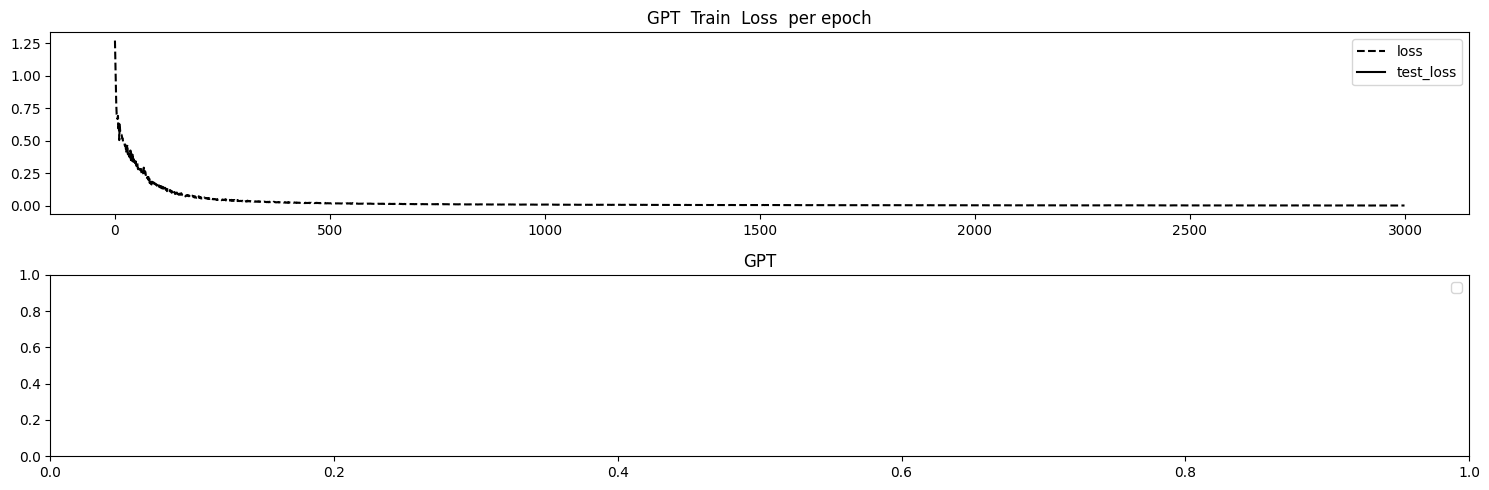

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.03843175247311592
Test MSE Loss - SI only 0-5:  0.05241861566901207
Test MSE Loss - SI only 5-10:  0.05718815326690674
Test MSE Loss - SI only 10-15:  0.025112994015216827
mae, mse, rmse, mape, mspe, rse, corr
(0.15513718, 0.038431752, 0.19604018, 1.7758461, 12.096387, 1.1465058)
Testing R**2 - SI only:  -0.3144759508411339
Testing R**2 - SI only:  -0.3144759508411339
Testing R**2 - All features:  0.9856089419234652


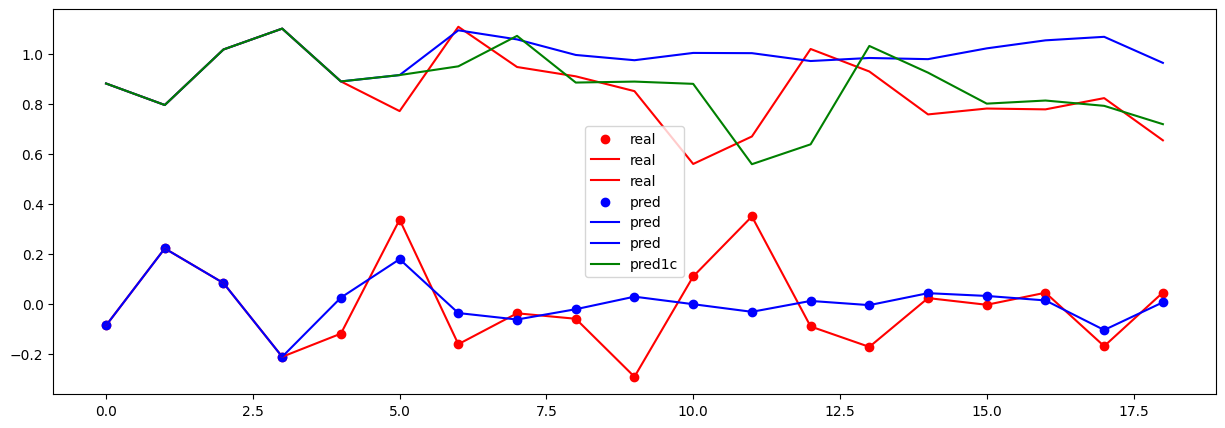

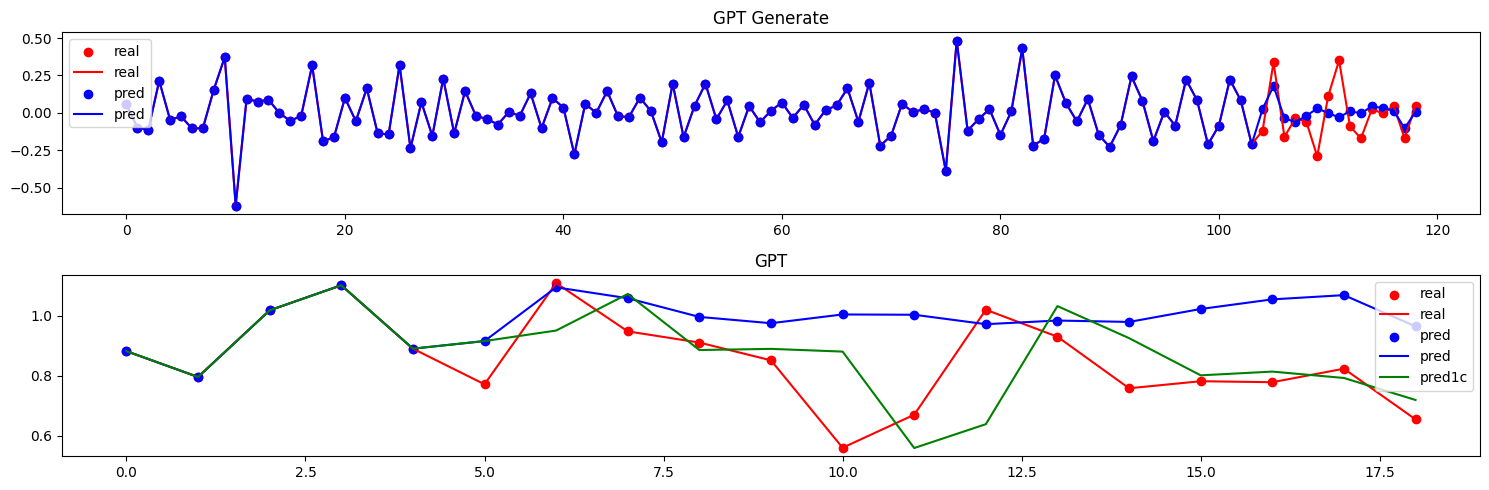

In [86]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([200, 25])
0 train loss =  1.3792109489440918
500 train loss =  0.028219614177942276
1000 train loss =  0.012310147285461426
1500 train loss =  0.007383713964372873
2000 train loss =  0.005494981072843075
2500 train loss =  0.004598003812134266


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


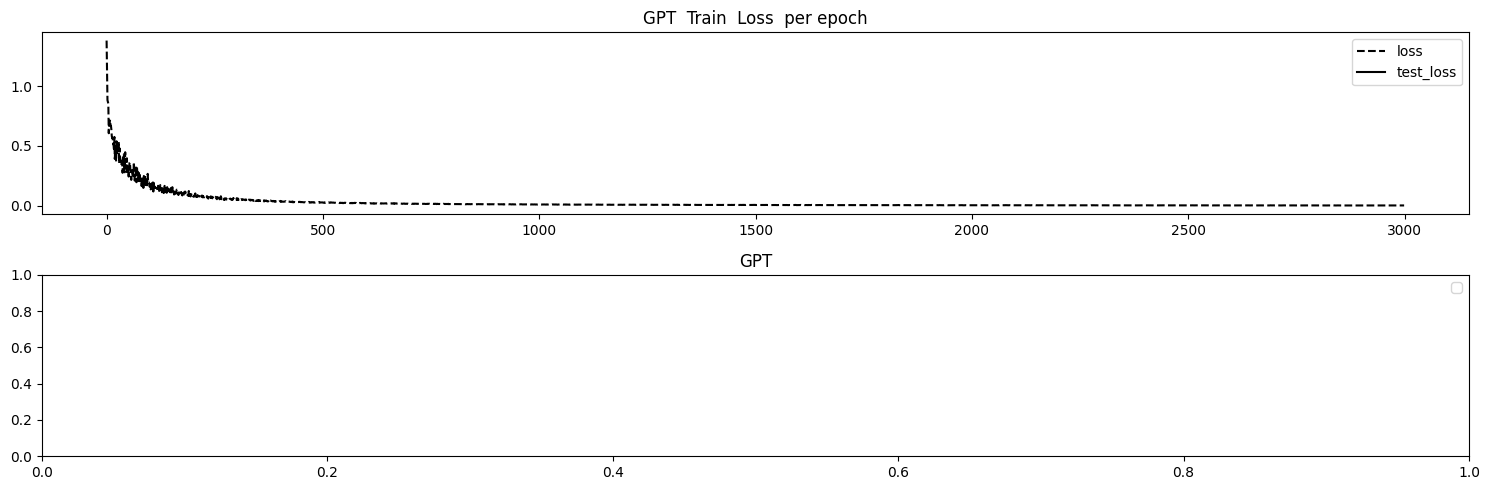

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.03278834745287895
Test MSE Loss - SI only 0-5:  0.05241861939430237
Test MSE Loss - SI only 5-10:  0.034616872668266296
Test MSE Loss - SI only 10-15:  0.025738736614584923
mae, mse, rmse, mape, mspe, rse, corr
(0.14919086, 0.032788344, 0.18107551, 2.1998913, 29.720362, 1.0589877)
Testing R**2 - SI only:  -0.12145519571803454
Testing R**2 - SI only:  -0.12145519571803454
Testing R**2 - All features:  0.9863052099561981


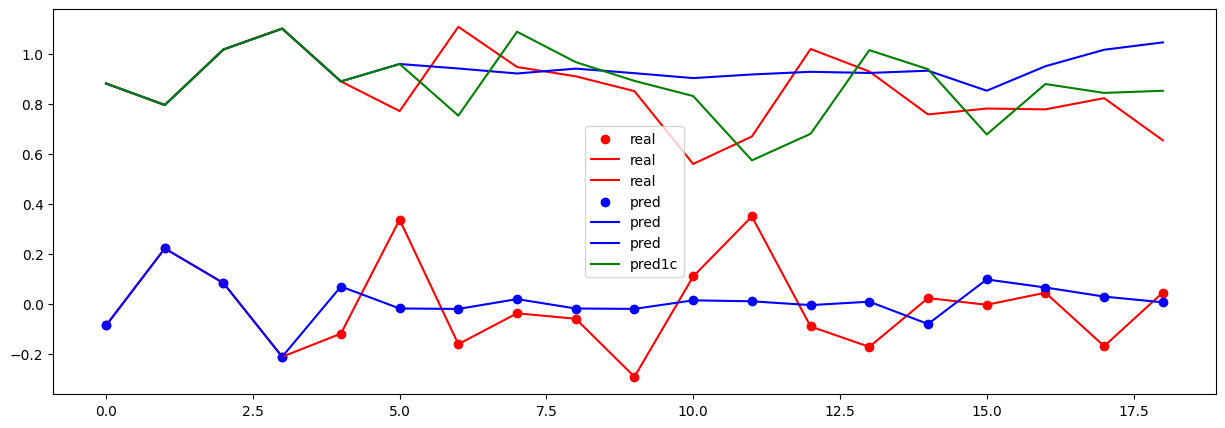

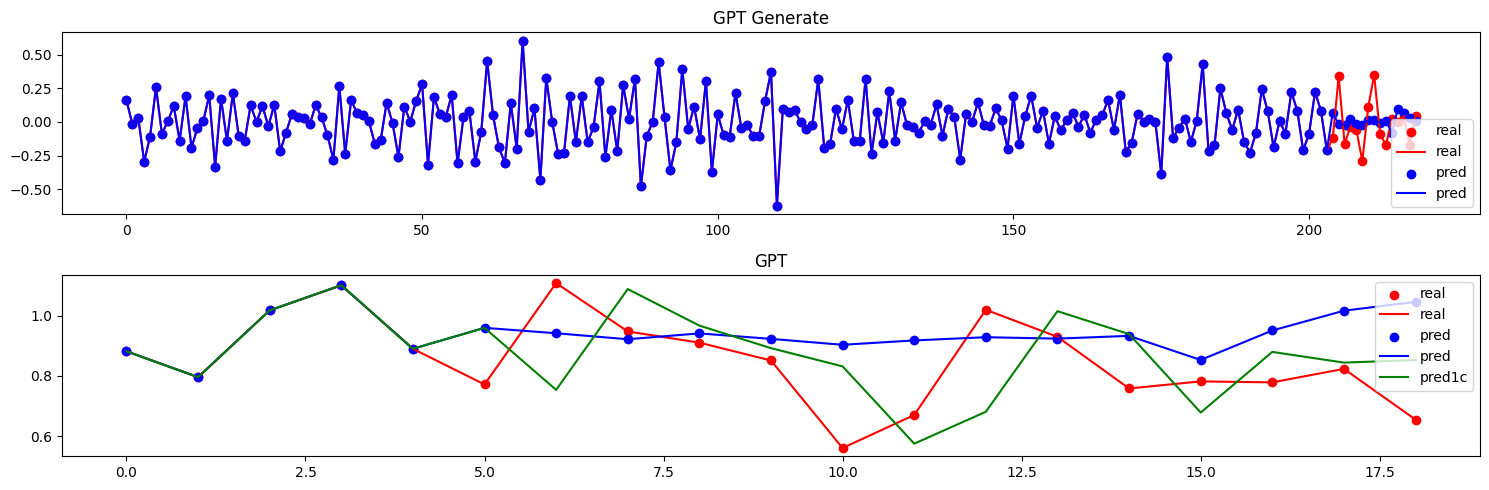

In [87]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([300, 25])
0 train loss =  1.2342548370361328
500 train loss =  0.04584674909710884
1000 train loss =  0.019959019497036934
1500 train loss =  0.013533961027860641
2000 train loss =  0.007826256565749645
2500 train loss =  0.006519822403788567


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


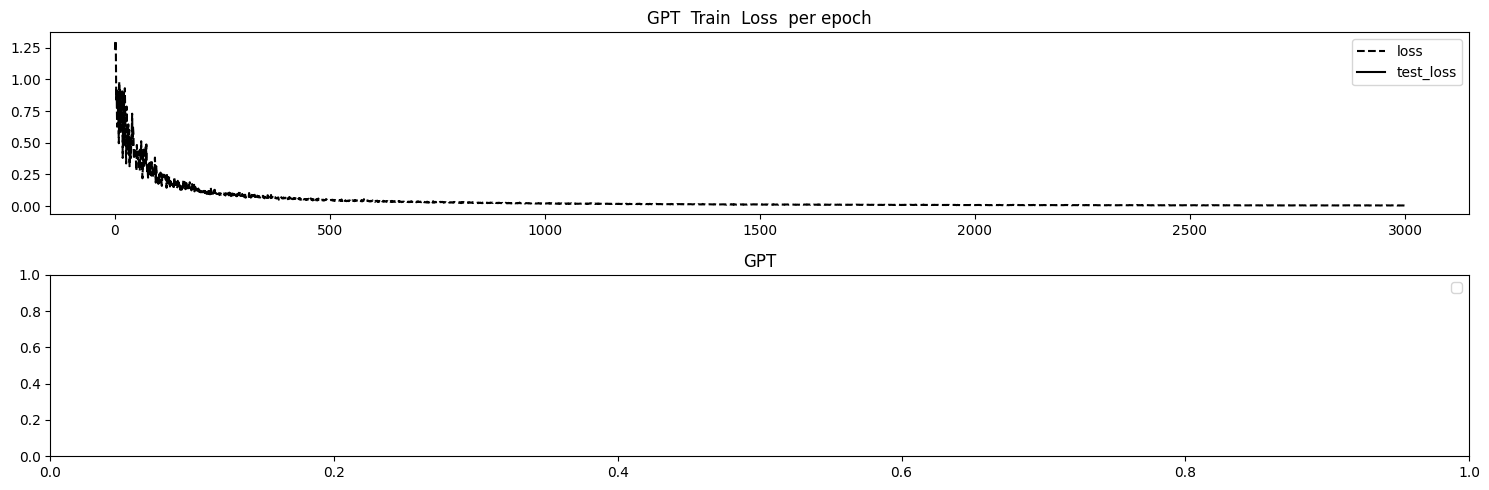

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.03381390497088432
Test MSE Loss - SI only 0-5:  0.05241861939430237
Test MSE Loss - SI only 5-10:  0.035073716193437576
Test MSE Loss - SI only 10-15:  0.0276500154286623
mae, mse, rmse, mape, mspe, rse, corr
(0.15438491, 0.03381391, 0.18388559, 1.7171922, 6.9558377, 1.0754219)
Testing R**2 - SI only:  -0.15653240910550892
Testing R**2 - SI only:  -0.15653240910550892
Testing R**2 - All features:  0.9788993865316075


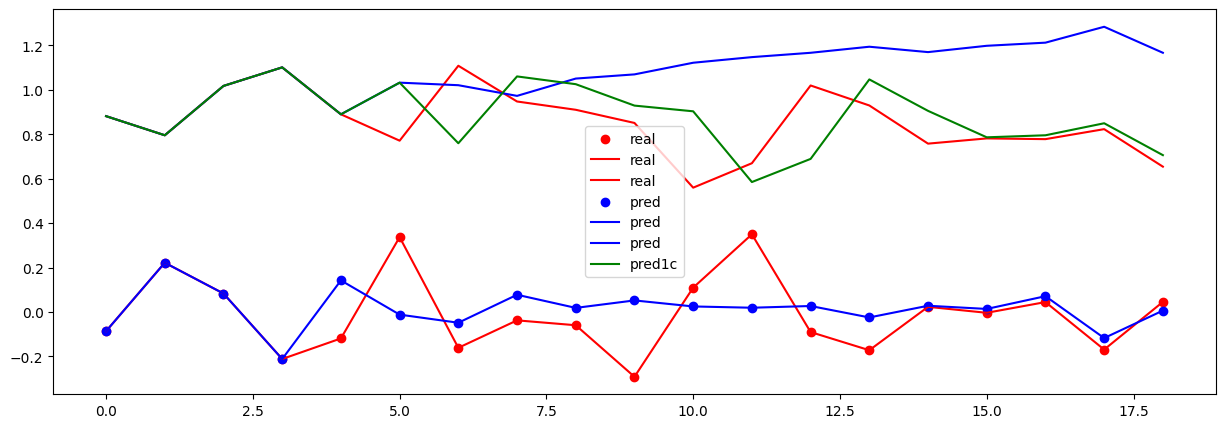

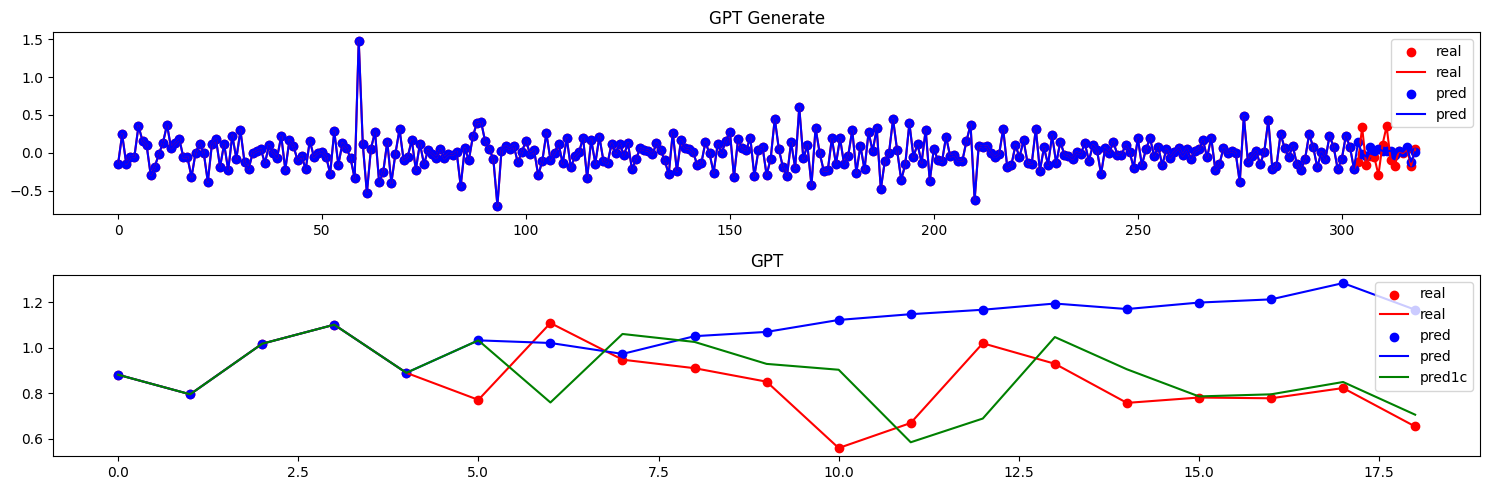

In [88]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 


torch.Size([400, 25])
0 train loss =  1.1622258424758911
500 train loss =  0.057141296565532684
1000 train loss =  0.026465021073818207
1500 train loss =  0.016272621229290962
2000 train loss =  0.009563476778566837
2500 train loss =  0.007760836277157068


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


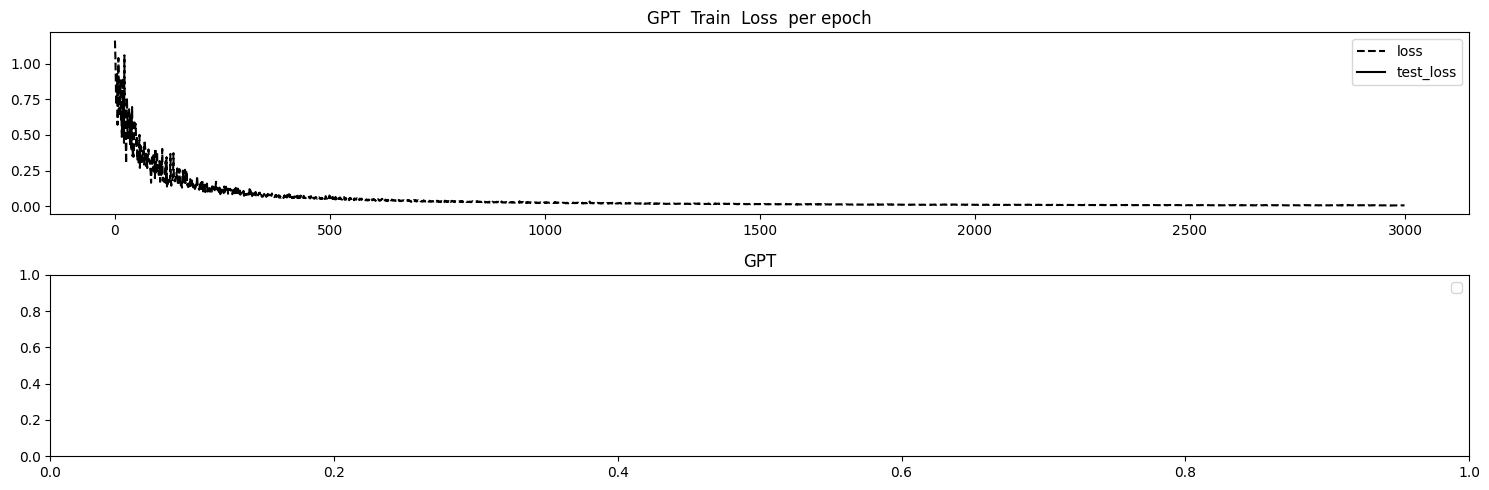

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.035611897706985474
Test MSE Loss - SI only 0-5:  0.05241861939430237
Test MSE Loss - SI only 5-10:  0.04166267067193985
Test MSE Loss - SI only 10-15:  0.027785228565335274
mae, mse, rmse, mape, mspe, rse, corr
(0.15405582, 0.035611898, 0.18871115, 1.7693843, 9.955951, 1.1036434)
Testing R**2 - SI only:  -0.21802873125357203
Testing R**2 - SI only:  -0.21802873125357203
Testing R**2 - All features:  0.98581348525461


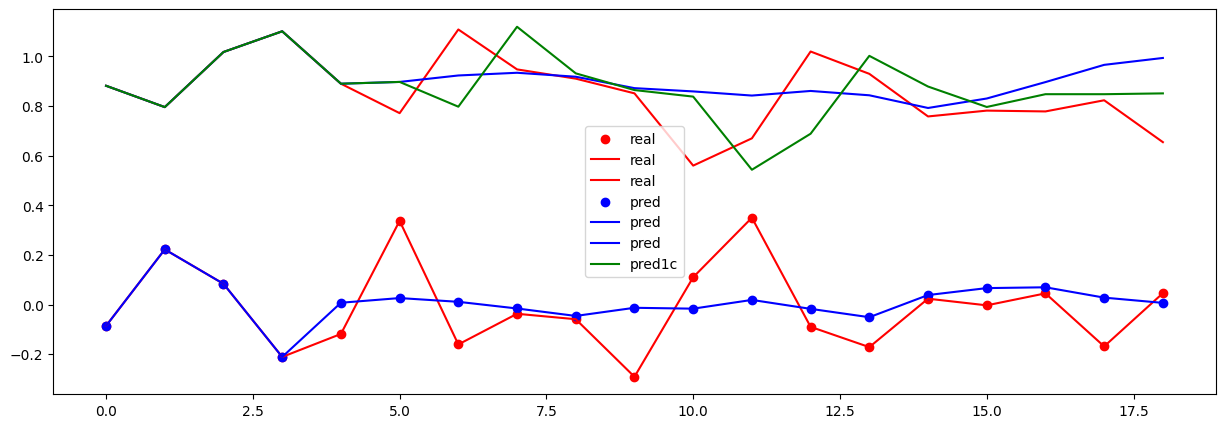

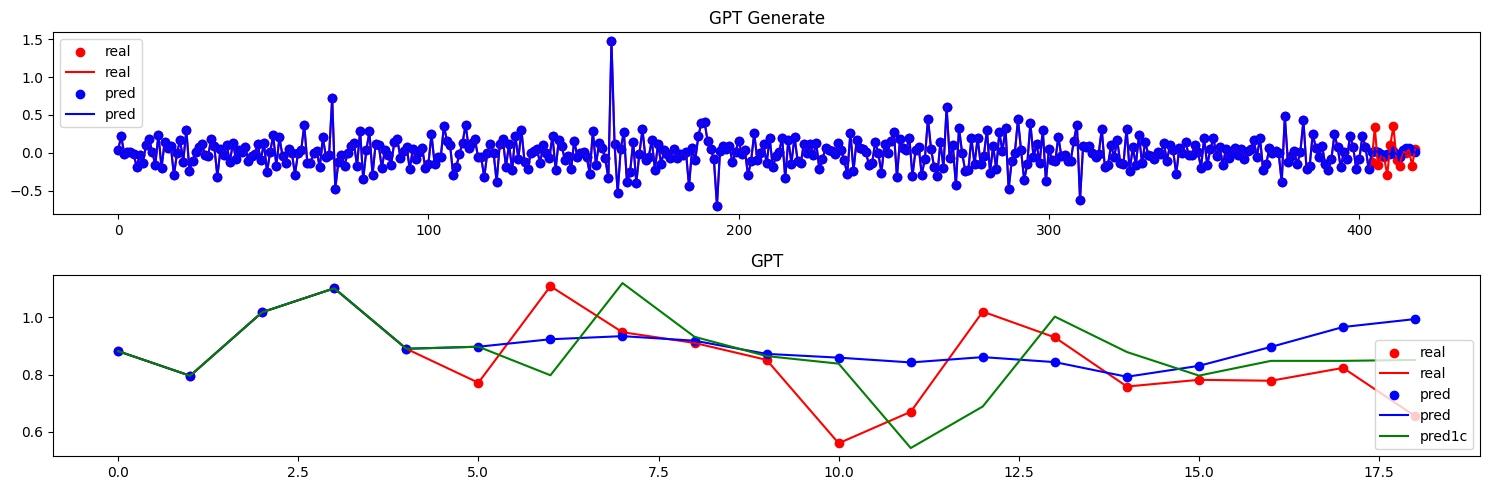

In [89]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 2


In [90]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ]  


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )





1383
800
1215
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  1.1844160556793213
500 train loss =  0.017664240673184395
1000 train loss =  0.008196285925805569
1500 train loss =  0.006224372889846563
2000 train loss =  0.004067903384566307
2500 train loss =  0.0033125870395451784


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


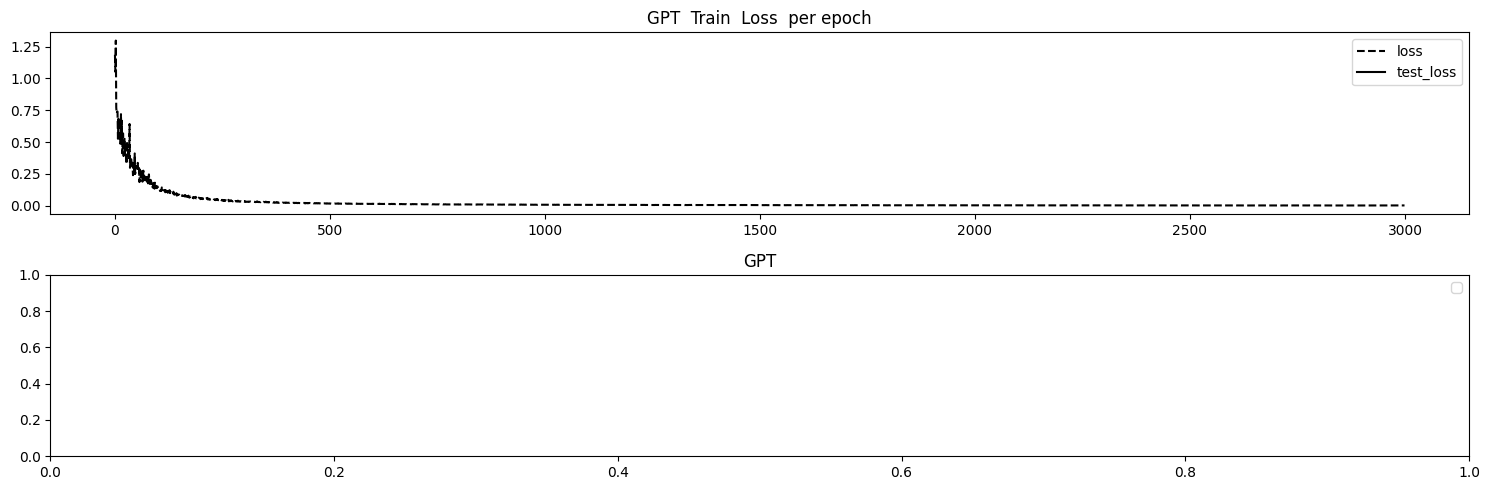

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.09495573490858078
Test MSE Loss - SI only 0-5:  0.3295385539531708
Test MSE Loss - SI only 5-10:  0.02872183918952942
Test MSE Loss - SI only 10-15:  0.034356072545051575
mae, mse, rmse, mape, mspe, rse, corr
(0.21792565, 0.09495573, 0.30814886, 1.3967297, 2.752016, 1.3388103)
Testing R**2 - SI only:  -0.7924127144705586
Testing R**2 - SI only:  -0.7924127144705586
Testing R**2 - All features:  0.991250193692779


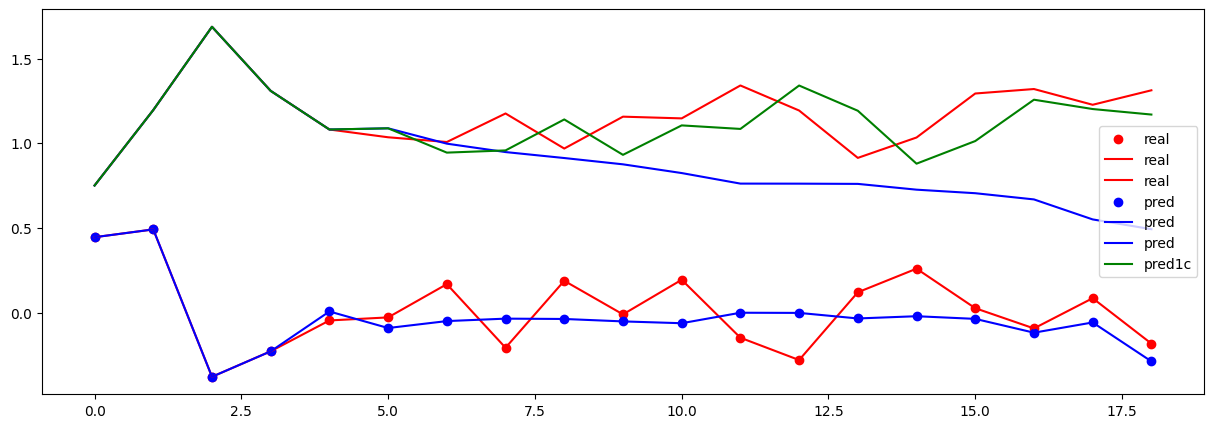

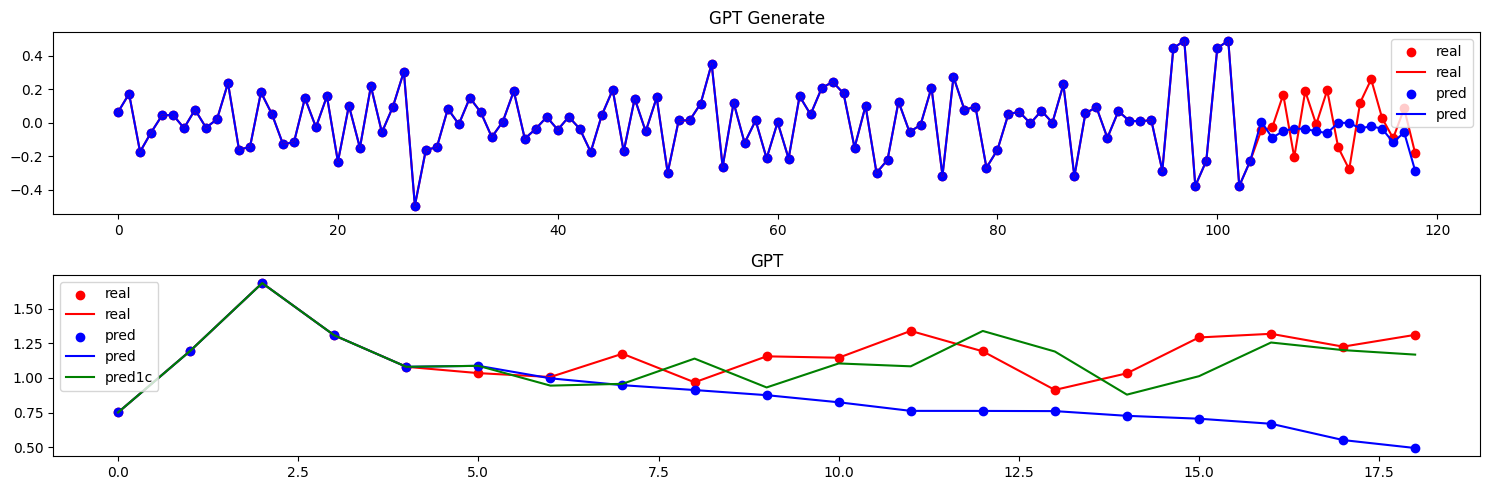

In [91]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 



torch.Size([200, 25])
0 train loss =  0.8594304919242859
500 train loss =  0.034436967223882675
1000 train loss =  0.013359971344470978
1500 train loss =  0.0070489551872015
2000 train loss =  0.005761236883699894
2500 train loss =  0.004526481032371521


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


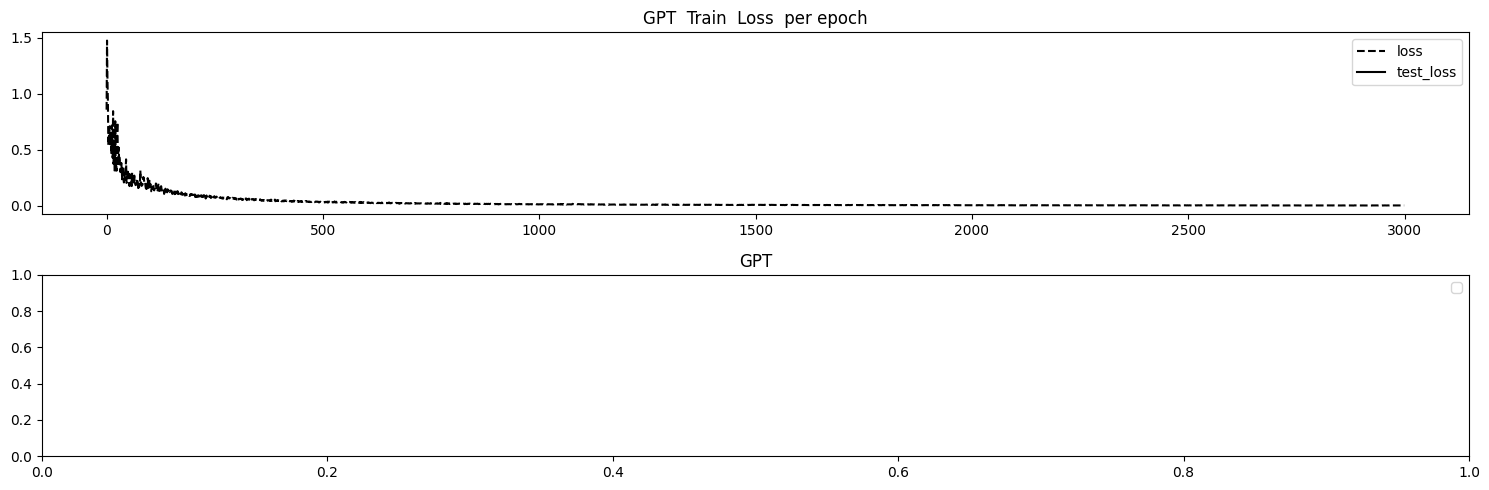

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.09428423643112183
Test MSE Loss - SI only 0-5:  0.3295385539531708
Test MSE Loss - SI only 5-10:  0.01608378067612648
Test MSE Loss - SI only 10-15:  0.03995959460735321
mae, mse, rmse, mape, mspe, rse, corr
(0.20844086, 0.09428423, 0.30705738, 1.3448192, 2.6588802, 1.334068)
Testing R**2 - SI only:  -0.7797371342416439
Testing R**2 - SI only:  -0.7797371342416439
Testing R**2 - All features:  0.9915467199947895


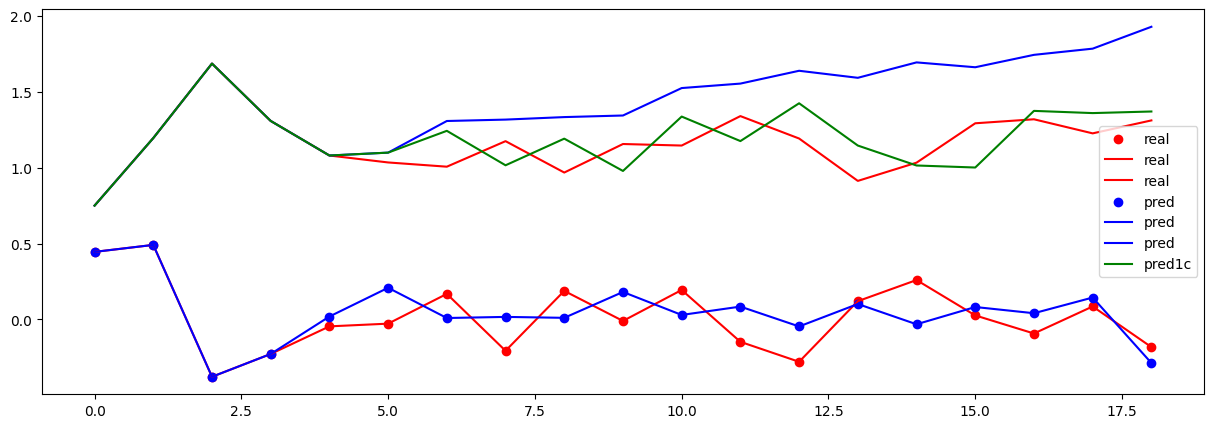

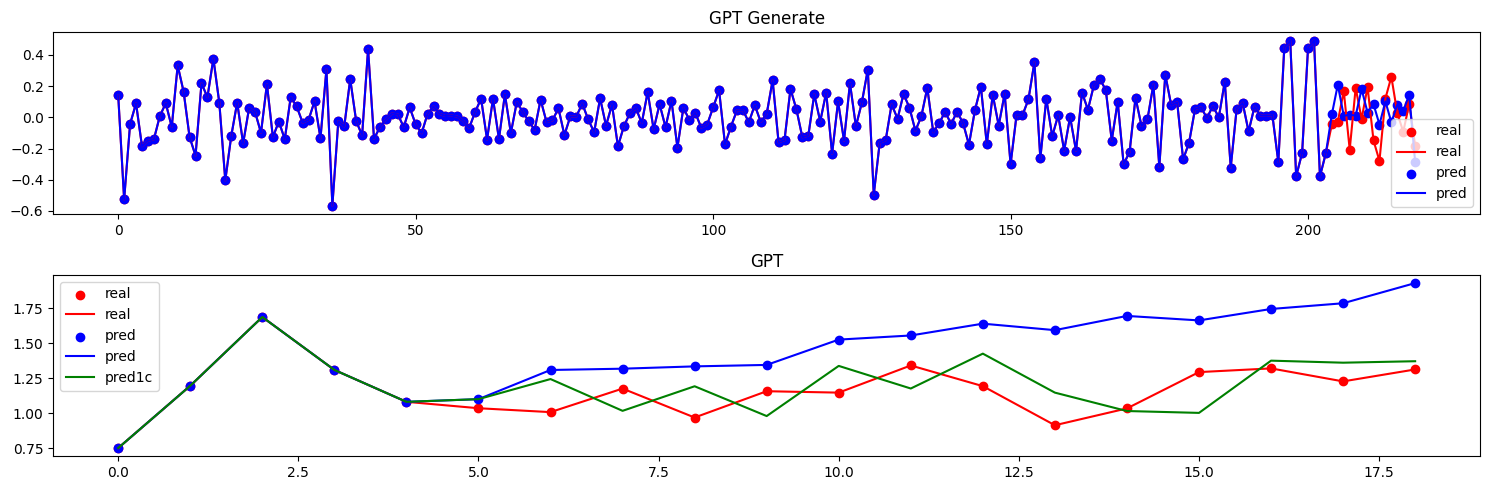

In [92]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 


torch.Size([300, 25])
0 train loss =  1.0433096885681152
500 train loss =  0.03638574853539467
1000 train loss =  0.01750899665057659
1500 train loss =  0.011852317489683628
2000 train loss =  0.00743809575214982
2500 train loss =  0.006352732423692942


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


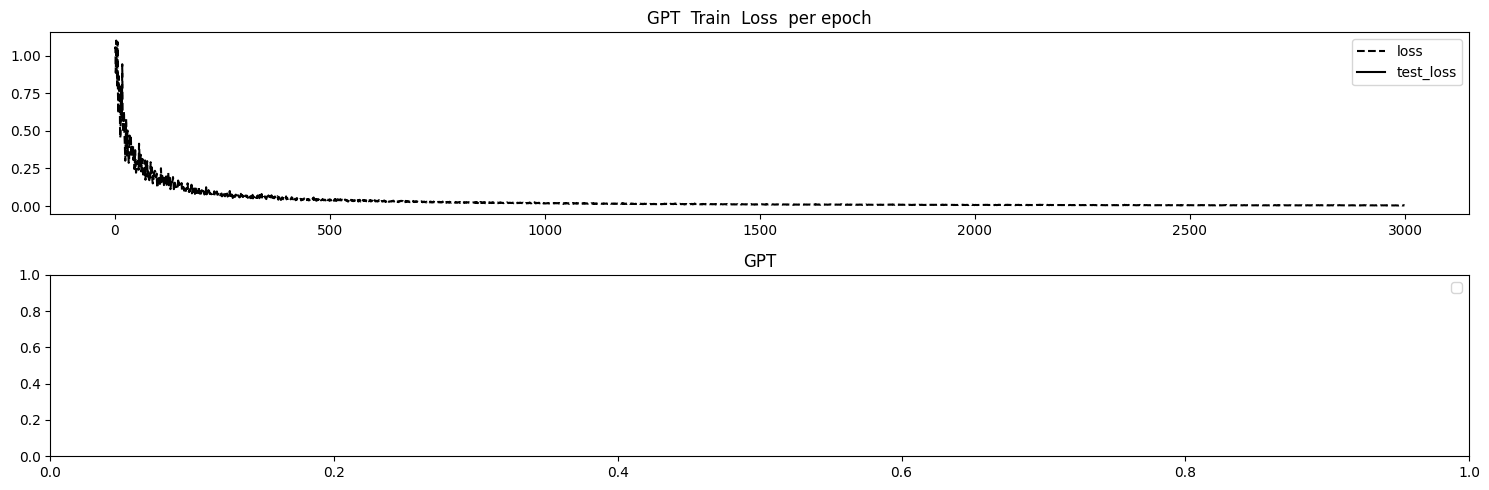

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.09394388645887375
Test MSE Loss - SI only 0-5:  0.3295385539531708
Test MSE Loss - SI only 5-10:  0.0277553740888834
Test MSE Loss - SI only 10-15:  0.03275689482688904
mae, mse, rmse, mape, mspe, rse, corr
(0.2170068, 0.093943894, 0.30650267, 1.3666496, 2.5725164, 1.3316579)
Testing R**2 - SI only:  -0.7733129168619339
Testing R**2 - SI only:  -0.7733129168619339
Testing R**2 - All features:  0.9900633767501742


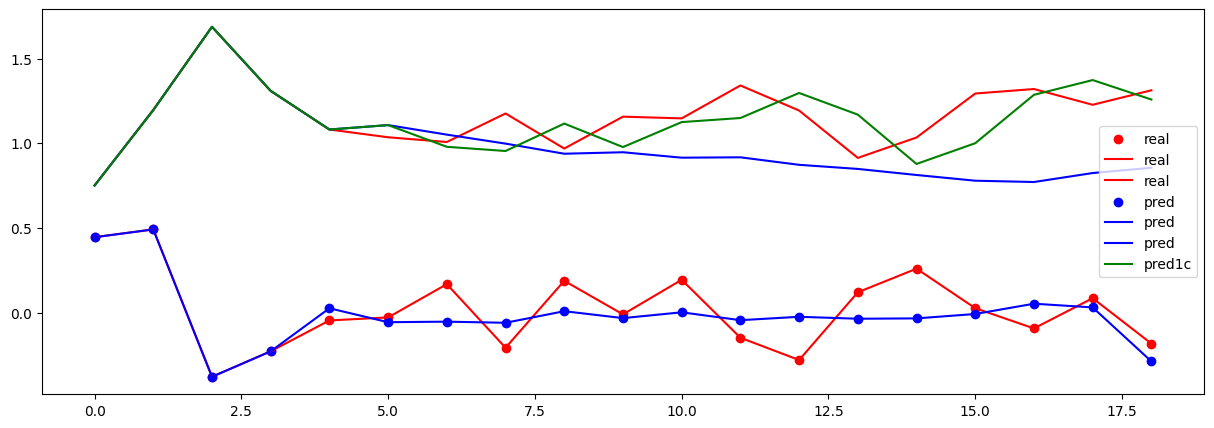

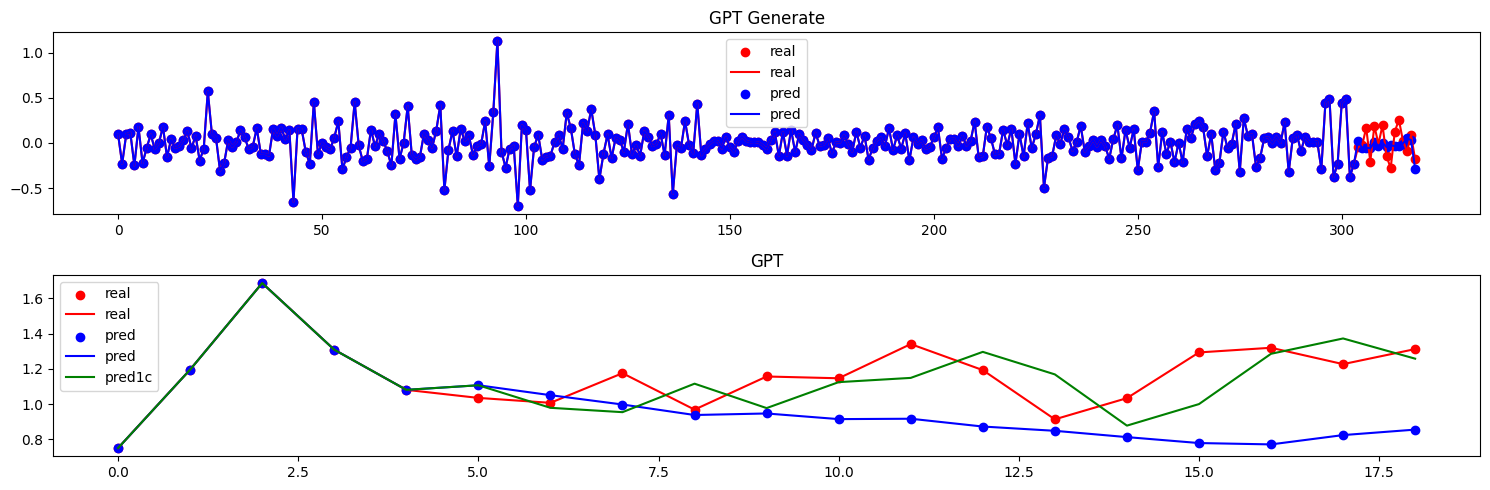

In [93]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 


torch.Size([400, 25])
0 train loss =  1.5759371519088745
500 train loss =  0.04742778465151787
1000 train loss =  0.02646779827773571
1500 train loss =  0.012331819161772728
2000 train loss =  0.010652034543454647
2500 train loss =  0.006927608512341976


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


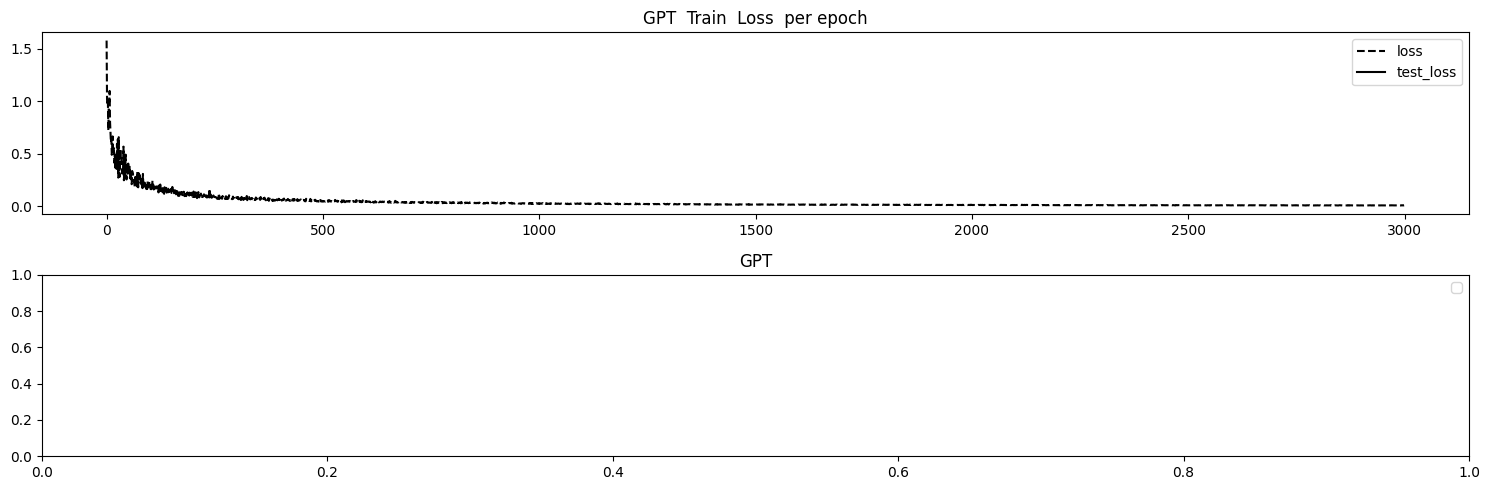

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.08767975121736526
Test MSE Loss - SI only 0-5:  0.3295385539531708
Test MSE Loss - SI only 5-10:  0.015112951397895813
Test MSE Loss - SI only 10-15:  0.026556143537163734
mae, mse, rmse, mape, mspe, rse, corr
(0.19849895, 0.08767975, 0.29610768, 1.2132906, 2.519276, 1.286495)
Testing R**2 - SI only:  -0.6550690001558628
Testing R**2 - SI only:  -0.6550690001558628
Testing R**2 - All features:  0.9841158712825172


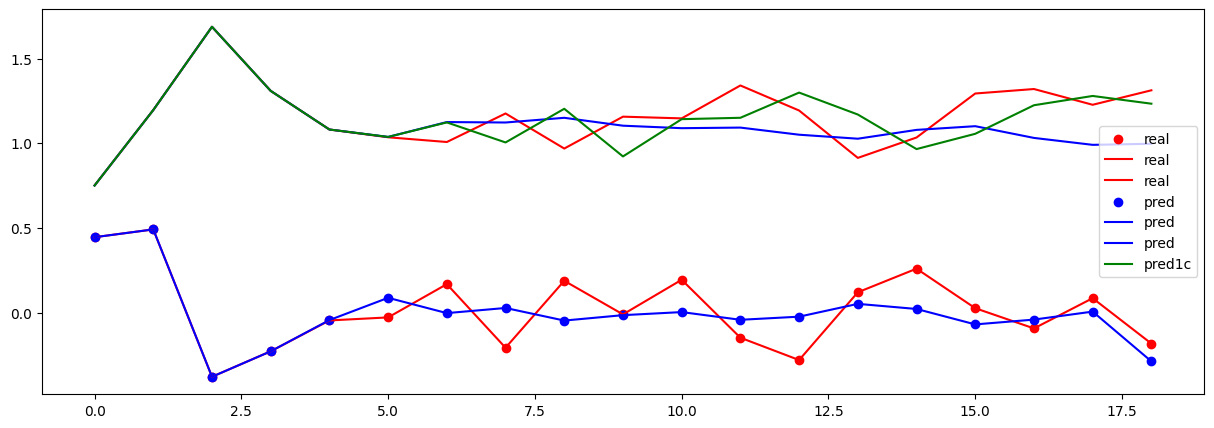

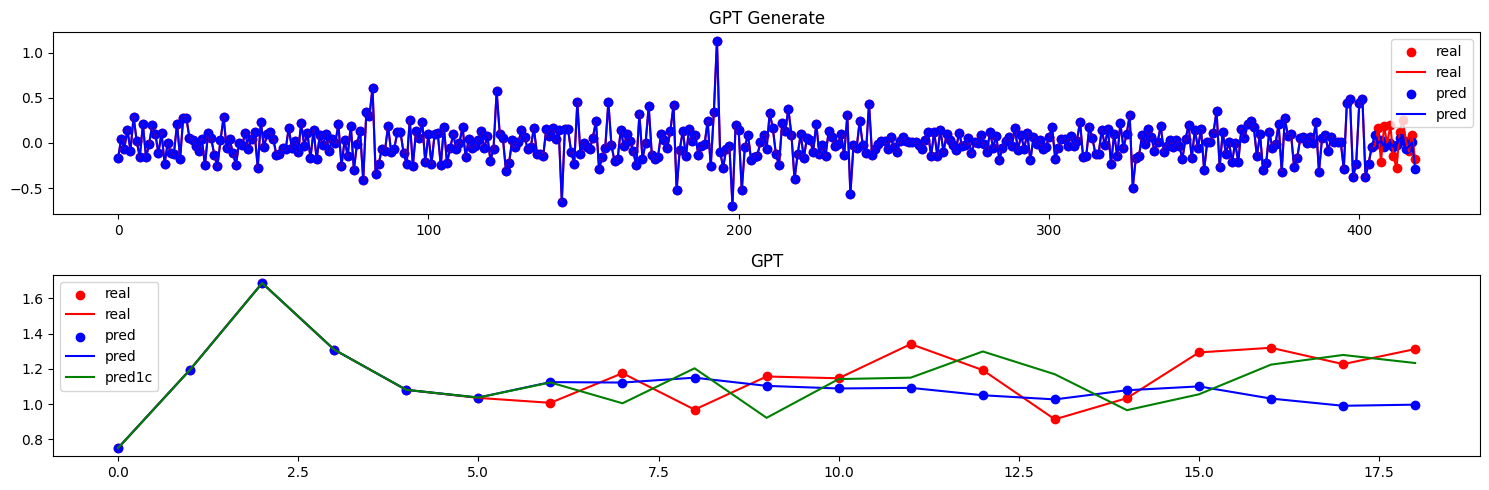

In [94]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 3


In [95]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )



1383
427
842
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  1.255984902381897
500 train loss =  0.01714479550719261
1000 train loss =  0.008805587887763977
1500 train loss =  0.0055216336622834206
2000 train loss =  0.004016881808638573
2500 train loss =  0.003039330244064331


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


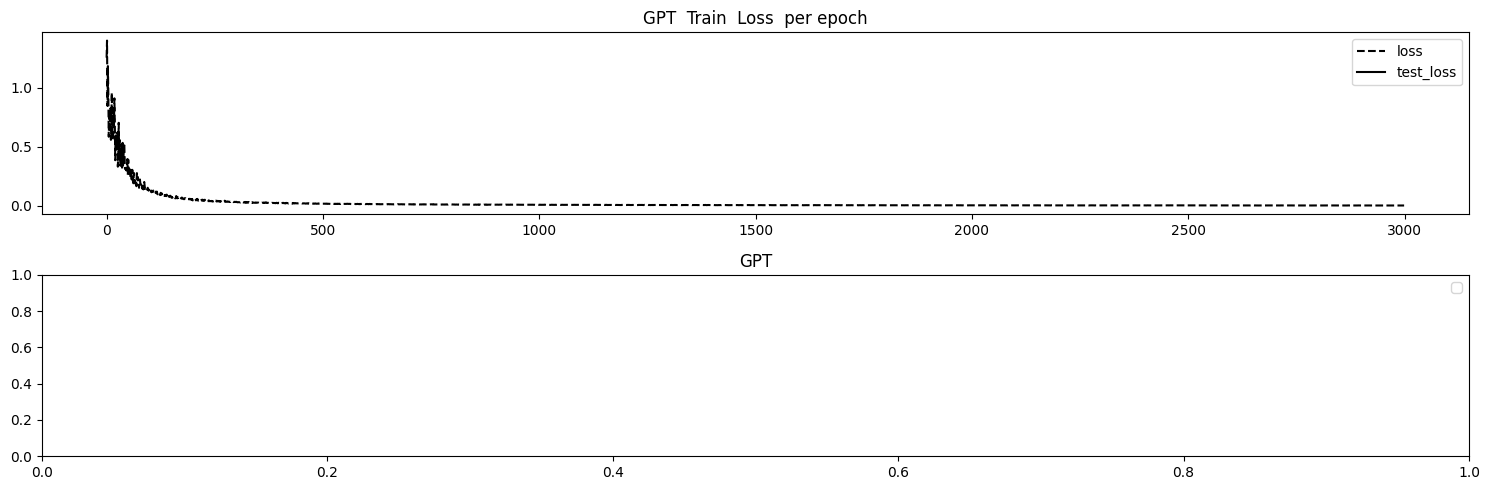

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.027891283854842186
Test MSE Loss - SI only 0-5:  0.01509236078709364
Test MSE Loss - SI only 5-10:  0.024490702897310257
Test MSE Loss - SI only 10-15:  0.03668561950325966
mae, mse, rmse, mape, mspe, rse, corr
(0.1334274, 0.027891284, 0.16700684, 2.136478, 11.082407, 1.2563773)
Testing R**2 - SI only:  -0.578484246217047
Testing R**2 - SI only:  -0.578484246217047
Testing R**2 - All features:  0.9781008421757713


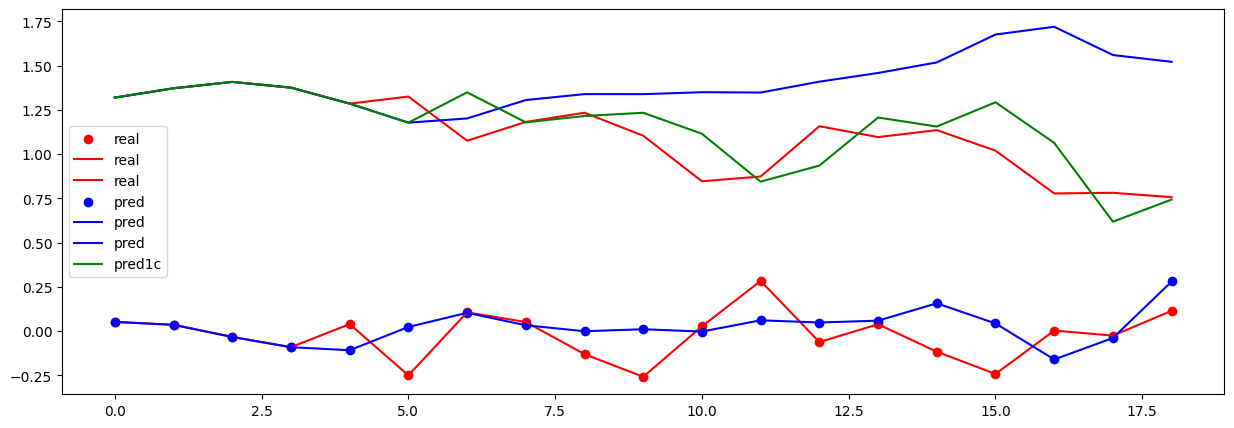

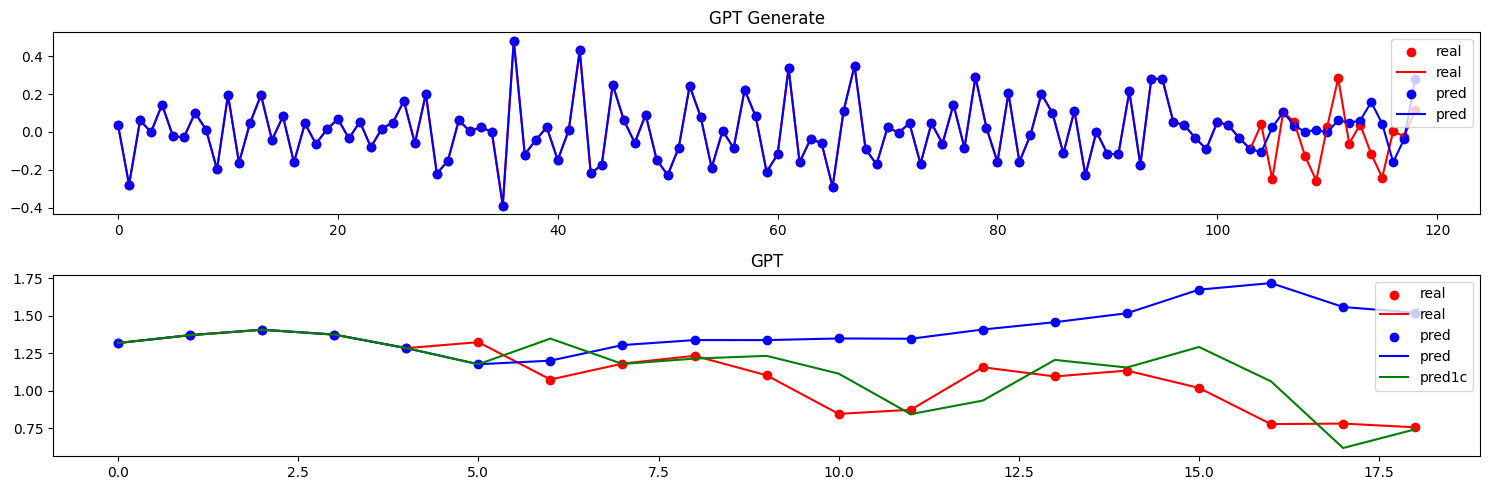

In [96]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([200, 25])
0 train loss =  0.9383434057235718
500 train loss =  0.025940699502825737
1000 train loss =  0.01348758302628994
1500 train loss =  0.00852367002516985
2000 train loss =  0.005970514379441738
2500 train loss =  0.004711697809398174


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


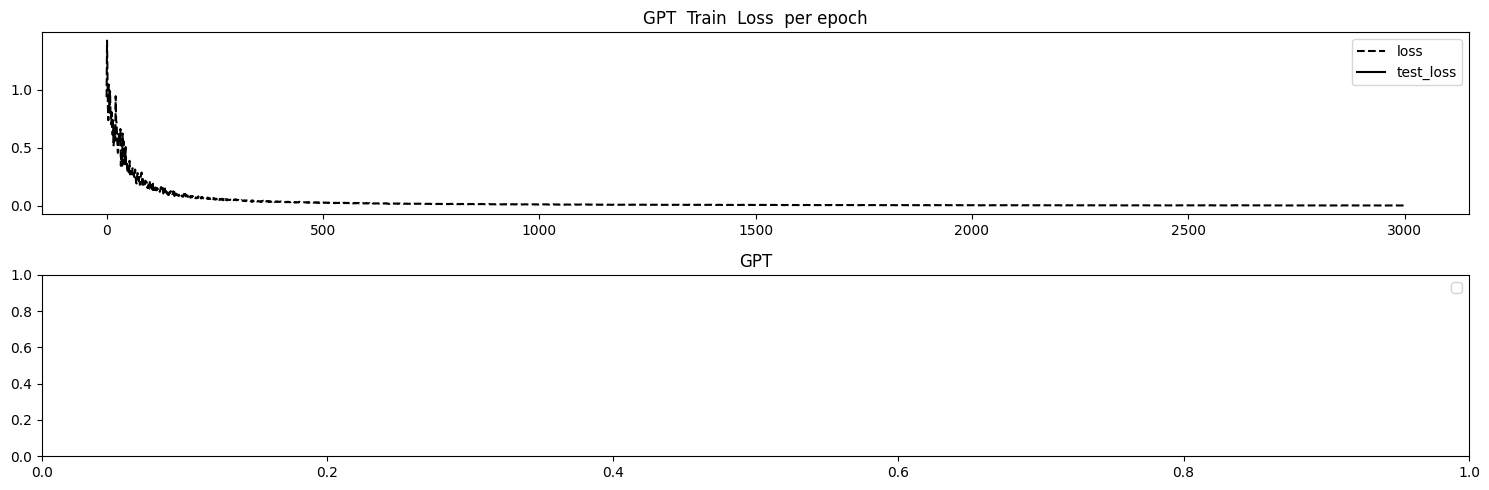

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.020297834649682045
Test MSE Loss - SI only 0-5:  0.01509236078709364
Test MSE Loss - SI only 5-10:  0.026589810848236084
Test MSE Loss - SI only 10-15:  0.019488824531435966
mae, mse, rmse, mape, mspe, rse, corr
(0.11242494, 0.020297837, 0.14247048, 1.5910723, 5.589682, 1.0717925)
Testing R**2 - SI only:  -0.14873918952062537
Testing R**2 - SI only:  -0.14873918952062537
Testing R**2 - All features:  0.9781138487219743


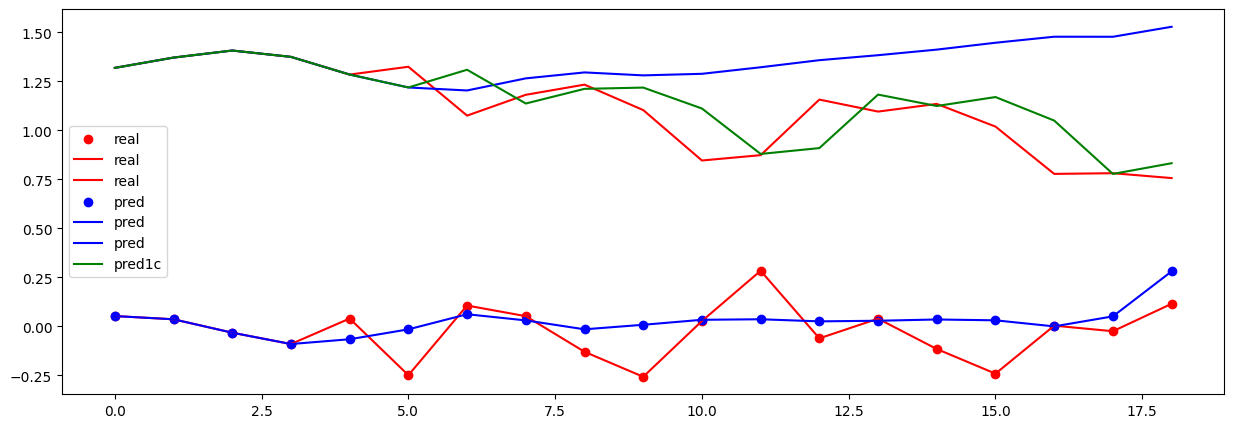

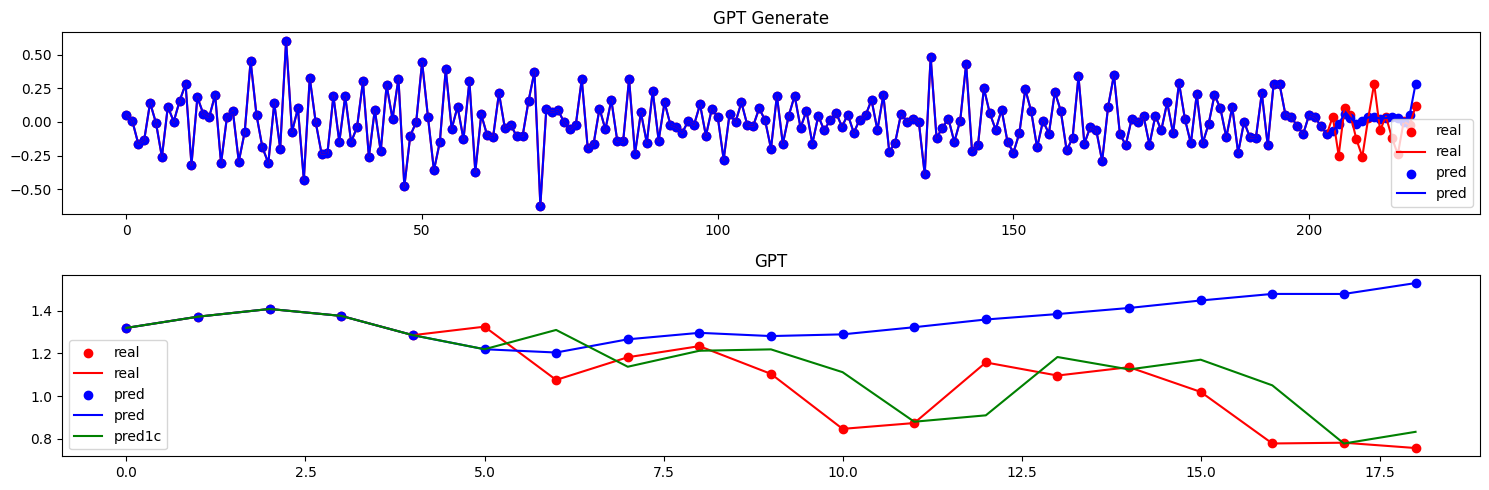

In [97]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 



torch.Size([300, 25])
0 train loss =  1.1360887289047241
500 train loss =  0.043205566704273224
1000 train loss =  0.020181937143206596
1500 train loss =  0.011121273040771484
2000 train loss =  0.007500431500375271
2500 train loss =  0.006080723833292723


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


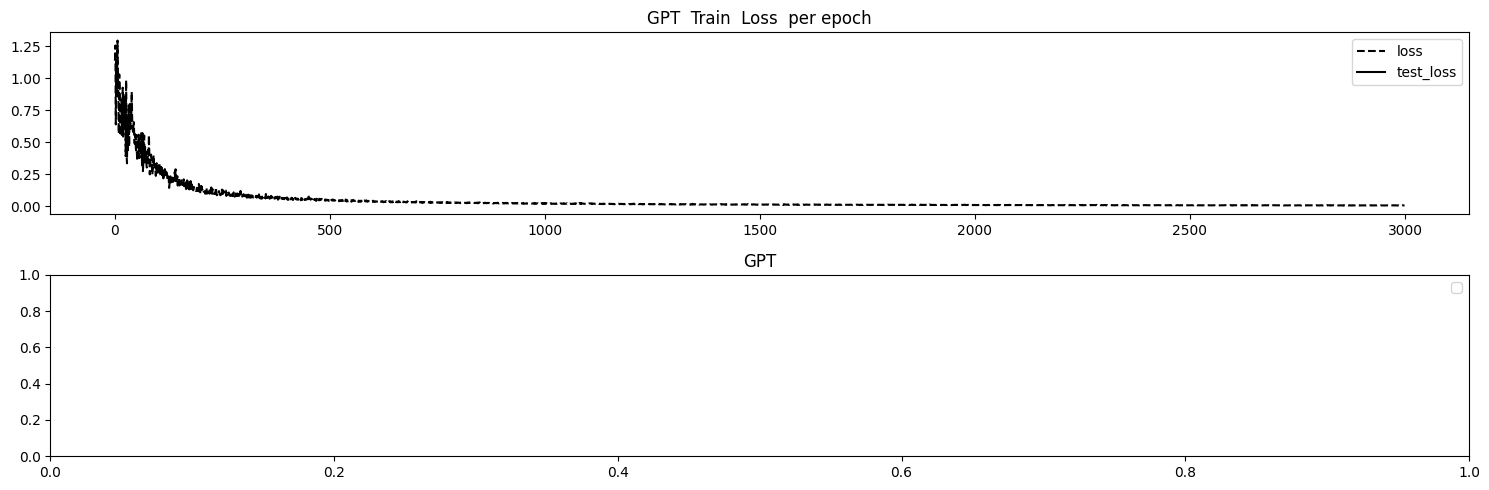

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.023592954501509666
Test MSE Loss - SI only 0-5:  0.01509236078709364
Test MSE Loss - SI only 5-10:  0.03434019535779953
Test MSE Loss - SI only 10-15:  0.0221394170075655
mae, mse, rmse, mape, mspe, rse, corr
(0.12565178, 0.023592955, 0.15359998, 2.0815973, 13.862128, 1.1555188)
Testing R**2 - SI only:  -0.335223716006672
Testing R**2 - SI only:  -0.335223716006672
Testing R**2 - All features:  0.9881803908406104


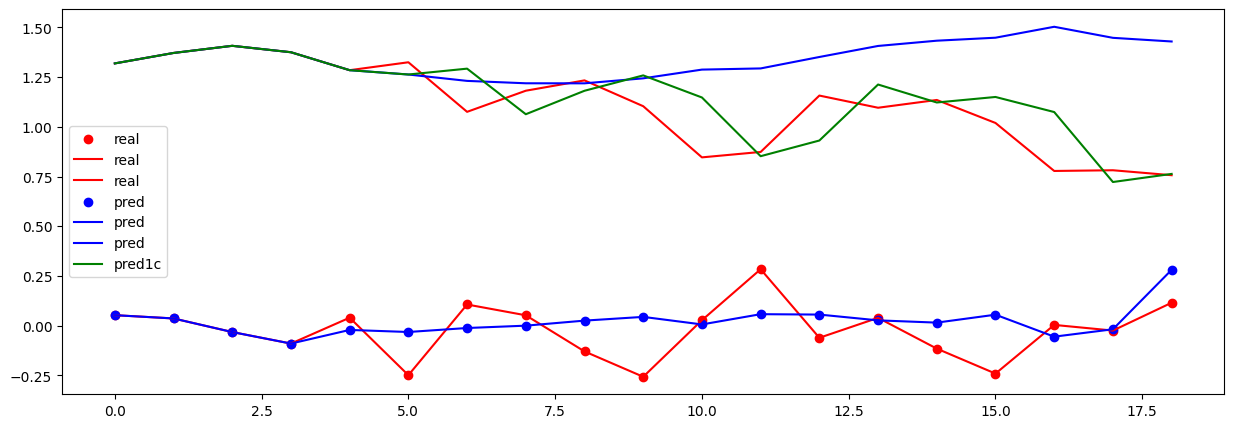

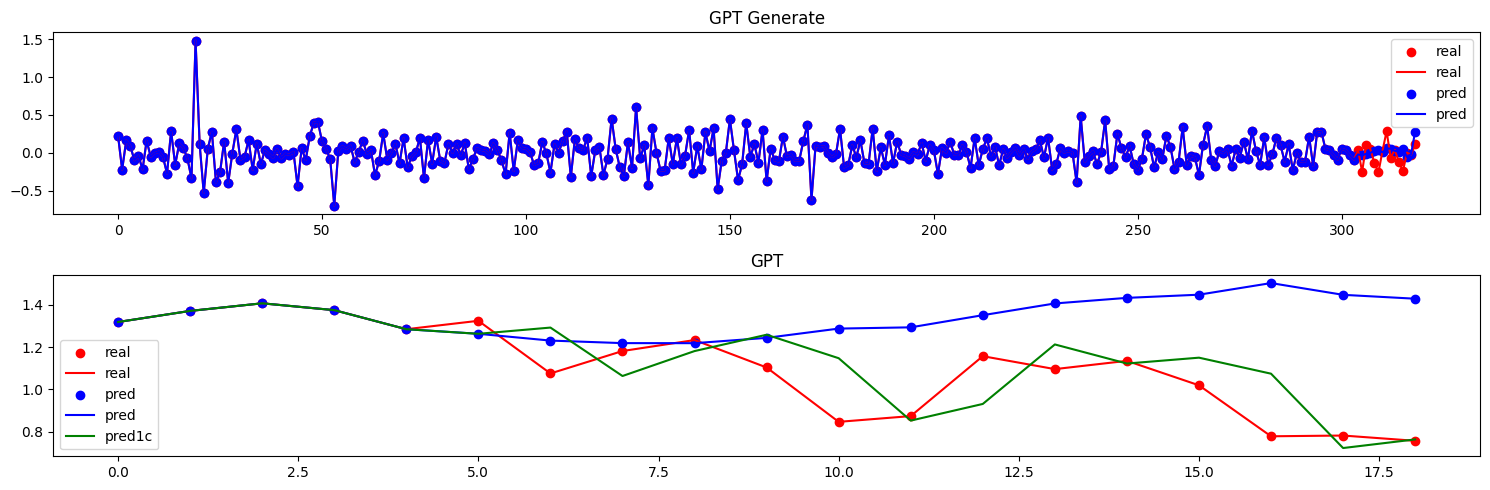

In [98]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string  = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([400, 25])
0 train loss =  1.450861930847168
500 train loss =  0.07427667826414108
1000 train loss =  0.028961190953850746
1500 train loss =  0.01802092231810093
2000 train loss =  0.011329644359648228
2500 train loss =  0.008323553949594498


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


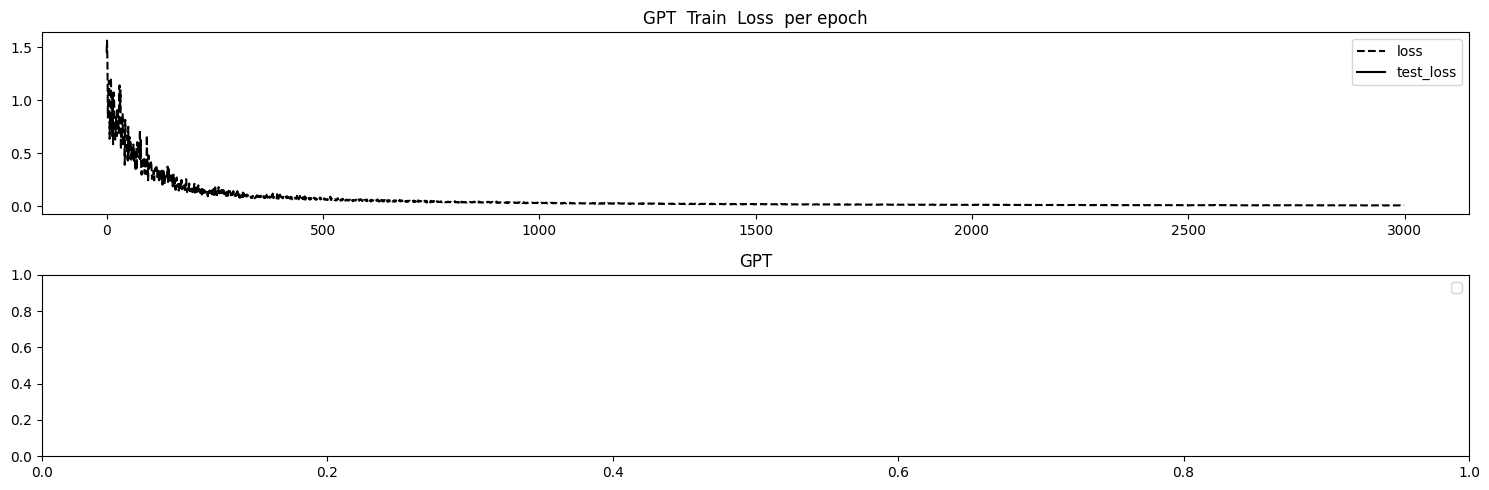

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.019990159198641777
Test MSE Loss - SI only 0-5:  0.01509236078709364
Test MSE Loss - SI only 5-10:  0.03603680804371834
Test MSE Loss - SI only 10-15:  0.013590949587523937
mae, mse, rmse, mape, mspe, rse, corr
(0.117095456, 0.019990157, 0.14138655, 2.9818223, 58.684277, 1.0636382)
Testing R**2 - SI only:  -0.13132645048112357
Testing R**2 - SI only:  -0.13132645048112357
Testing R**2 - All features:  0.9842201959735979


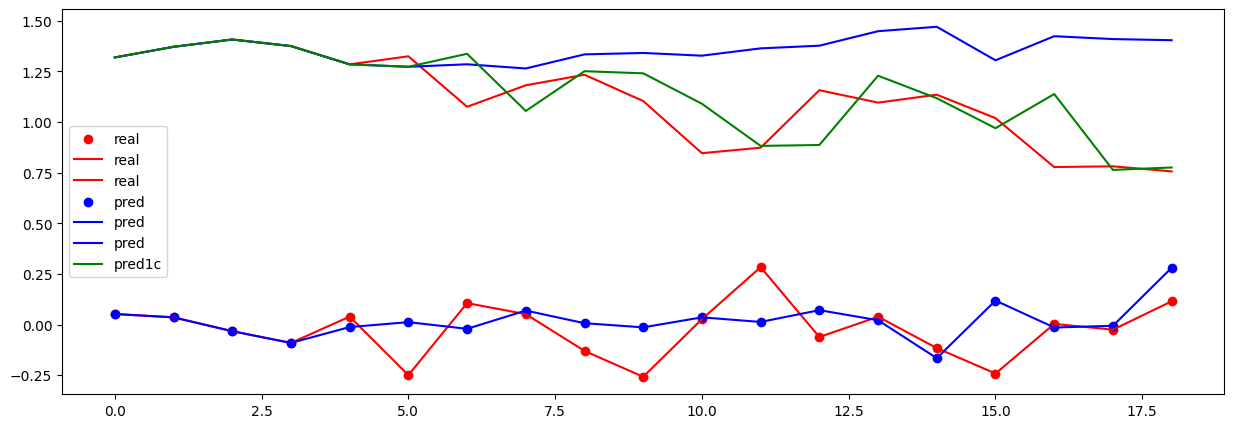

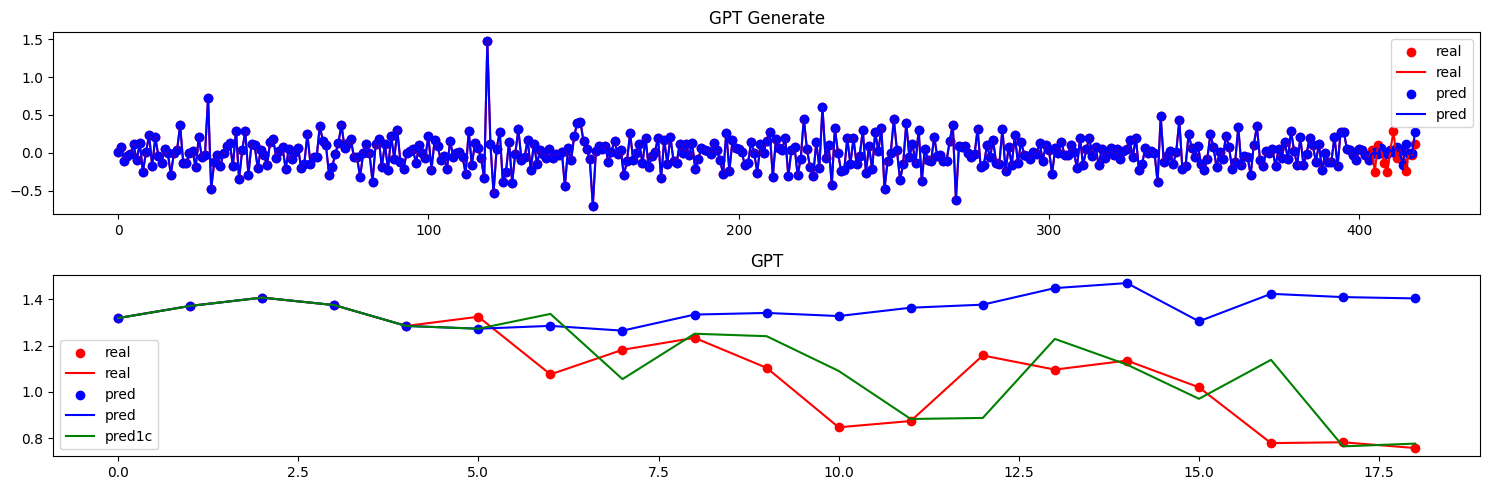

In [99]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 4


In [100]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


1383
107
522
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  1.2581453323364258
500 train loss =  0.01936059258878231
1000 train loss =  0.00868866965174675
1500 train loss =  0.00555080734193325
2000 train loss =  0.004229461774230003
2500 train loss =  0.003056731540709734


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


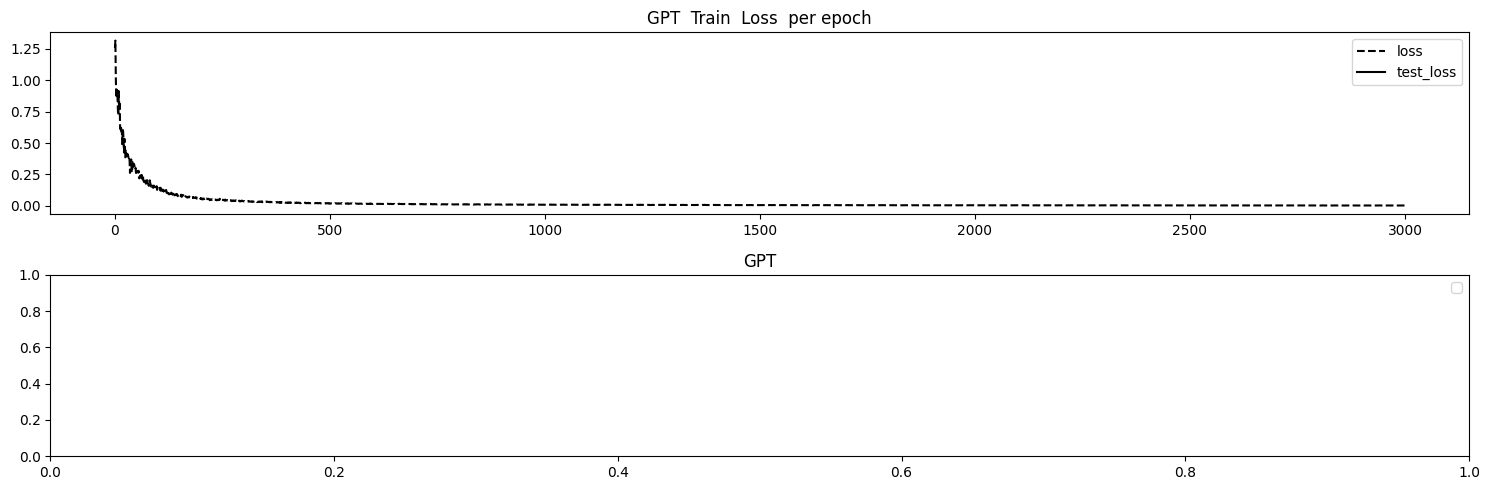

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.04467891529202461
Test MSE Loss - SI only 0-5:  0.05751989781856537
Test MSE Loss - SI only 5-10:  0.04714832827448845
Test MSE Loss - SI only 10-15:  0.04084528982639313
mae, mse, rmse, mape, mspe, rse, corr
(0.18231249, 0.044678915, 0.21137388, 18.7915, 2969.9934, 1.1827571)
Testing R**2 - SI only:  -0.3989145802967238
Testing R**2 - SI only:  -0.3989145802967238
Testing R**2 - All features:  0.8848626499466961


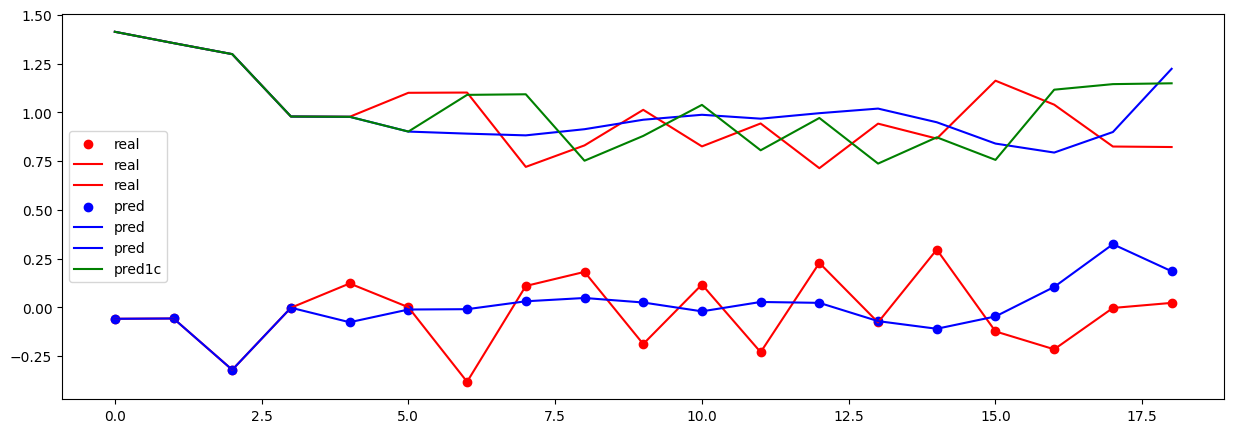

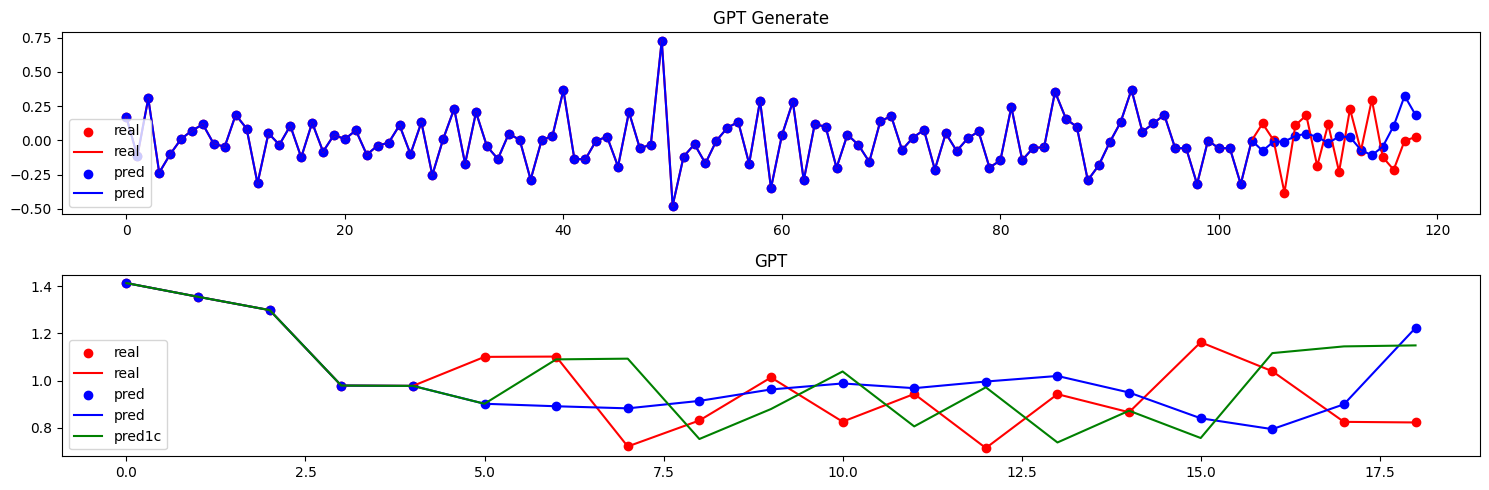

In [101]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([200, 25])
0 train loss =  1.5787767171859741
500 train loss =  0.03583177551627159
1000 train loss =  0.015136593021452427
1500 train loss =  0.009582734666764736
2000 train loss =  0.006038954481482506
2500 train loss =  0.004262079950422049


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


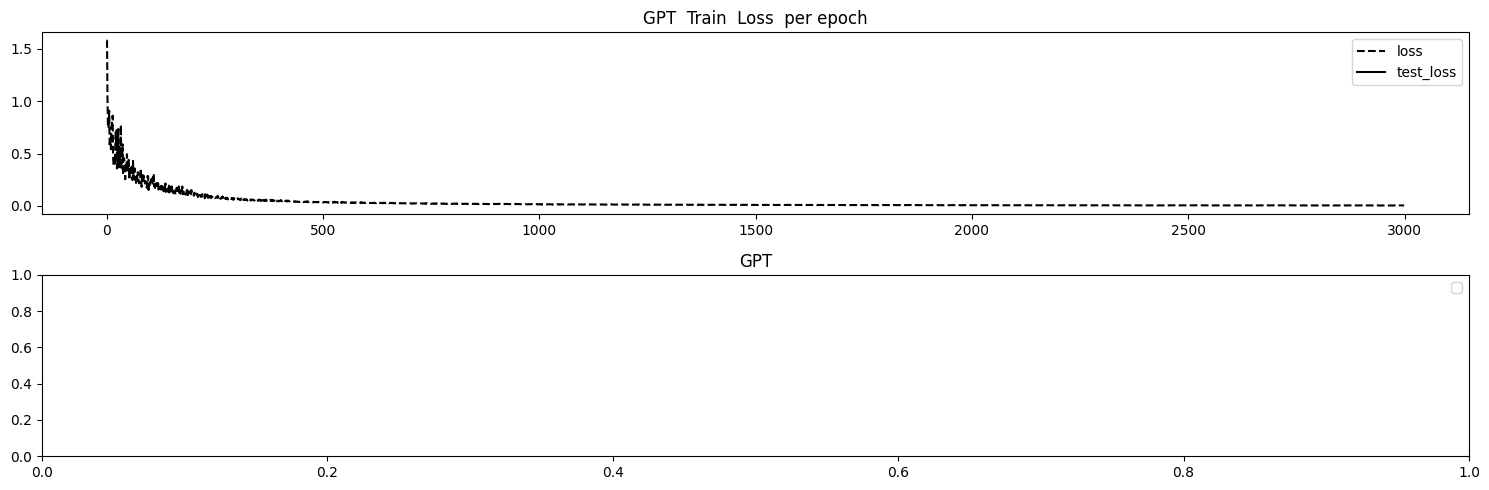

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.03840261697769165
Test MSE Loss - SI only 0-5:  0.05751989781856537
Test MSE Loss - SI only 5-10:  0.043105218559503555
Test MSE Loss - SI only 10-15:  0.02984149567782879
mae, mse, rmse, mape, mspe, rse, corr
(0.16669267, 0.038402617, 0.19596586, 17.356304, 2997.642, 1.0965405)
Testing R**2 - SI only:  -0.2024011627094462
Testing R**2 - SI only:  -0.2024011627094462
Testing R**2 - All features:  0.9201109661765204


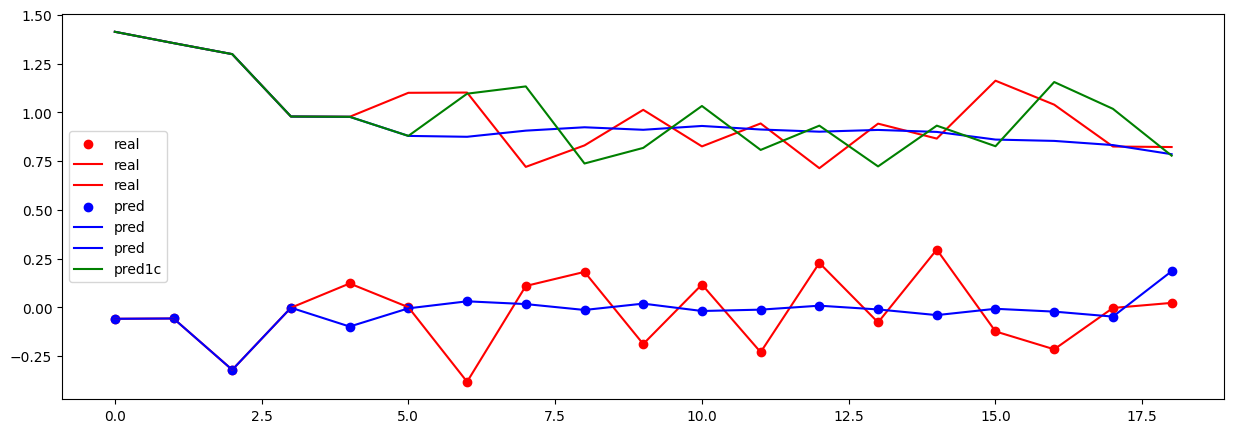

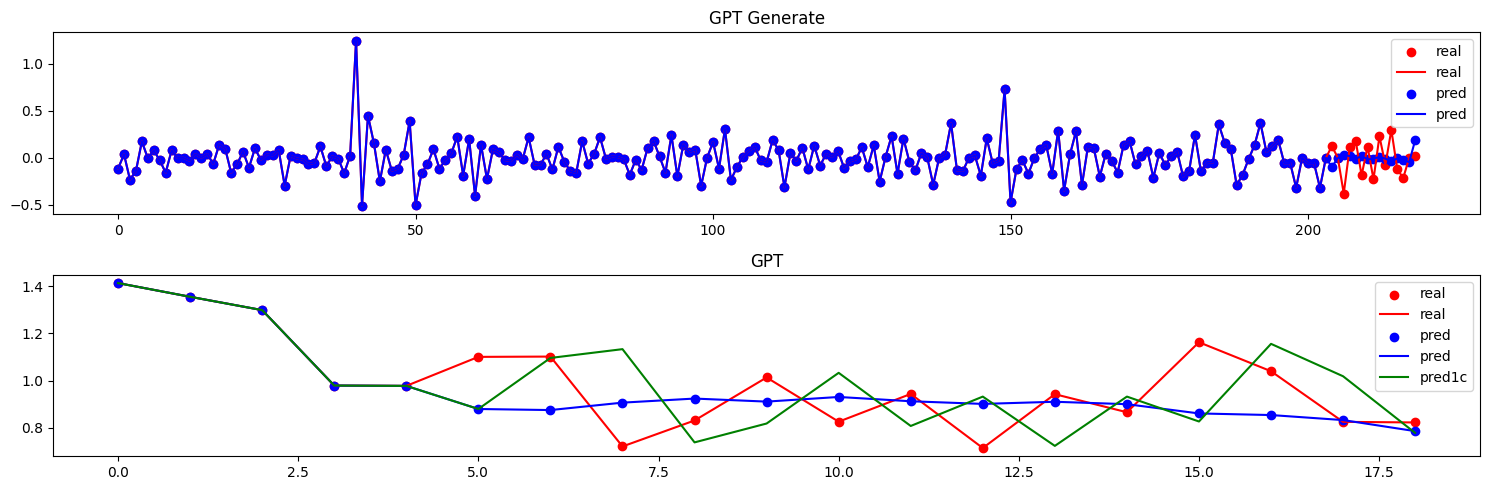

In [102]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([300, 25])
0 train loss =  1.1231694221496582
500 train loss =  0.043087996542453766
1000 train loss =  0.023617954924702644
1500 train loss =  0.01325058564543724
2000 train loss =  0.008443755097687244
2500 train loss =  0.006283627822995186


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


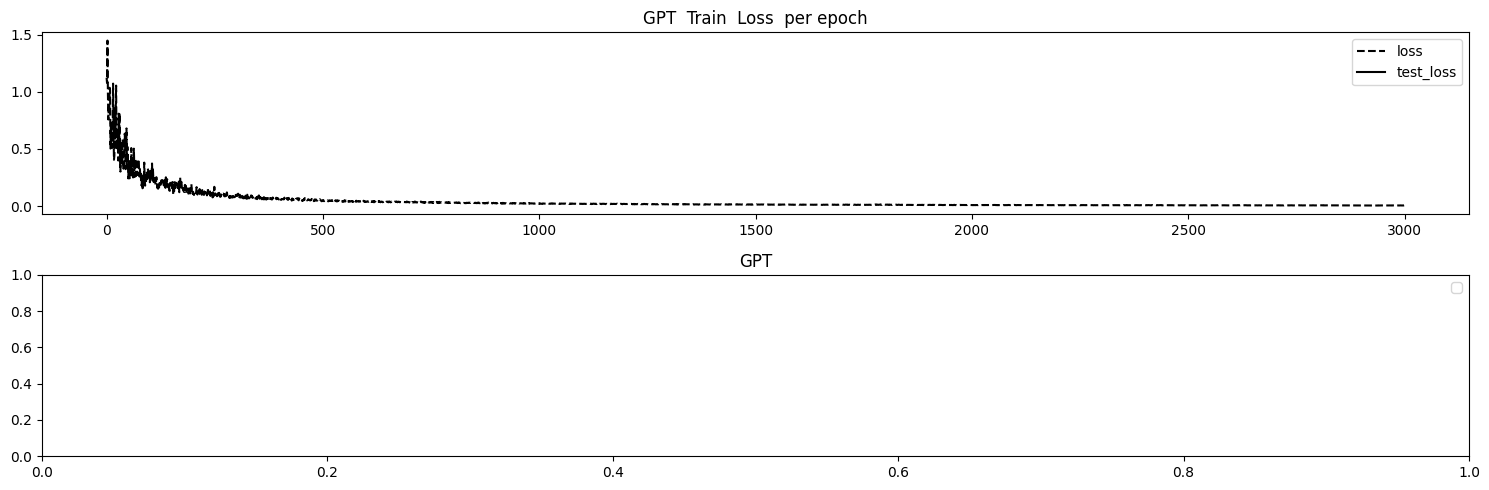

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.038216158747673035
Test MSE Loss - SI only 0-5:  0.05751989781856537
Test MSE Loss - SI only 5-10:  0.046385396271944046
Test MSE Loss - SI only 10-15:  0.027625536546111107
mae, mse, rmse, mape, mspe, rse, corr
(0.16133018, 0.038216155, 0.19548953, 13.717398, 2687.6777, 1.0938752)
Testing R**2 - SI only:  -0.1965630305439754
Testing R**2 - SI only:  -0.1965630305439754
Testing R**2 - All features:  0.9723245024155879


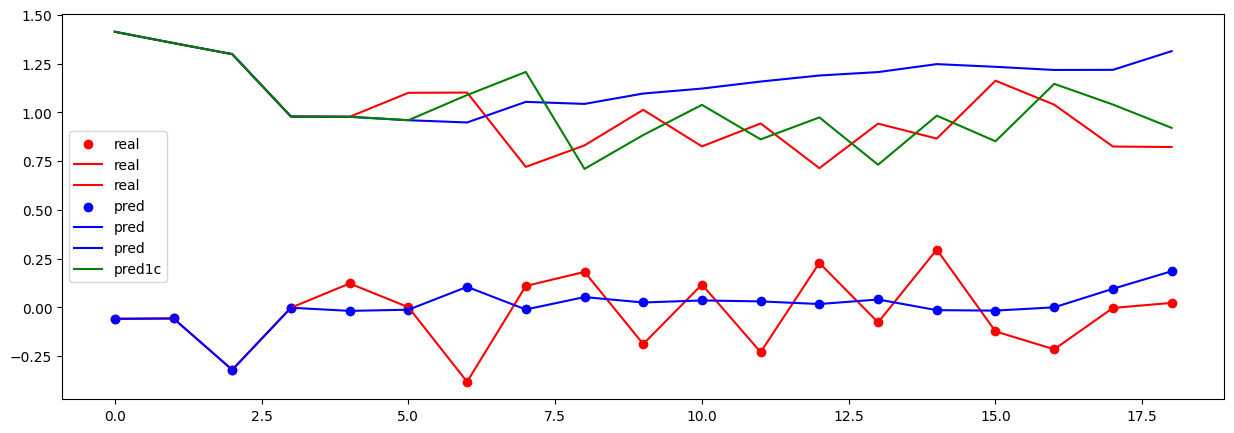

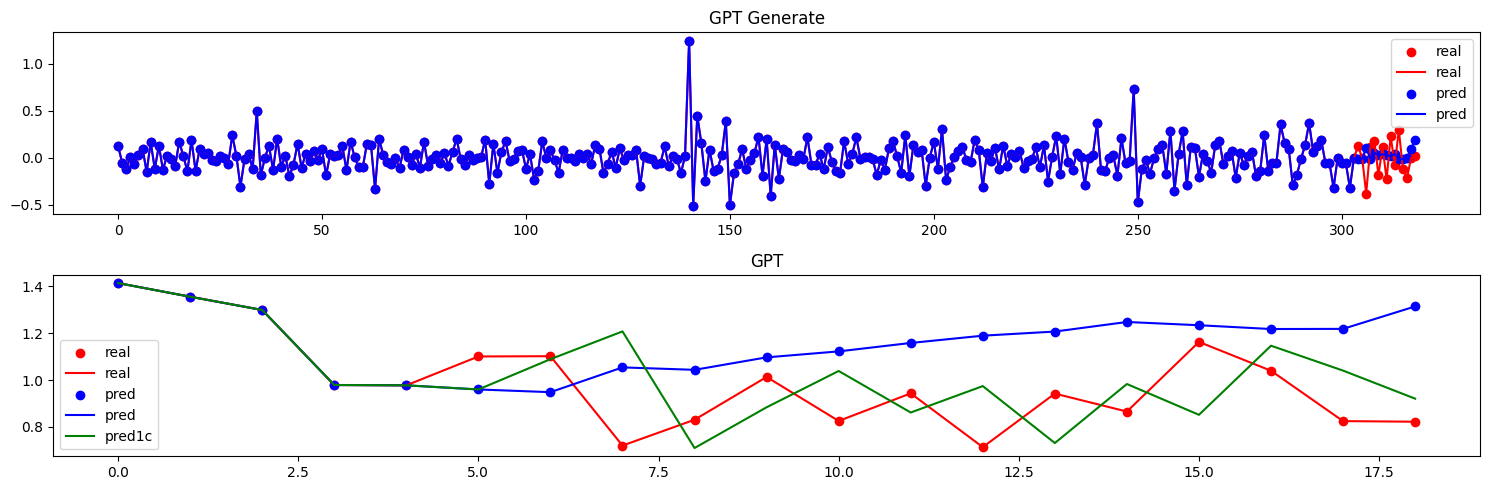

In [103]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([400, 25])
0 train loss =  1.1598681211471558
500 train loss =  0.0603276863694191
1000 train loss =  0.022529764100909233
1500 train loss =  0.01392326969653368
2000 train loss =  0.009067807346582413
2500 train loss =  0.006855279207229614


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


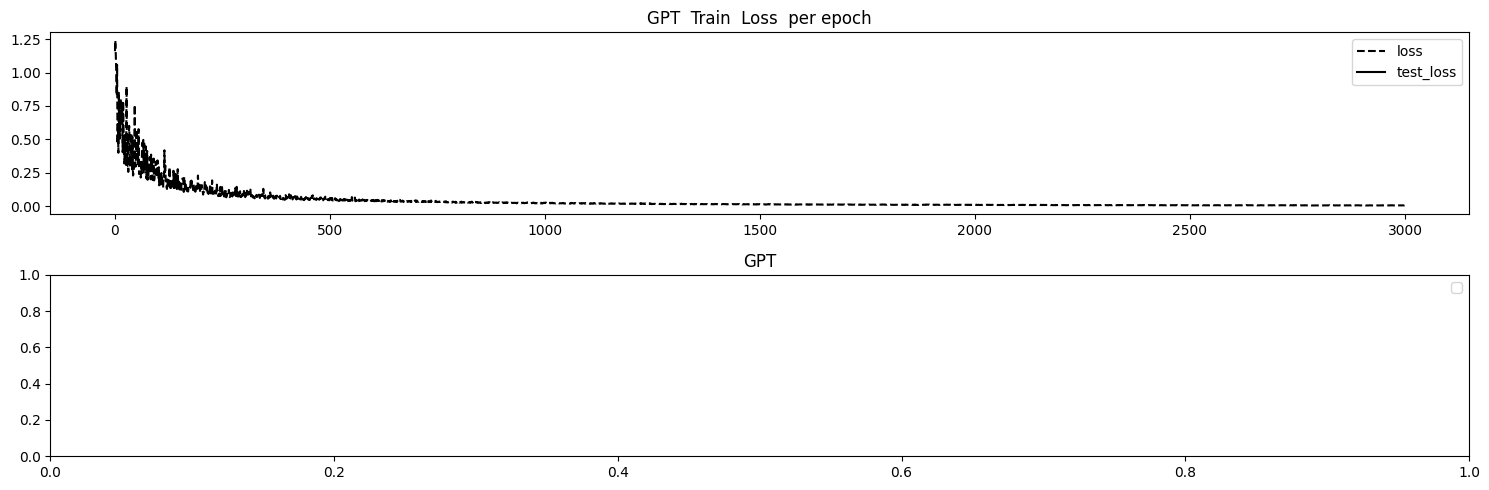

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.037964530289173126
Test MSE Loss - SI only 0-5:  0.05751989409327507
Test MSE Loss - SI only 5-10:  0.047368504106998444
Test MSE Loss - SI only 10-15:  0.026548156514763832
mae, mse, rmse, mape, mspe, rse, corr
(0.15954803, 0.03796453, 0.19484489, 14.865903, 2747.4556, 1.090268)
Testing R**2 - SI only:  -0.18868448254002623
Testing R**2 - SI only:  -0.18868448254002623
Testing R**2 - All features:  0.8622354515238875


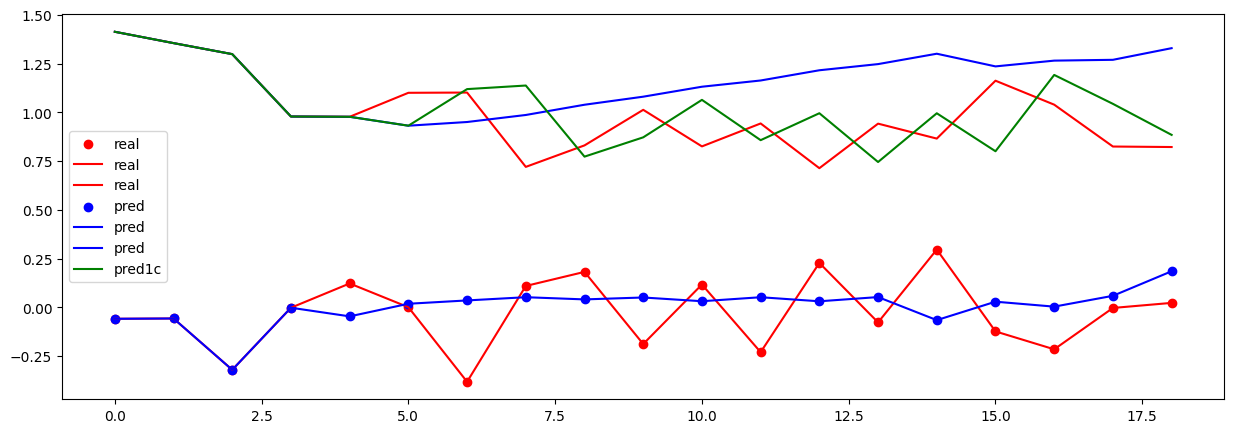

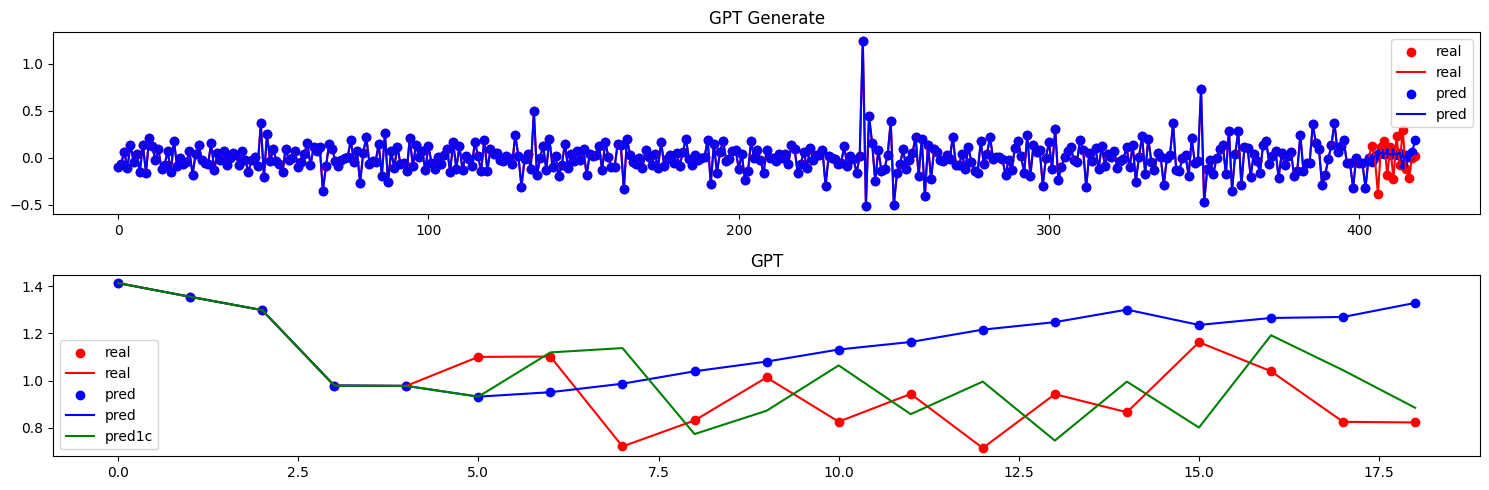

In [104]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 



## Run 5


In [105]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


1383
645
1060
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  1.1684173345565796
500 train loss =  0.016003809869289398
1000 train loss =  0.007994350045919418
1500 train loss =  0.005410788580775261
2000 train loss =  0.00399502320215106
2500 train loss =  0.0027938124258071184


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


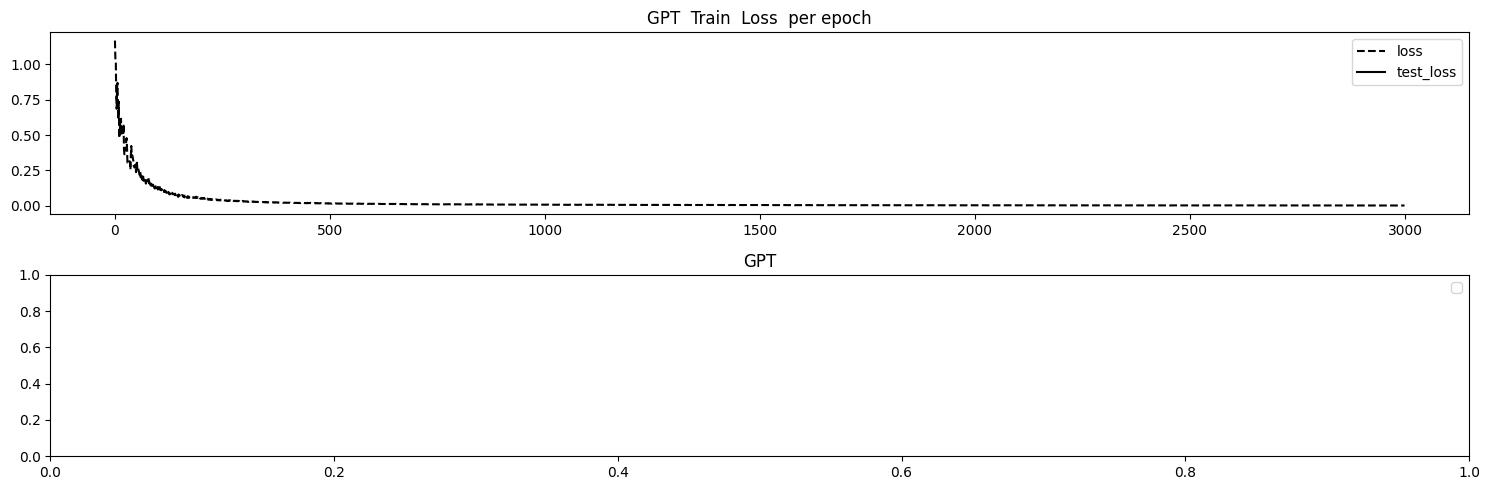

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.04089011996984482
Test MSE Loss - SI only 0-5:  0.16149909794330597
Test MSE Loss - SI only 5-10:  0.00930227804929018
Test MSE Loss - SI only 10-15:  0.009089547209441662
mae, mse, rmse, mape, mspe, rse, corr
(0.13082369, 0.040890124, 0.20221306, 3.558575, 36.411953, 1.7323995)
Testing R**2 - SI only:  -2.0012078987925768
Testing R**2 - SI only:  -2.0012078987925768
Testing R**2 - All features:  0.9923973525612971


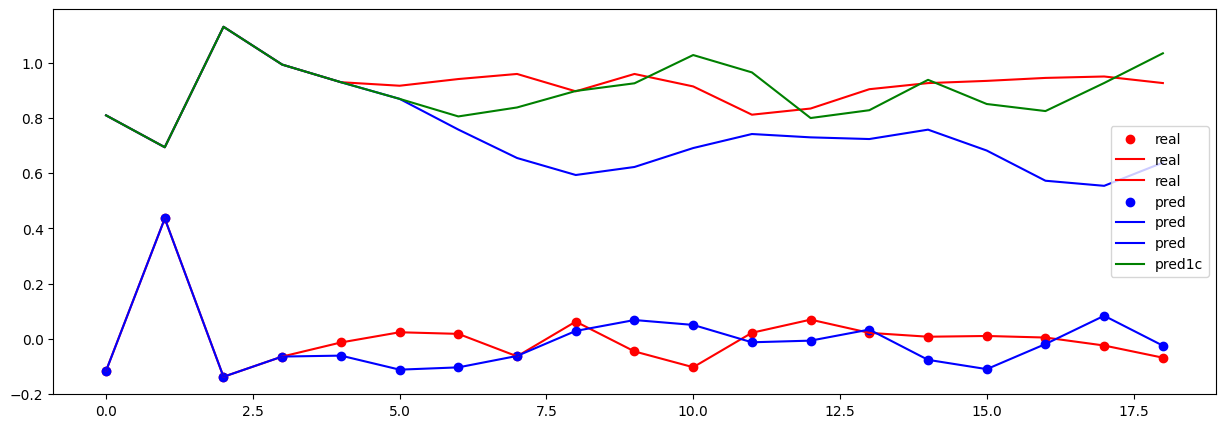

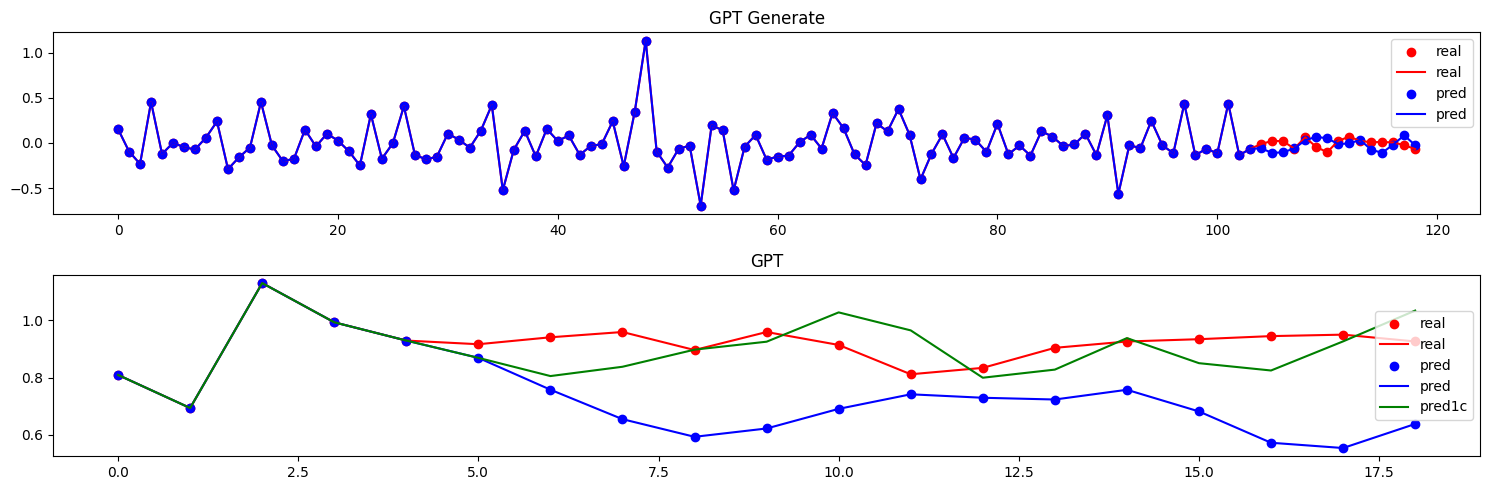

In [106]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([200, 25])
0 train loss =  1.26509690284729
500 train loss =  0.03192627429962158
1000 train loss =  0.014196774922311306
1500 train loss =  0.00842834822833538
2000 train loss =  0.006248082499951124
2500 train loss =  0.0050675468519330025


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


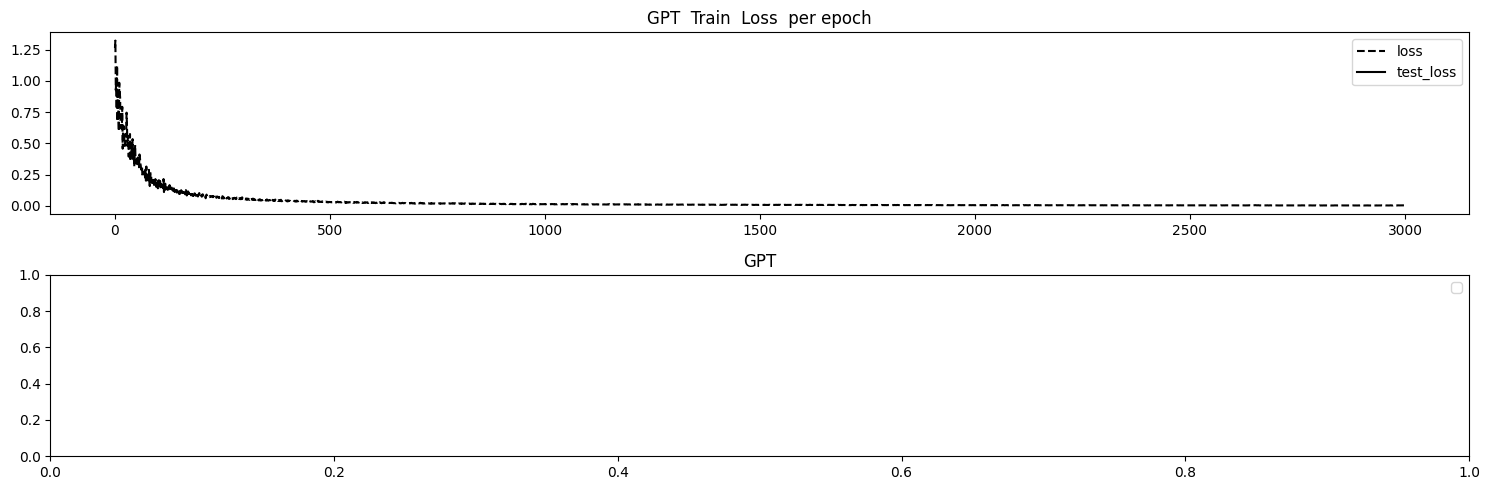

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.03708955645561218
Test MSE Loss - SI only 0-5:  0.16149909794330597
Test MSE Loss - SI only 5-10:  0.0026304854545742273
Test MSE Loss - SI only 10-15:  0.004772670567035675
mae, mse, rmse, mape, mspe, rse, corr
(0.10996613, 0.037089553, 0.19258648, 2.9773467, 32.117718, 1.6499267)
Testing R**2 - SI only:  -1.7222577868544926
Testing R**2 - SI only:  -1.7222577868544926
Testing R**2 - All features:  0.9917844959243907


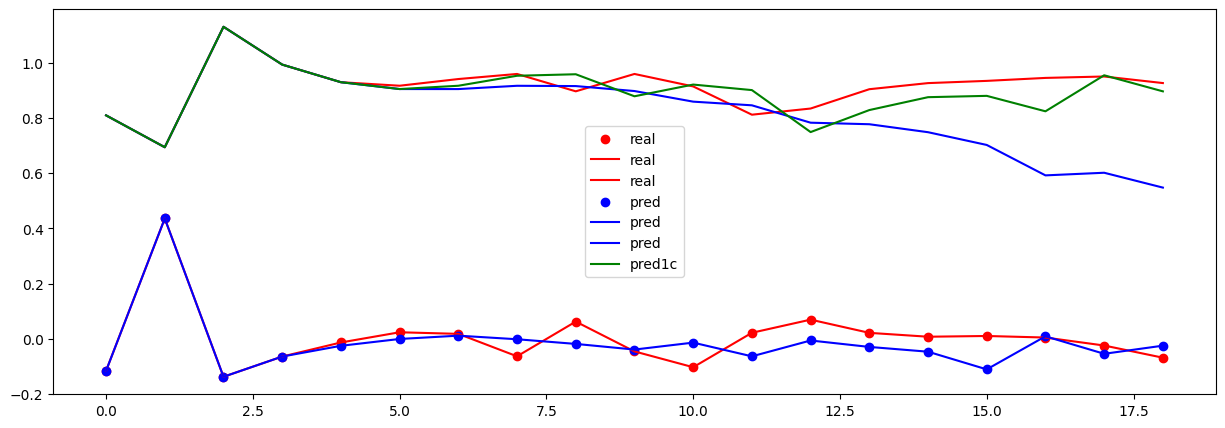

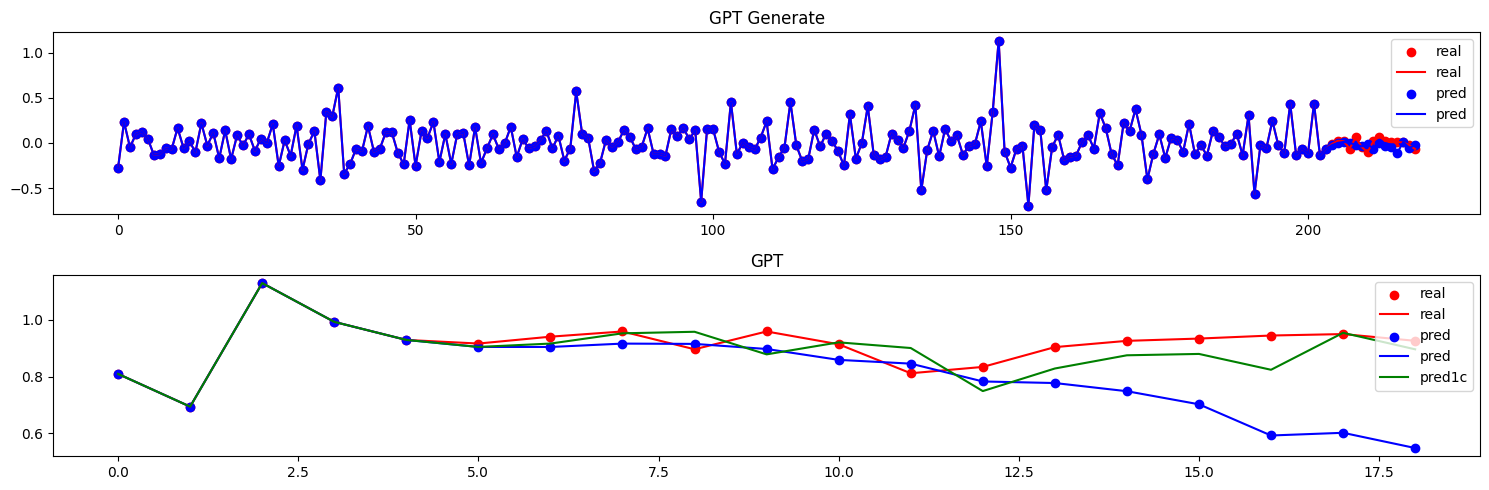

In [107]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([300, 25])
0 train loss =  1.0934277772903442
500 train loss =  0.045051202178001404
1000 train loss =  0.016146643087267876
1500 train loss =  0.010271096602082253
2000 train loss =  0.007507873233407736
2500 train loss =  0.006013014353811741


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


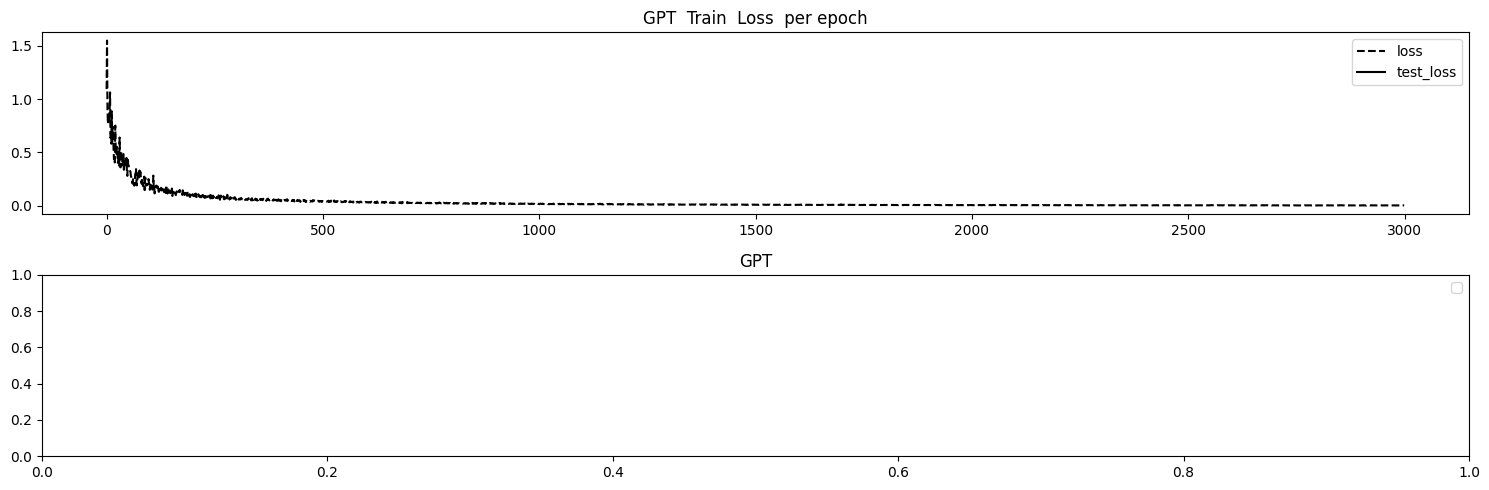

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.03693922609090805
Test MSE Loss - SI only 0-5:  0.16149909794330597
Test MSE Loss - SI only 5-10:  0.0031154719181358814
Test MSE Loss - SI only 10-15:  0.00418587913736701
mae, mse, rmse, mape, mspe, rse, corr
(0.10941129, 0.036939222, 0.19219579, 1.9551338, 5.312858, 1.6465795)
Testing R**2 - SI only:  -1.7112243530859068
Testing R**2 - SI only:  -1.7112243530859068
Testing R**2 - All features:  0.9913105427907108


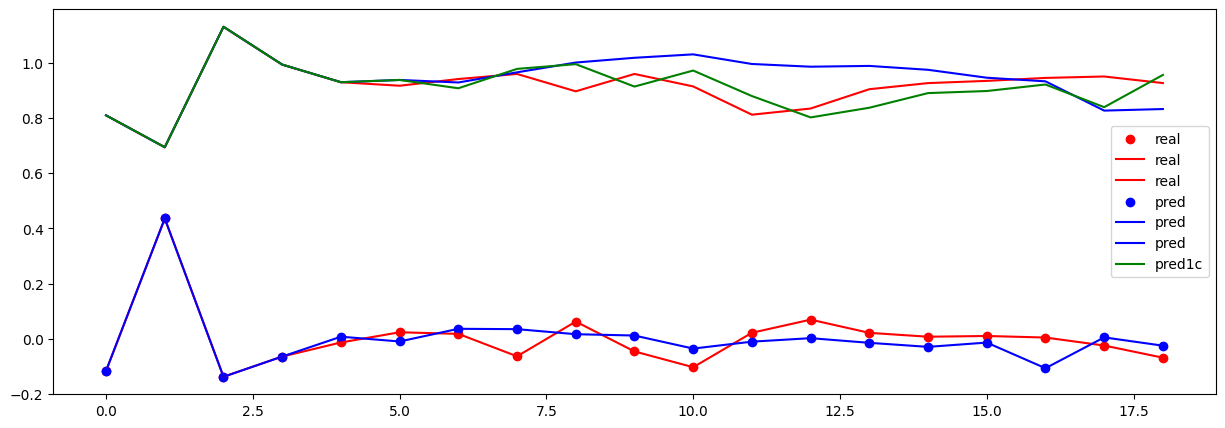

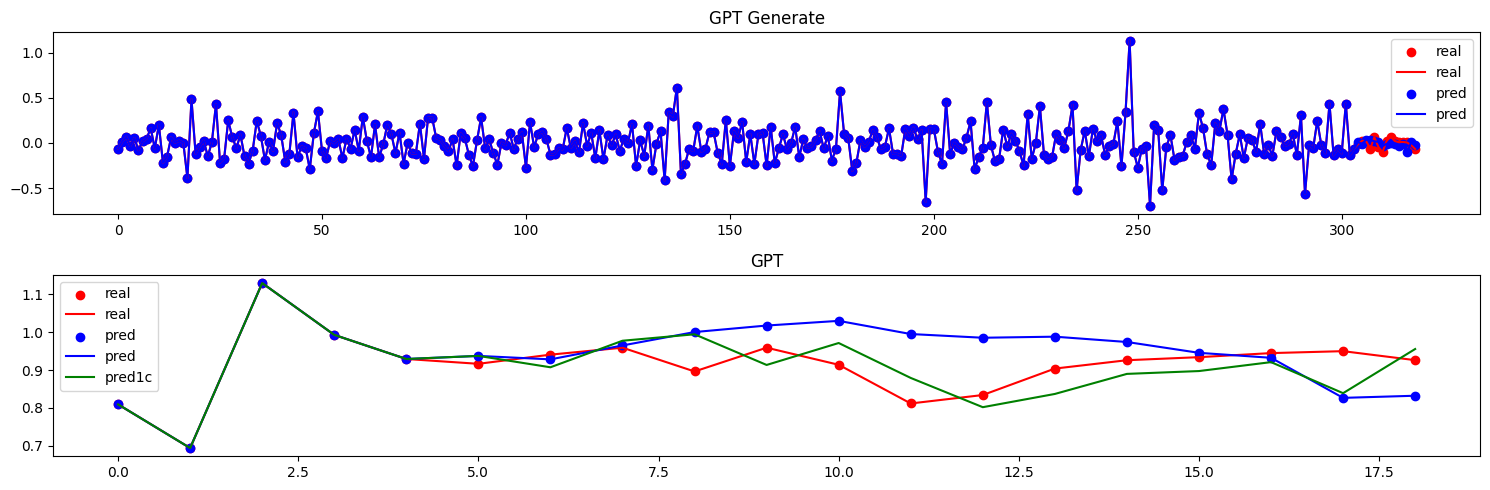

In [108]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([400, 25])
0 train loss =  1.2633708715438843
500 train loss =  0.06802816689014435
1000 train loss =  0.024986689910292625
1500 train loss =  0.013253835029900074
2000 train loss =  0.009338856674730778
2500 train loss =  0.007700628135353327


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


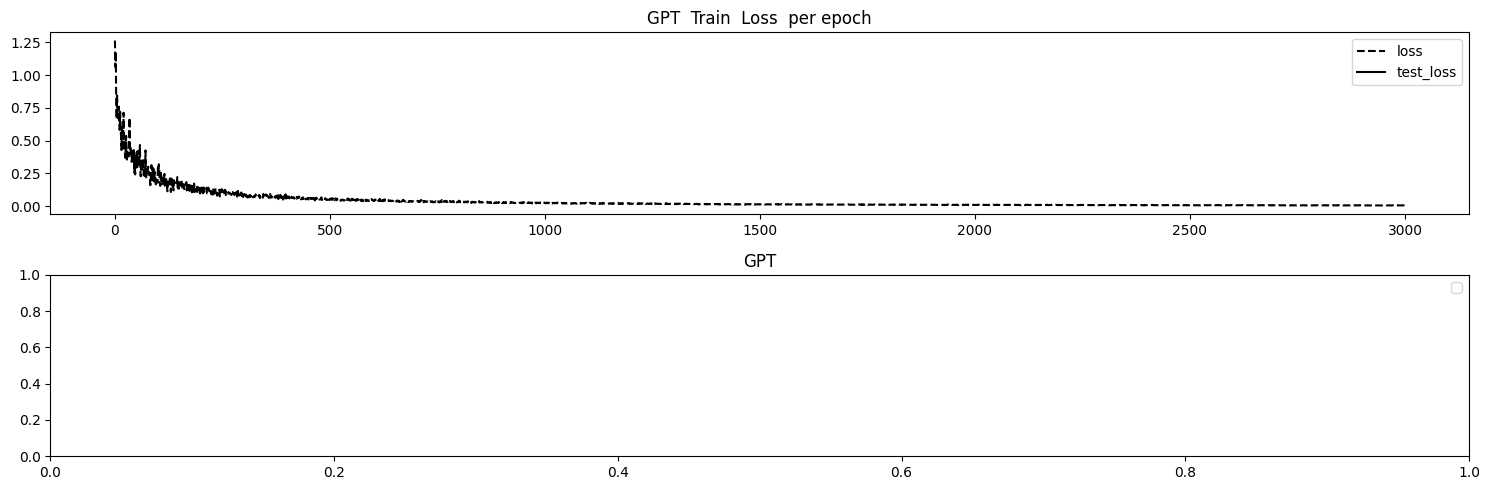

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.038172703236341476
Test MSE Loss - SI only 0-5:  0.16149909794330597
Test MSE Loss - SI only 5-10:  0.0032821414060890675
Test MSE Loss - SI only 10-15:  0.006697295233607292
mae, mse, rmse, mape, mspe, rse, corr
(0.11575343, 0.038172707, 0.19537836, 3.0682635, 30.95061, 1.6738453)
Testing R**2 - SI only:  -1.8017578076458172
Testing R**2 - SI only:  -1.8017578076458172
Testing R**2 - All features:  0.993608897472508


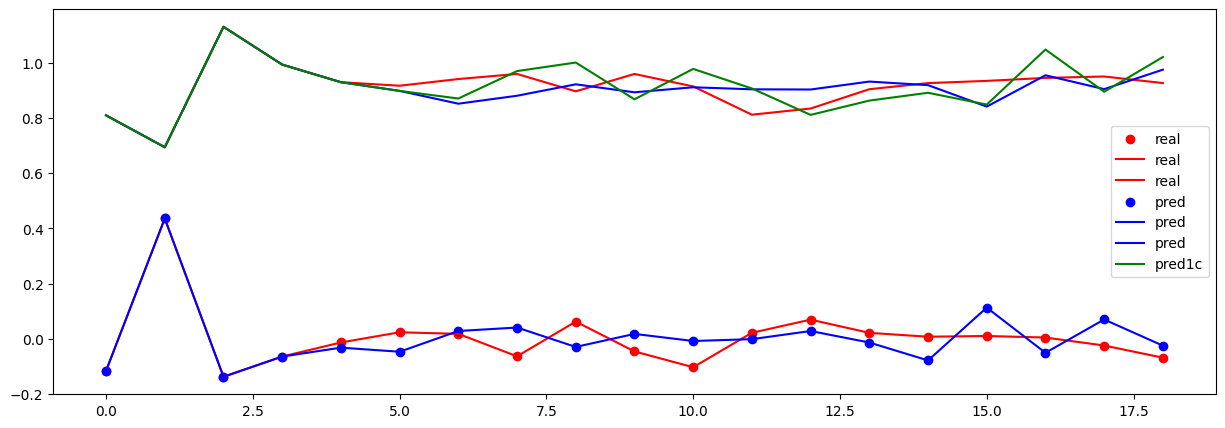

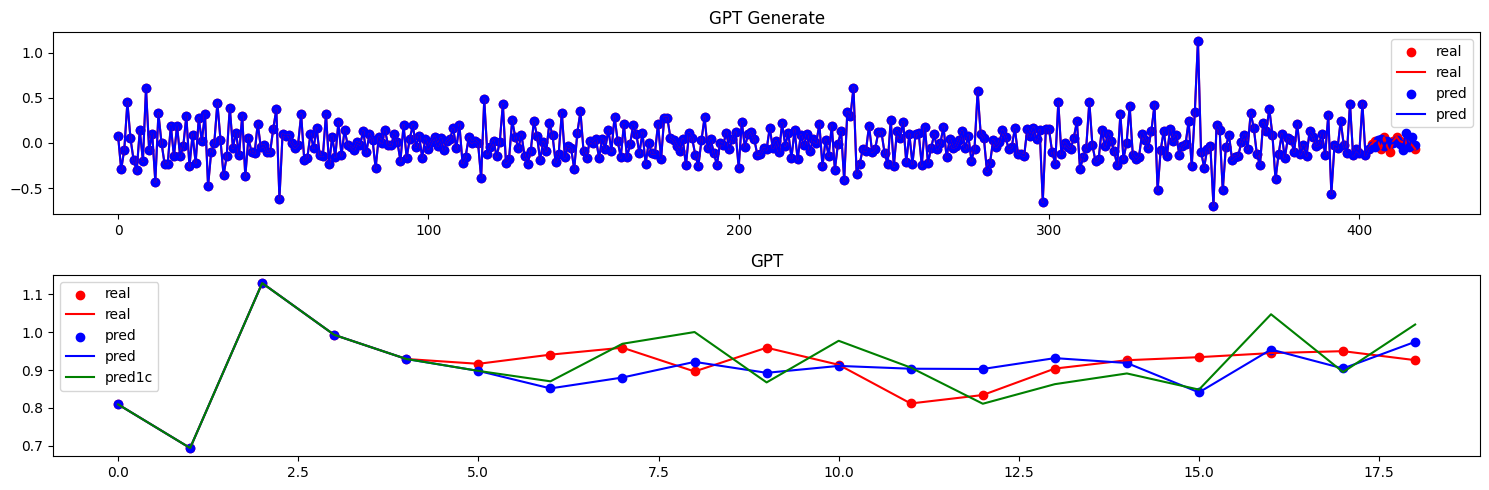

In [109]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 6


In [110]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


1383
758
1173
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  1.1253745555877686
500 train loss =  0.02270224504172802
1000 train loss =  0.009947621263563633
1500 train loss =  0.006457433104515076
2000 train loss =  0.004615040961652994
2500 train loss =  0.0035257581621408463


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


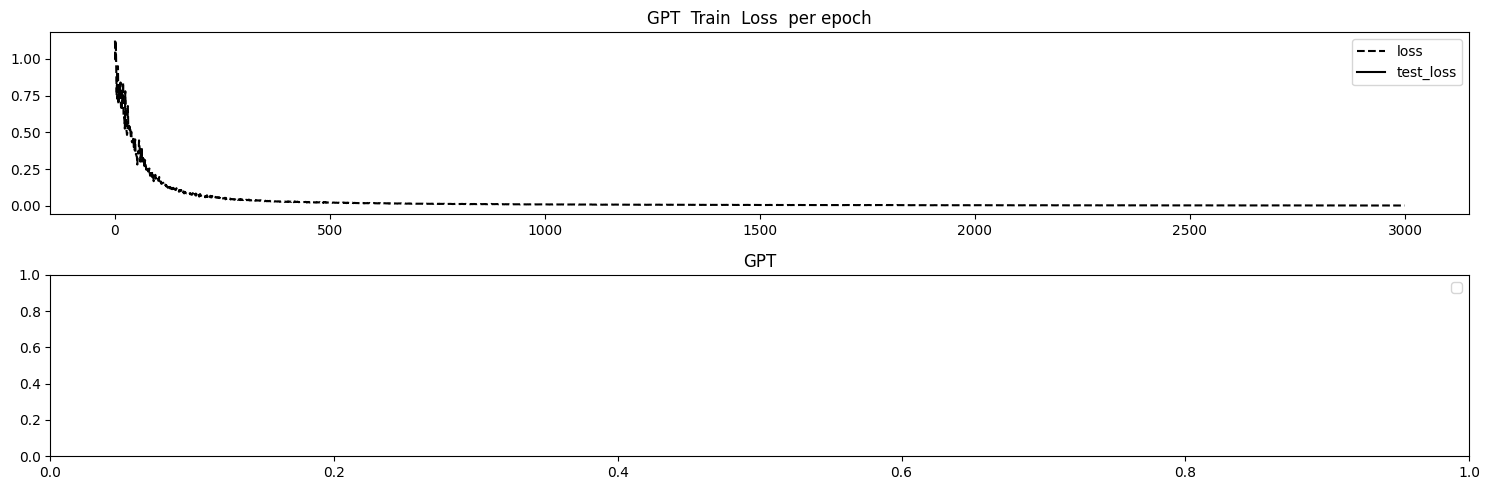

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.06055387854576111
Test MSE Loss - SI only 0-5:  0.1601482480764389
Test MSE Loss - SI only 5-10:  0.025644462555646896
Test MSE Loss - SI only 10-15:  0.04039453715085983
mae, mse, rmse, mape, mspe, rse, corr
(0.20275283, 0.06055389, 0.246077, 1.7049214, 7.416459, 1.3147391)
Testing R**2 - SI only:  -0.7285384613035051
Testing R**2 - SI only:  -0.7285384613035051
Testing R**2 - All features:  0.994150657454905


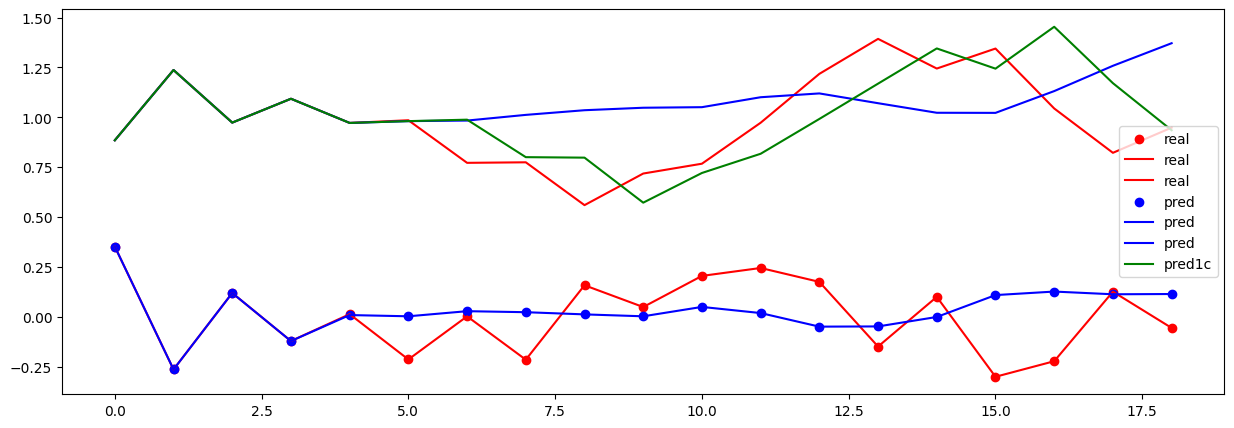

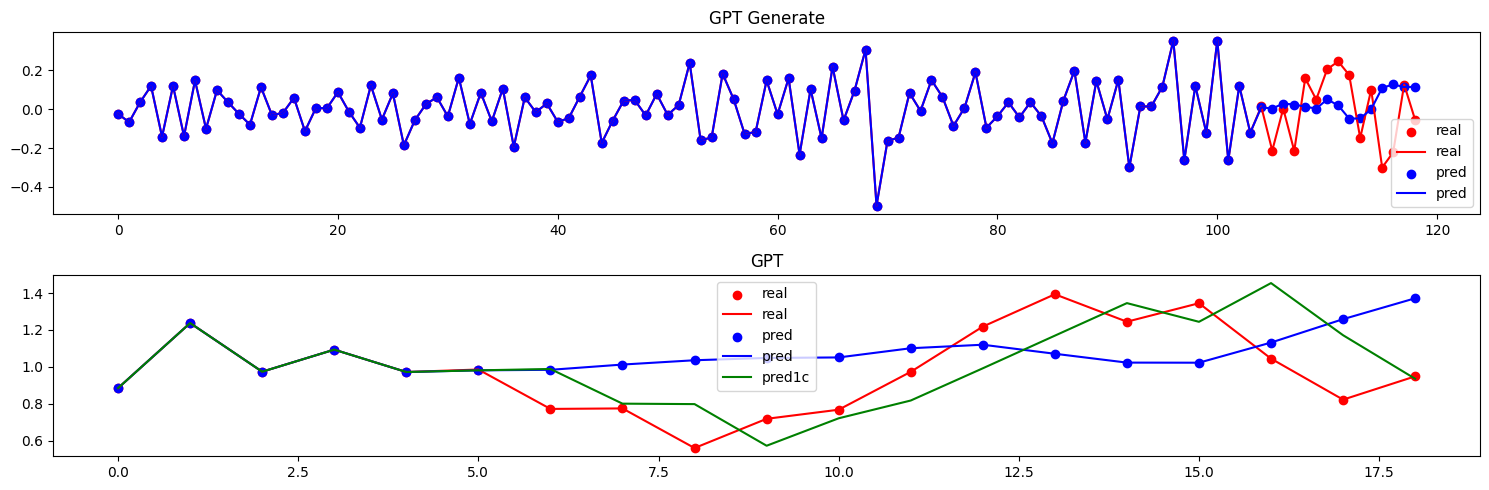

In [111]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([200, 25])
0 train loss =  1.5880157947540283
500 train loss =  0.03147855028510094
1000 train loss =  0.013197564519941807
1500 train loss =  0.00748345535248518
2000 train loss =  0.005713354796171188
2500 train loss =  0.004544129595160484


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


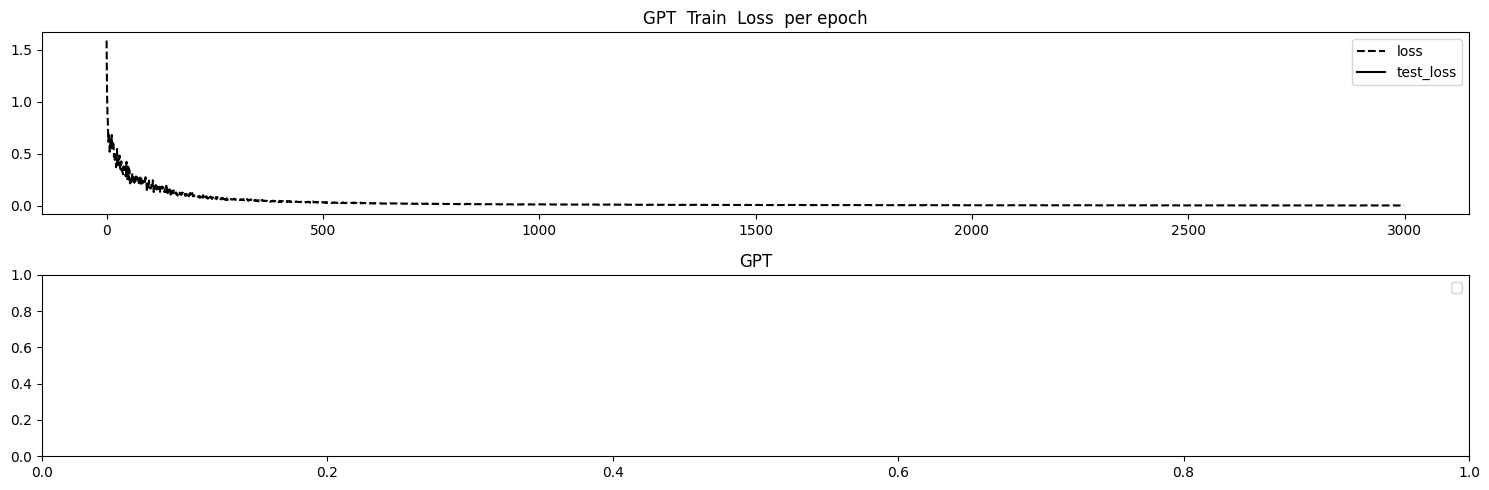

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.0580863393843174
Test MSE Loss - SI only 0-5:  0.1601482480764389
Test MSE Loss - SI only 5-10:  0.0215156190097332
Test MSE Loss - SI only 10-15:  0.037479083985090256
mae, mse, rmse, mape, mspe, rse, corr
(0.19761832, 0.05808634, 0.24101108, 1.7845049, 7.6072154, 1.2876729)
Testing R**2 - SI only:  -0.6581013044316948
Testing R**2 - SI only:  -0.6581013044316948
Testing R**2 - All features:  0.9970213662364035


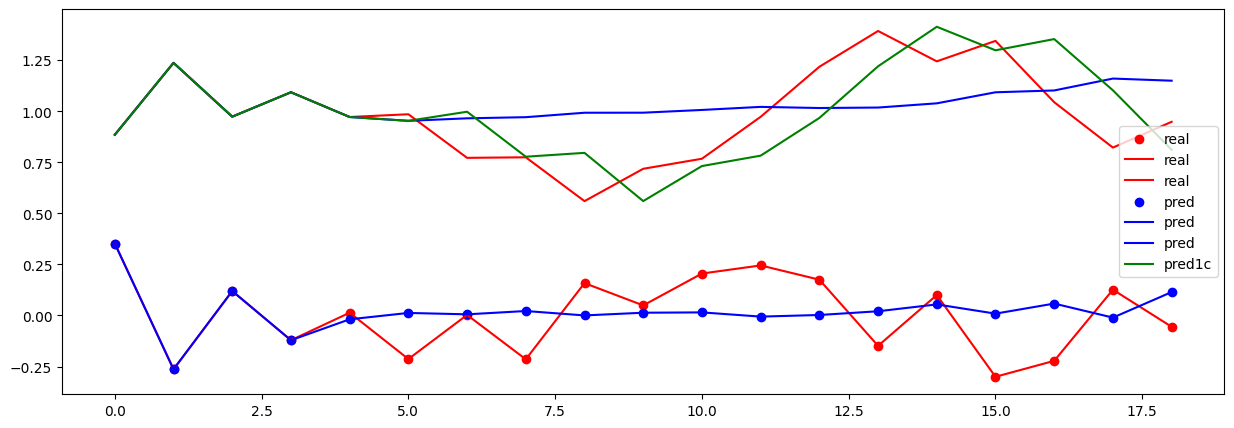

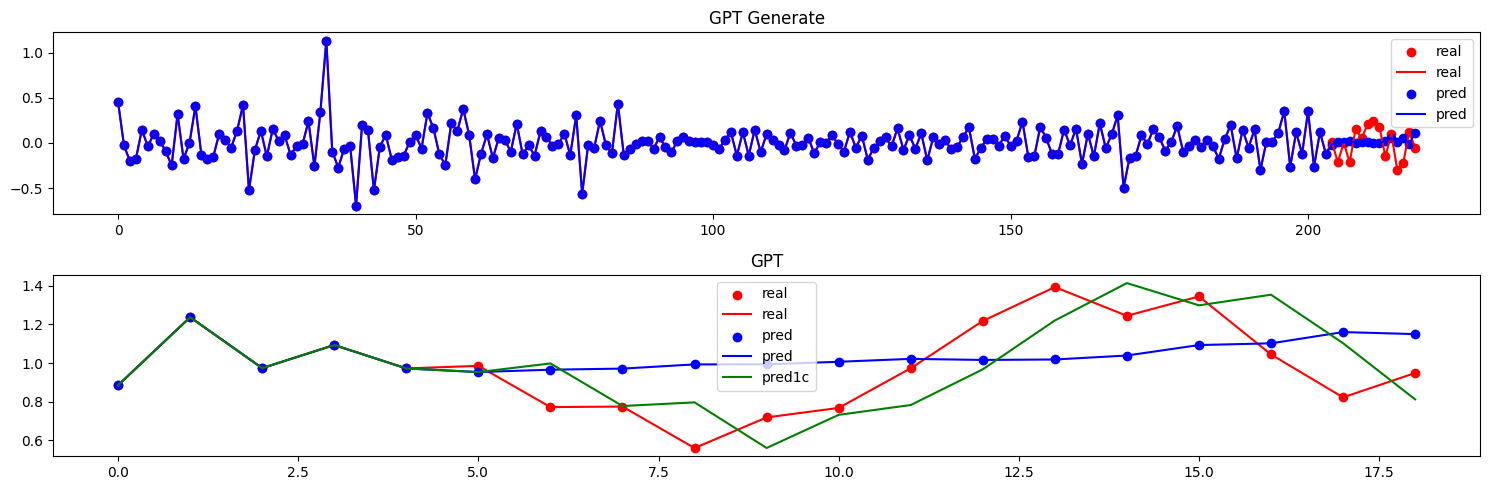

In [112]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([300, 25])
0 train loss =  1.527794599533081
500 train loss =  0.05441156029701233
1000 train loss =  0.024451451376080513
1500 train loss =  0.017210565507411957
2000 train loss =  0.011109797284007072
2500 train loss =  0.007223125547170639


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


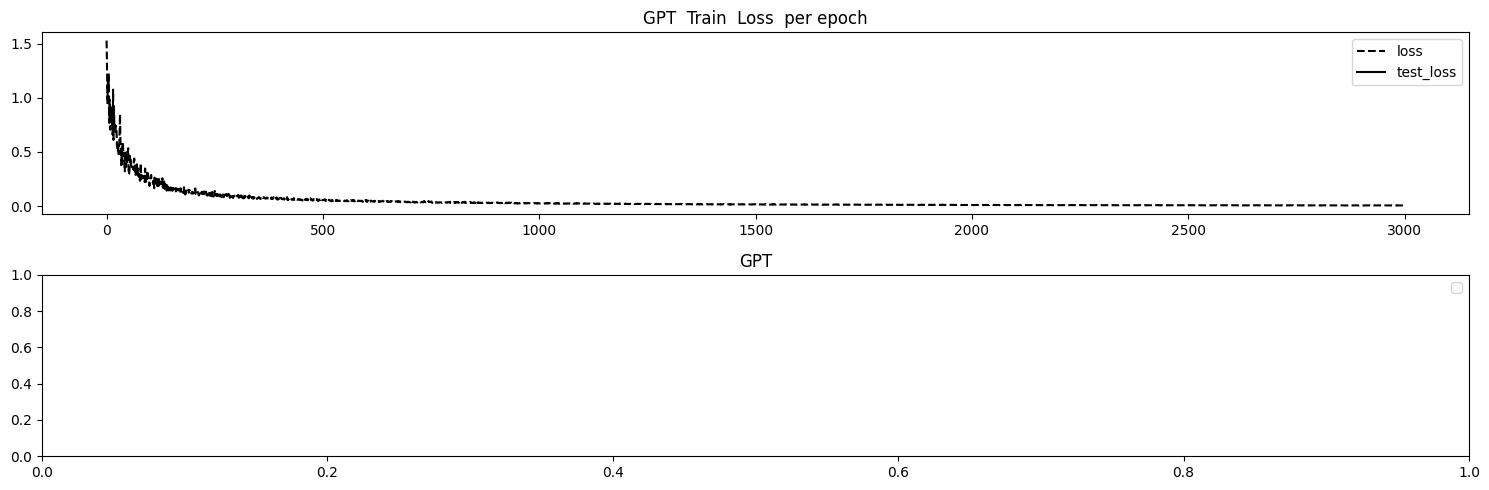

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.059791628271341324
Test MSE Loss - SI only 0-5:  0.1601482480764389
Test MSE Loss - SI only 5-10:  0.039719387888908386
Test MSE Loss - SI only 10-15:  0.030965927988290787
mae, mse, rmse, mape, mspe, rse, corr
(0.2056778, 0.05979162, 0.24452326, 2.187442, 10.664151, 1.3064377)
Testing R**2 - SI only:  -0.7067794721865015
Testing R**2 - SI only:  -0.7067794721865015
Testing R**2 - All features:  0.9983574672889733


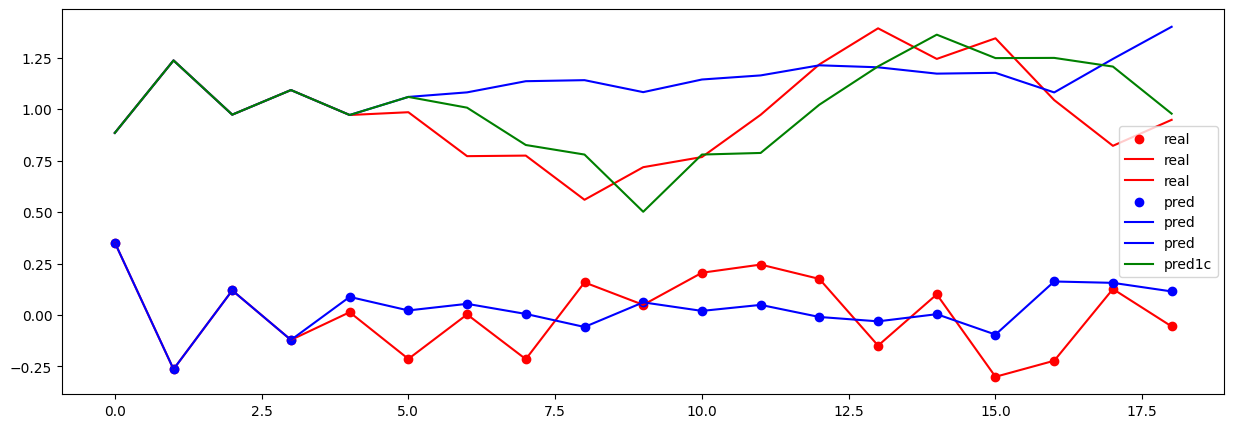

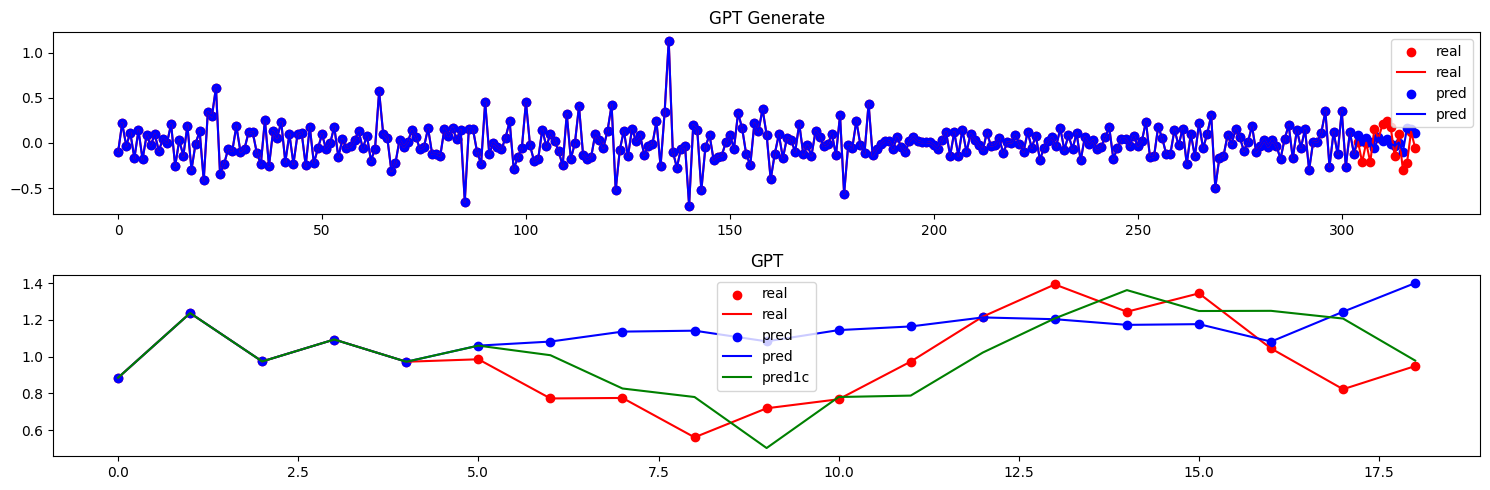

In [113]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([400, 25])
0 train loss =  1.6479544639587402
500 train loss =  0.05655856430530548
1000 train loss =  0.028117068111896515
1500 train loss =  0.015498602762818336
2000 train loss =  0.013000871986150742
2500 train loss =  0.007982359267771244


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


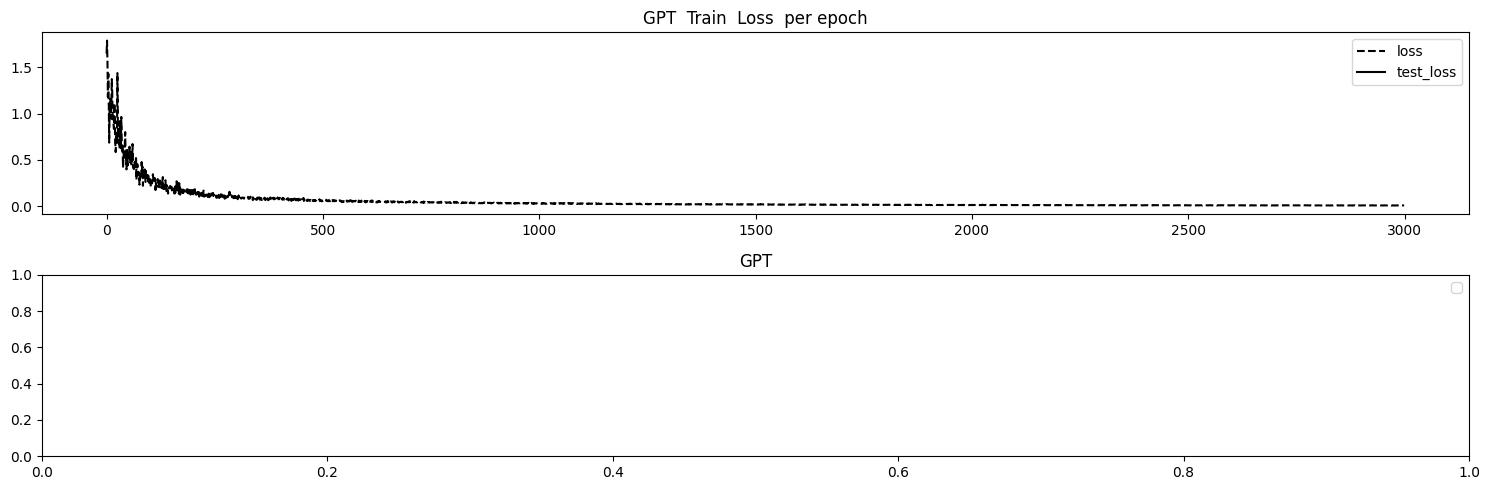

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.05773955211043358
Test MSE Loss - SI only 0-5:  0.1601482480764389
Test MSE Loss - SI only 5-10:  0.02812356688082218
Test MSE Loss - SI only 10-15:  0.03307589516043663
mae, mse, rmse, mape, mspe, rse, corr
(0.19926305, 0.057739552, 0.24029055, 3.1554515, 54.38328, 1.2838233)
Testing R**2 - SI only:  -0.6482020439782239
Testing R**2 - SI only:  -0.6482020439782239
Testing R**2 - All features:  0.997405481135571


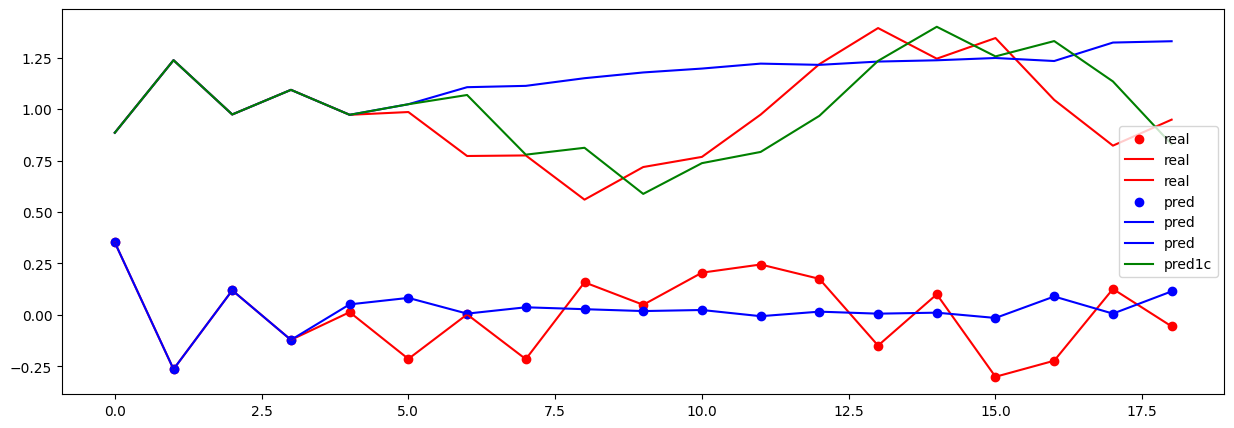

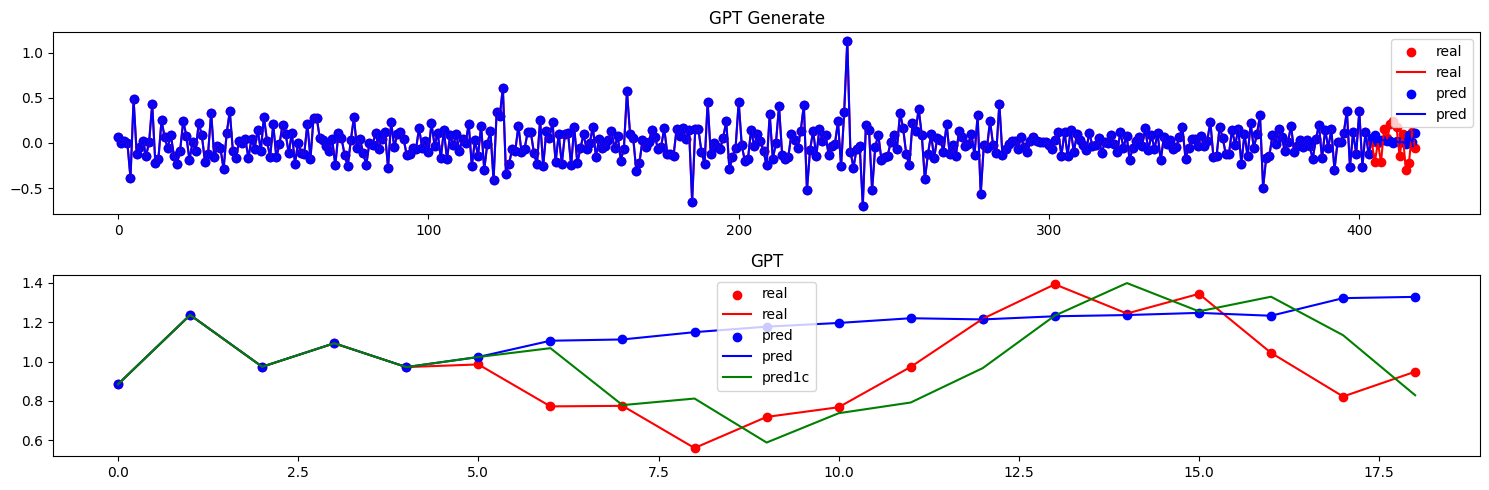

In [114]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()
